### Connect to Colab

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 6

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Lecture 6


### Install missing libraries

In [ ]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.1 MB/s eta 0:00:00


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from PIL import Image
import seaborn as sns
import imageio
import shutil
import glob

### Load and process data

In [ ]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()
X = np.concatenate([X_train_val,X_test],axis=0)
X = np.expand_dims(((X-127.5)/127.5),axis=-1).astype('float32')
y = np.concatenate([y_train_val,y_test],axis=0)
X.shape, y.shape

4422102/4422102 [==============================] - 0s 0us/step


((70000, 28, 28, 1), (70000,))

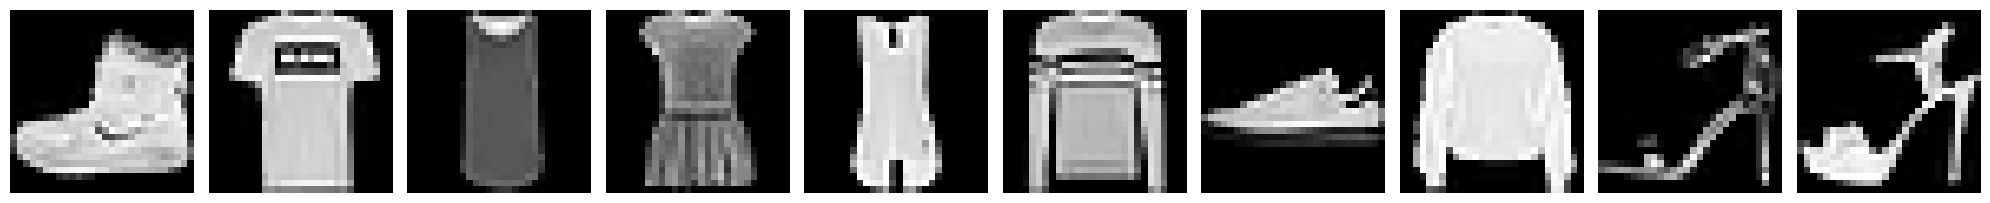

In [ ]:
# Inspect the data
fig, axes = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    ax = axes[i%10]
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print('Data shape', X.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))

Data shape (70000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.43
Data std 0.71


In [ ]:
input_shape = X.shape[1:]
input_shape

(28, 28, 1)

### Vanilla Generative Adversarial Network

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 padding (ZeroPadding2D)     (None, 32, 32, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 64)        640       
                                                                 
 bn1 (BatchNormalization)    (None, 16, 16, 64)        256       
                                                                 
 activation1 (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 bn2 (BatchNormalization)    (None, 8, 8, 128)       

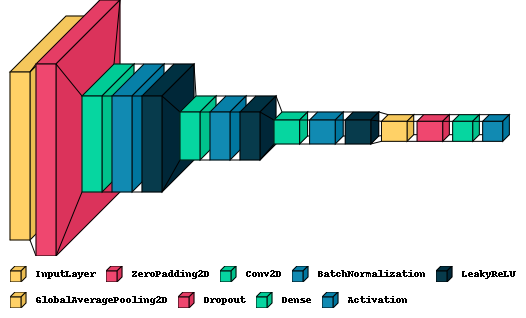

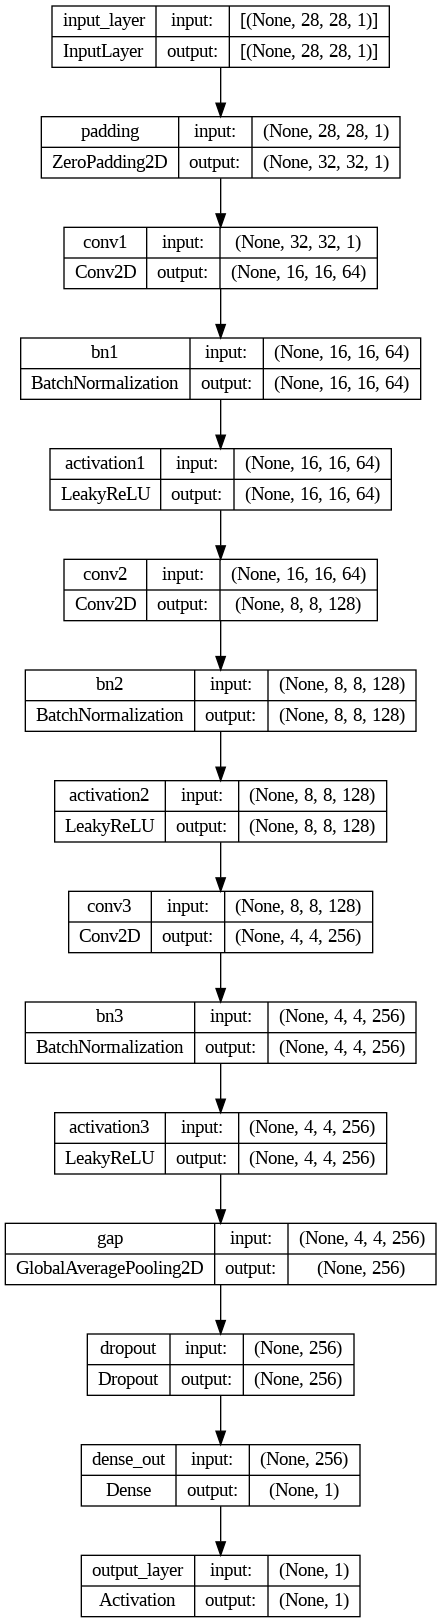

In [ ]:
def get_dc_discriminator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.5, seed=seed, name='dropout')(x)
    x = tfkl.Dense(1, name='dense_out')(x)
    output_layer = tfkl.Activation('sigmoid', name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

    # Return the discriminator
    return model
discriminator = get_dc_discriminator(input_shape)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='vanilla_discriminator.png')

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128)]             0         
                                                                 
 dense0 (Dense)              (None, 1024)              131072    
                                                                 
 bn0 (BatchNormalization)    (None, 1024)              4096      
                                                                 
 activation0 (LeakyReLU)     (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 upsampling1 (UpSampling2D)  (None, 8, 8, 64)          0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          36

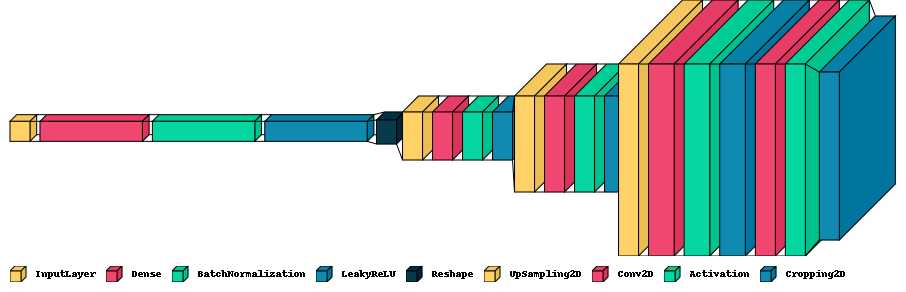

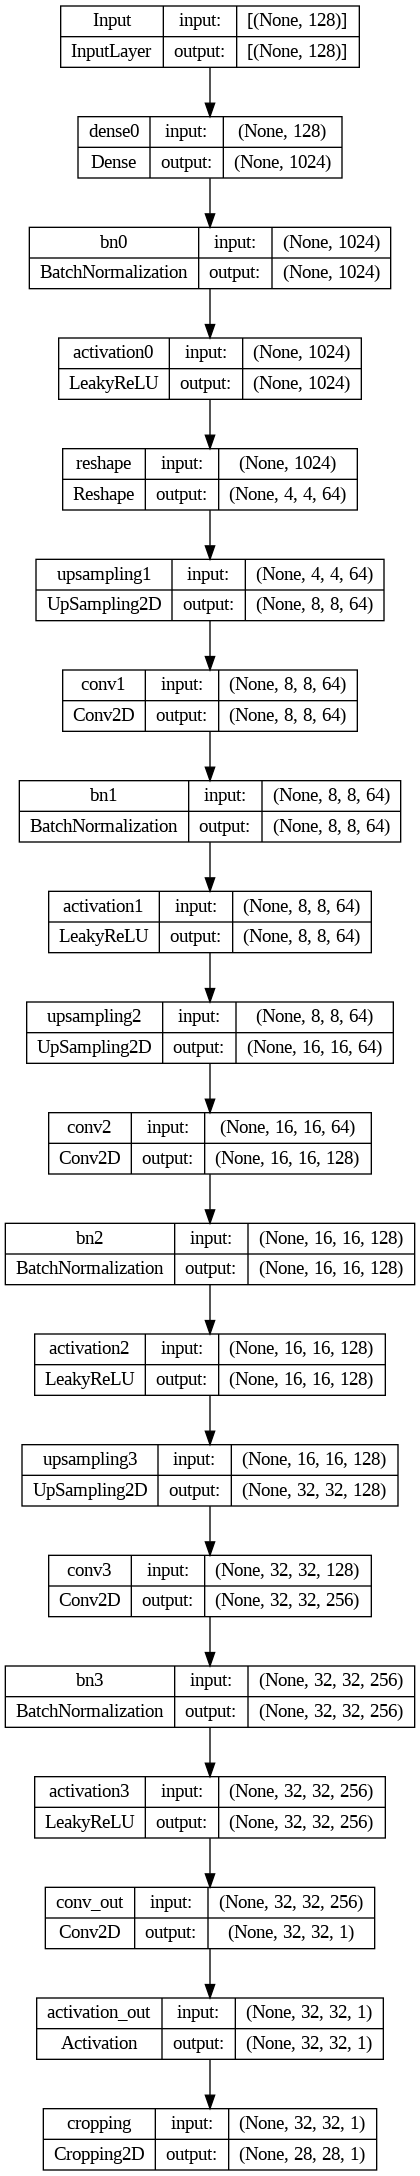

In [ ]:
latent_dim = 128

def get_dc_generator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the generator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Dense(4*4*64, use_bias=False, name='dense0')(input_layer)
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4,4,64))(x)

    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    x = tfkl.Activation('tanh', name='activation_out')(x)
    output_layer = tfkl.Cropping2D((2,2), name='cropping')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model
generator = get_dc_generator(latent_dim)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='vanilla_generator.png')

In [ ]:
class GAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images from z
        generated_images = self.generator(z)

        # Combine generated images and real ones
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)


        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(z)
            misleading_predictions = self.discriminator(generated_images)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
class GANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png')
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)
        shutil.rmtree(self.name+"temp")

In [ ]:
epochs = 100
learning_rate = 5e-5
batch_size = 128

In [ ]:
gan = GAN(
    discriminator = get_dc_discriminator(input_shape),
    generator = get_dc_generator(latent_dim),
    latent_dim = latent_dim
)
gan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [ ]:
def sample(model, num_img, latent_dim, fixed=True, gray=False):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generate_dataset(model, num_img, latent_dim, fixed=True):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()
    return generated_images

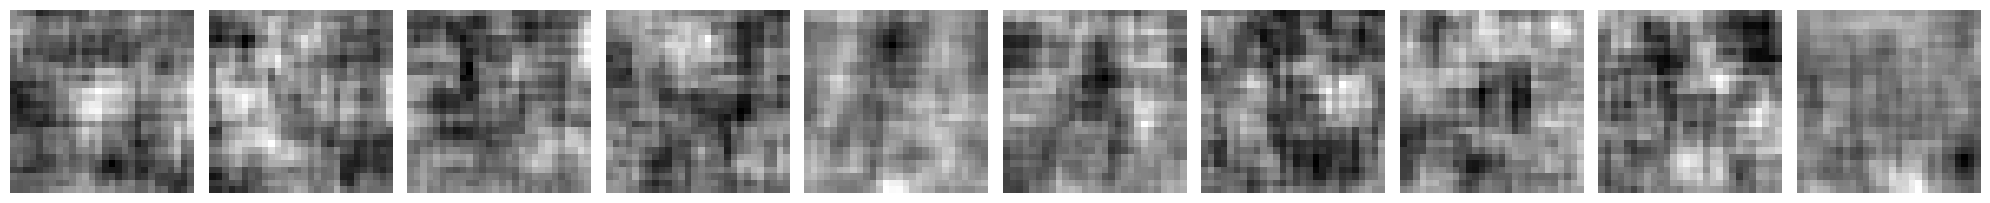

In [ ]:
sample(gan.generator, 10, latent_dim, fixed=False, gray=True)

Epoch 1/100


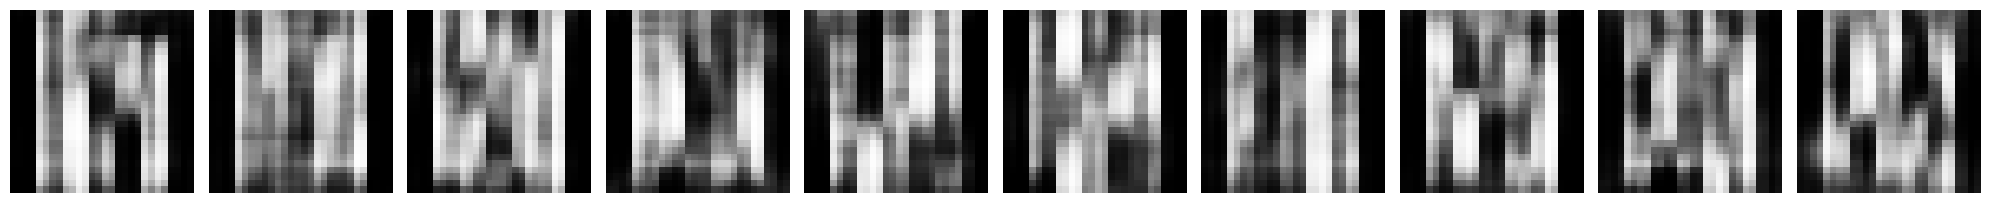

547/547 - 24s - loss: 1.4739 - d_loss: 0.6542 - g_loss: 0.8197 - 24s/epoch - 43ms/step
Epoch 2/100


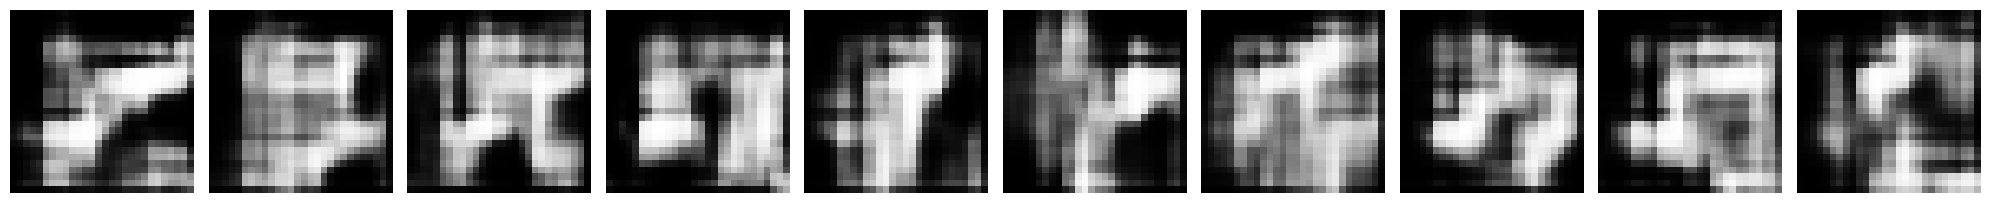

547/547 - 22s - loss: 1.4876 - d_loss: 0.6648 - g_loss: 0.8228 - 22s/epoch - 41ms/step
Epoch 3/100


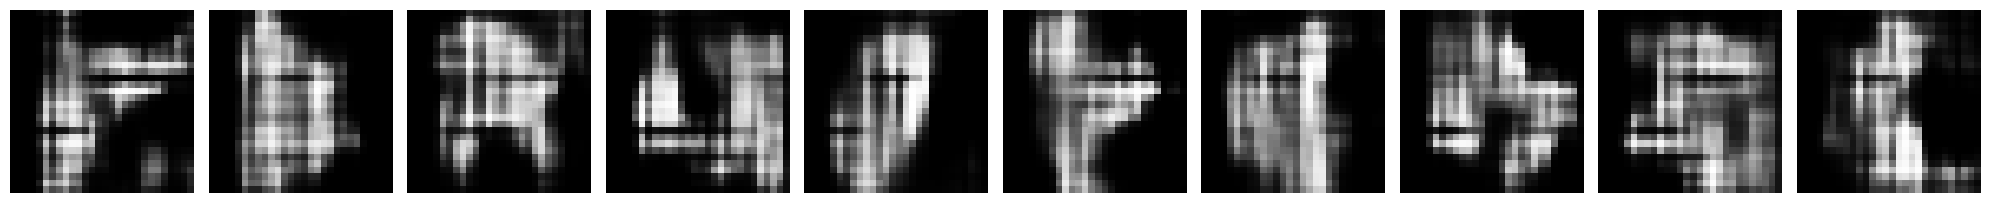

547/547 - 23s - loss: 1.4000 - d_loss: 0.6907 - g_loss: 0.7093 - 23s/epoch - 42ms/step
Epoch 4/100


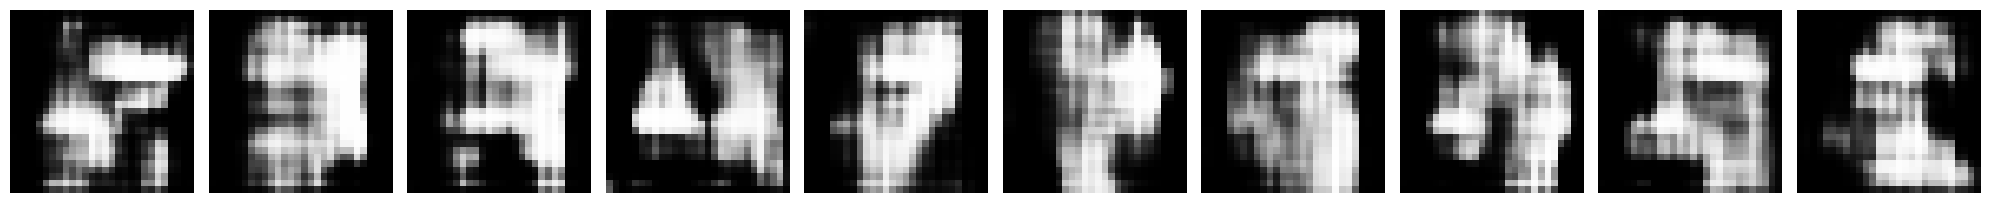

547/547 - 23s - loss: 1.4318 - d_loss: 0.6765 - g_loss: 0.7553 - 23s/epoch - 42ms/step
Epoch 5/100


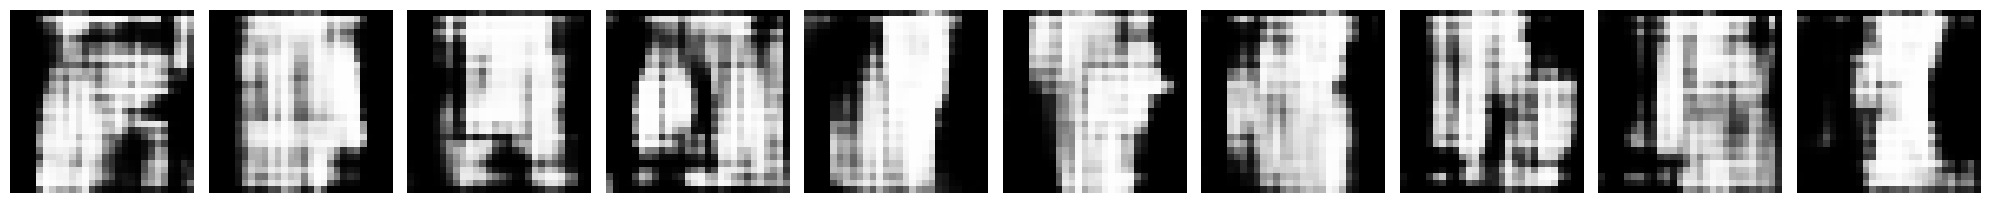

547/547 - 23s - loss: 1.4245 - d_loss: 0.6802 - g_loss: 0.7443 - 23s/epoch - 41ms/step
Epoch 6/100


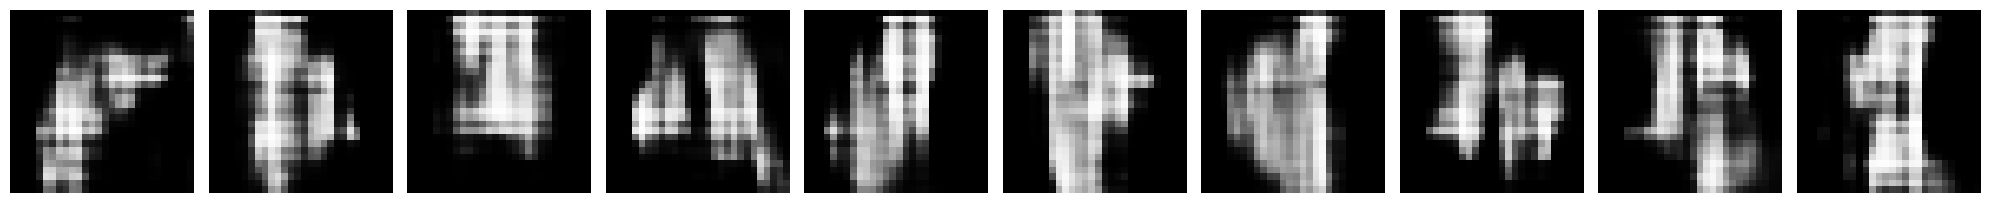

547/547 - 23s - loss: 1.4325 - d_loss: 0.6763 - g_loss: 0.7562 - 23s/epoch - 41ms/step
Epoch 7/100


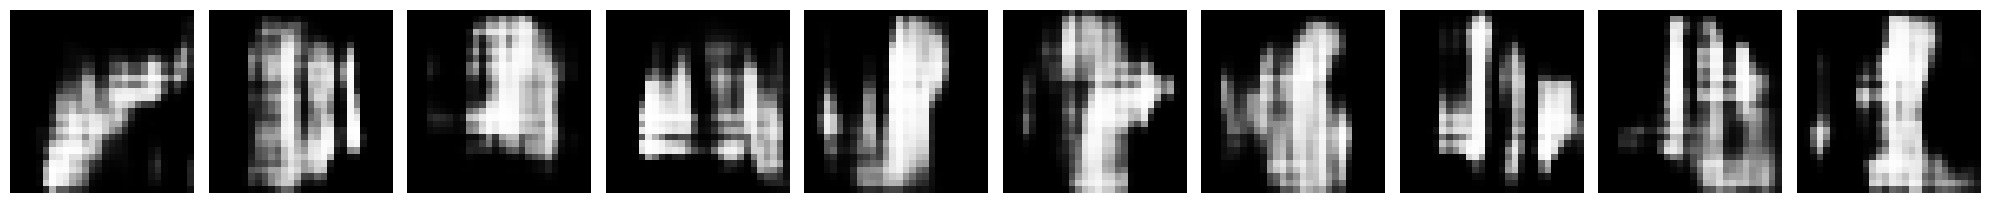

547/547 - 23s - loss: 1.3966 - d_loss: 0.6840 - g_loss: 0.7126 - 23s/epoch - 41ms/step
Epoch 8/100


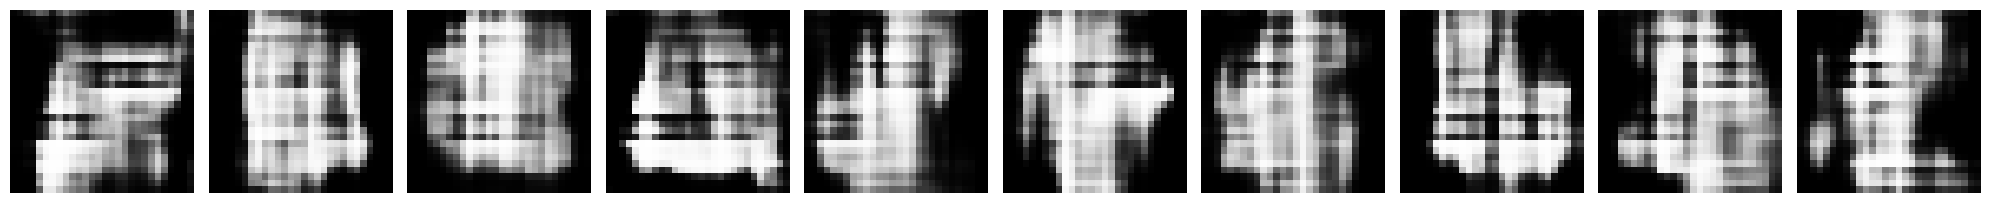

547/547 - 23s - loss: 1.4333 - d_loss: 0.6801 - g_loss: 0.7532 - 23s/epoch - 41ms/step
Epoch 9/100


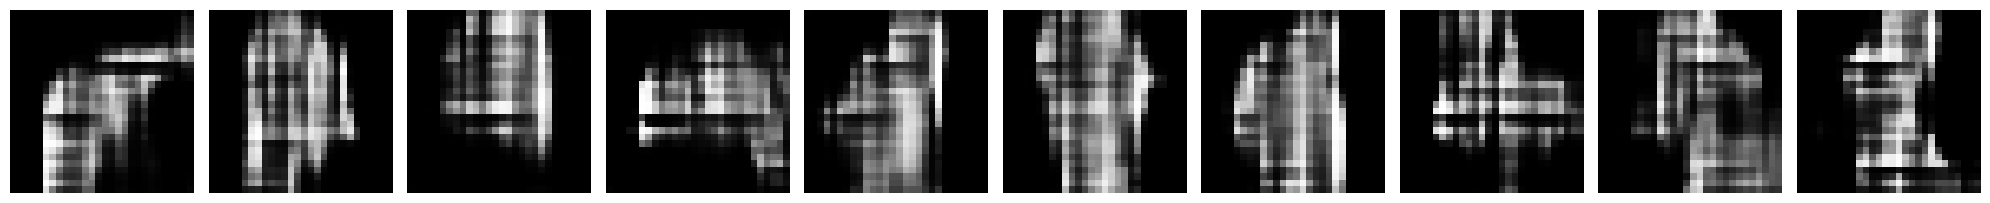

547/547 - 23s - loss: 1.4097 - d_loss: 0.6790 - g_loss: 0.7307 - 23s/epoch - 41ms/step
Epoch 10/100


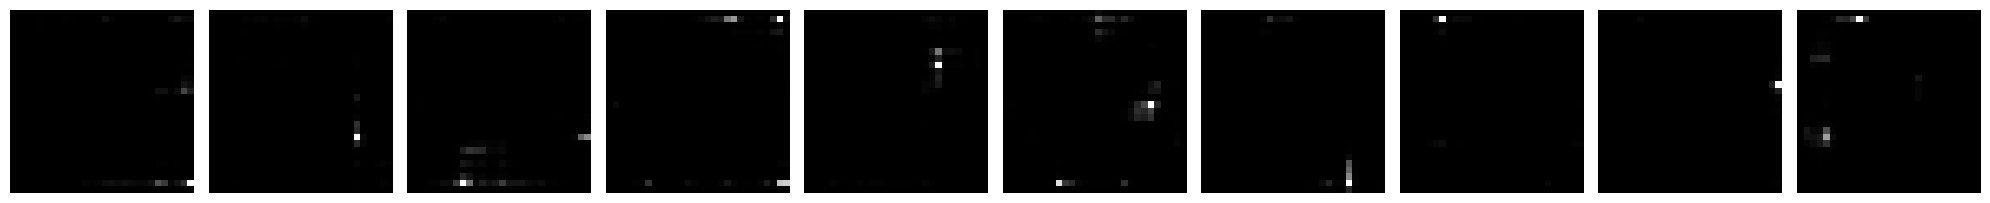

547/547 - 23s - loss: 1.4191 - d_loss: 0.6791 - g_loss: 0.7400 - 23s/epoch - 42ms/step
Epoch 11/100


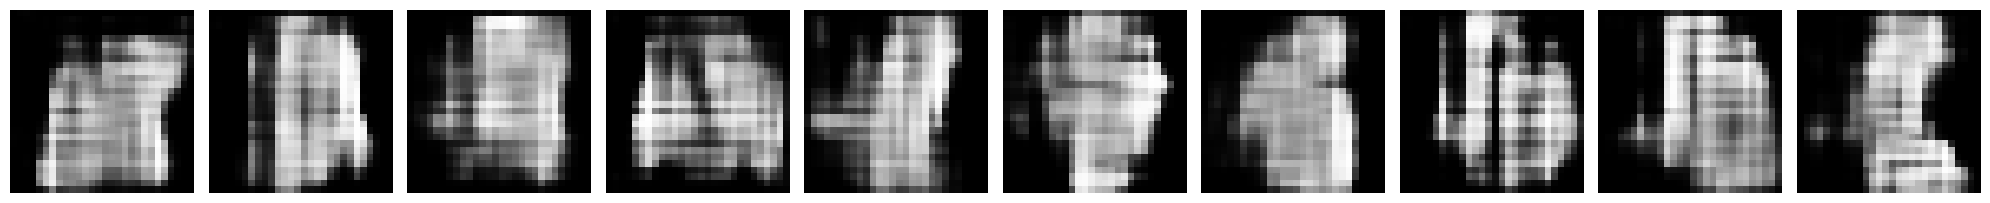

547/547 - 23s - loss: 1.4422 - d_loss: 0.6769 - g_loss: 0.7653 - 23s/epoch - 42ms/step
Epoch 12/100


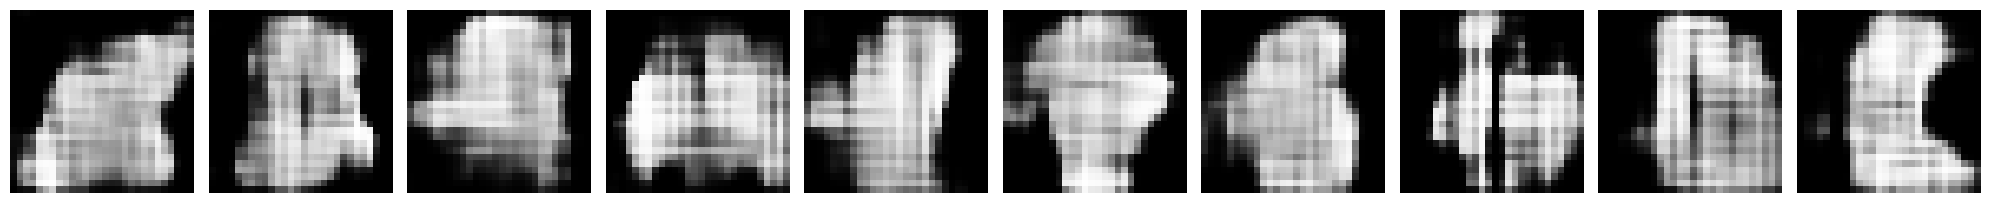

547/547 - 23s - loss: 1.4283 - d_loss: 0.6801 - g_loss: 0.7482 - 23s/epoch - 42ms/step
Epoch 13/100


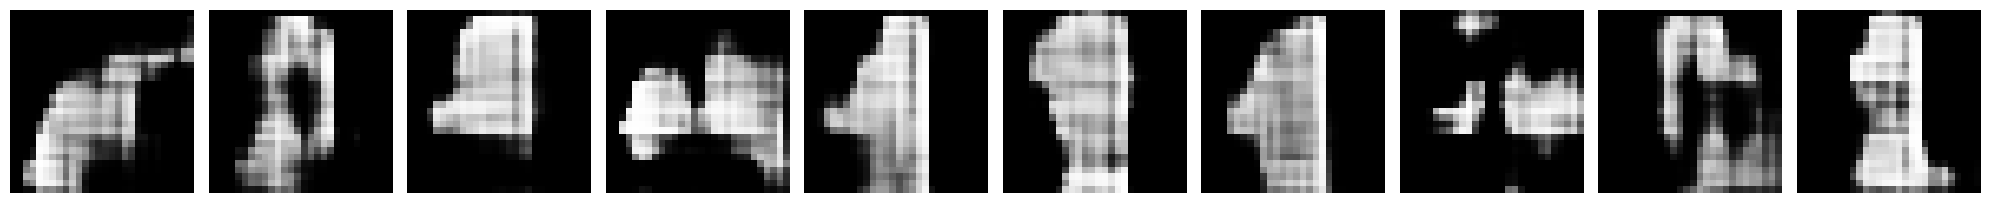

547/547 - 23s - loss: 1.3982 - d_loss: 0.6800 - g_loss: 0.7183 - 23s/epoch - 42ms/step
Epoch 14/100


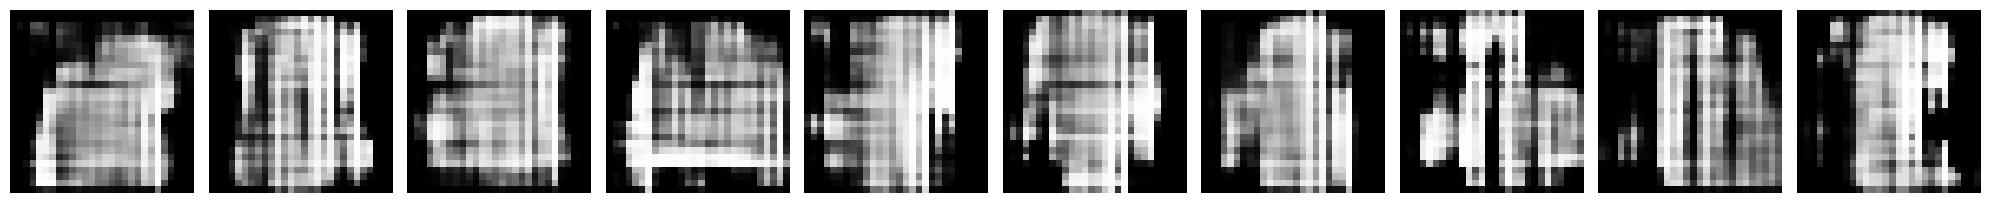

547/547 - 23s - loss: 1.4553 - d_loss: 0.6725 - g_loss: 0.7829 - 23s/epoch - 42ms/step
Epoch 15/100


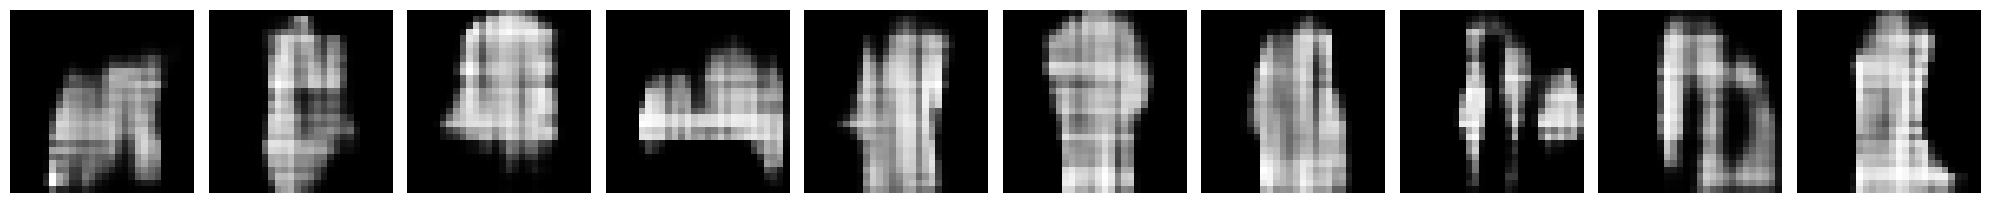

547/547 - 23s - loss: 1.4186 - d_loss: 0.6788 - g_loss: 0.7398 - 23s/epoch - 42ms/step
Epoch 16/100


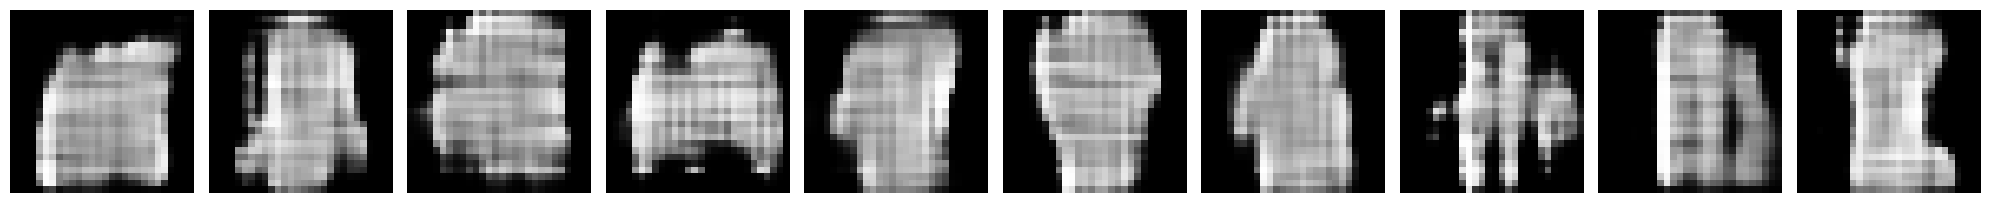

547/547 - 23s - loss: 1.4279 - d_loss: 0.6793 - g_loss: 0.7486 - 23s/epoch - 42ms/step
Epoch 17/100


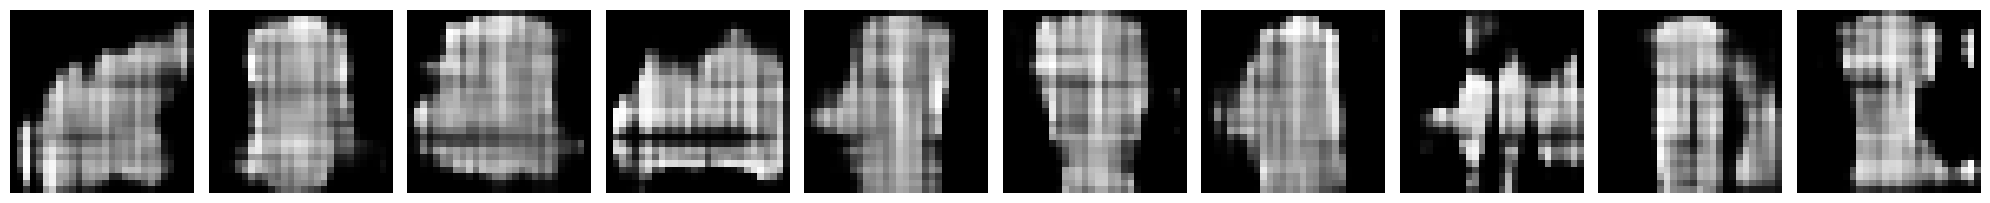

547/547 - 23s - loss: 1.3996 - d_loss: 0.6771 - g_loss: 0.7225 - 23s/epoch - 42ms/step
Epoch 18/100


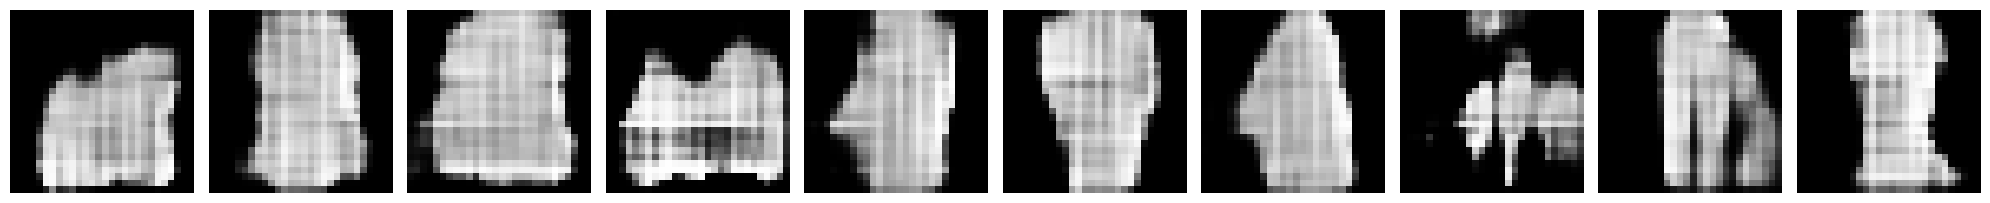

547/547 - 23s - loss: 1.4247 - d_loss: 0.6799 - g_loss: 0.7448 - 23s/epoch - 42ms/step
Epoch 19/100


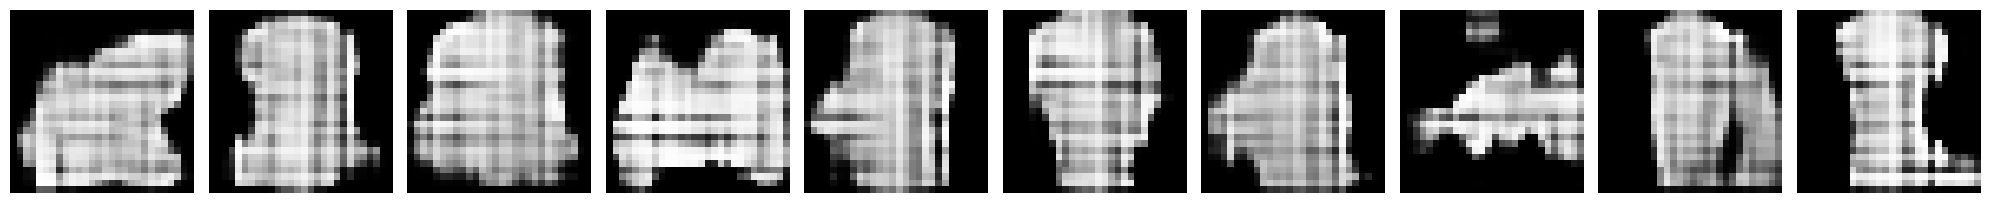

547/547 - 23s - loss: 1.4371 - d_loss: 0.6746 - g_loss: 0.7625 - 23s/epoch - 43ms/step
Epoch 20/100


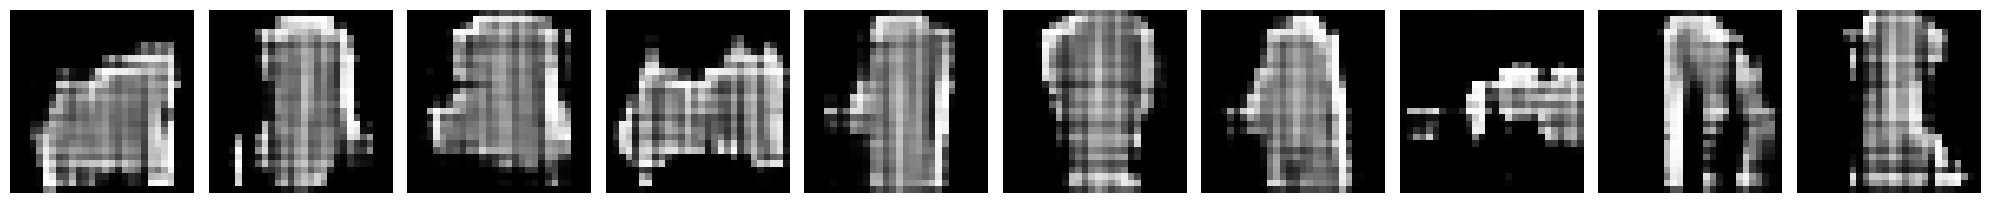

547/547 - 23s - loss: 1.4171 - d_loss: 0.6736 - g_loss: 0.7435 - 23s/epoch - 42ms/step
Epoch 21/100


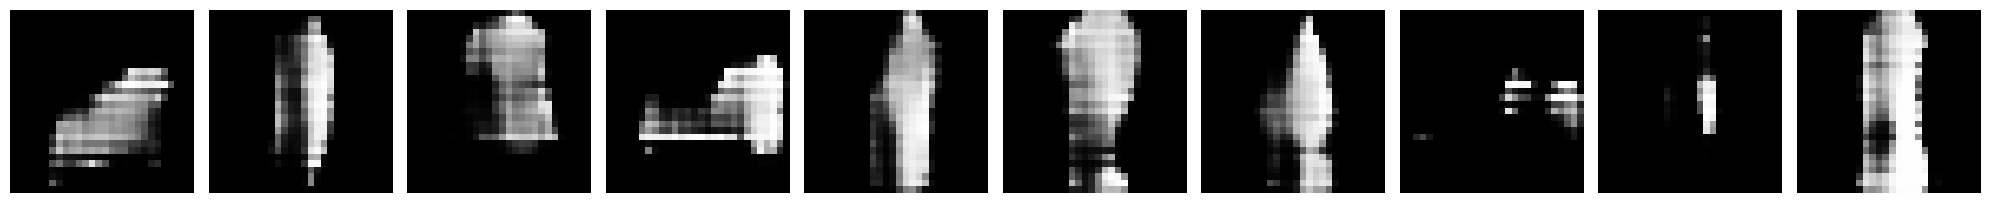

547/547 - 23s - loss: 1.4363 - d_loss: 0.6567 - g_loss: 0.7797 - 23s/epoch - 42ms/step
Epoch 22/100


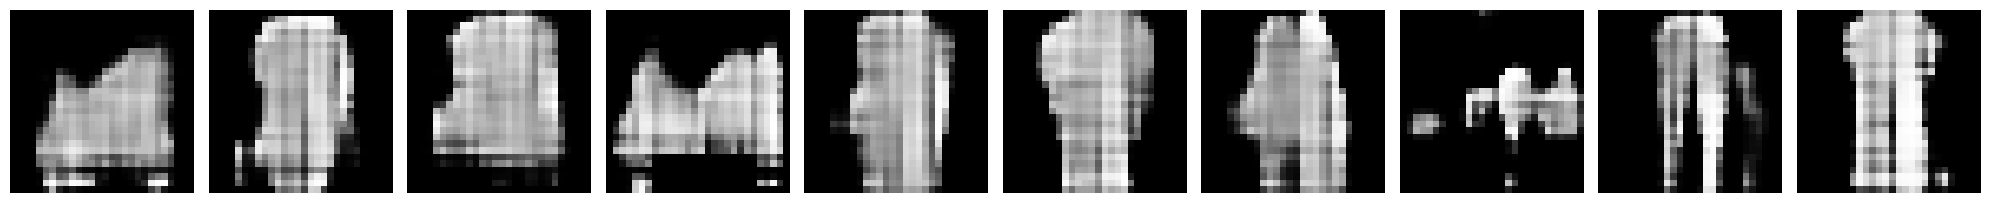

547/547 - 23s - loss: 1.4239 - d_loss: 0.6733 - g_loss: 0.7506 - 23s/epoch - 42ms/step
Epoch 23/100


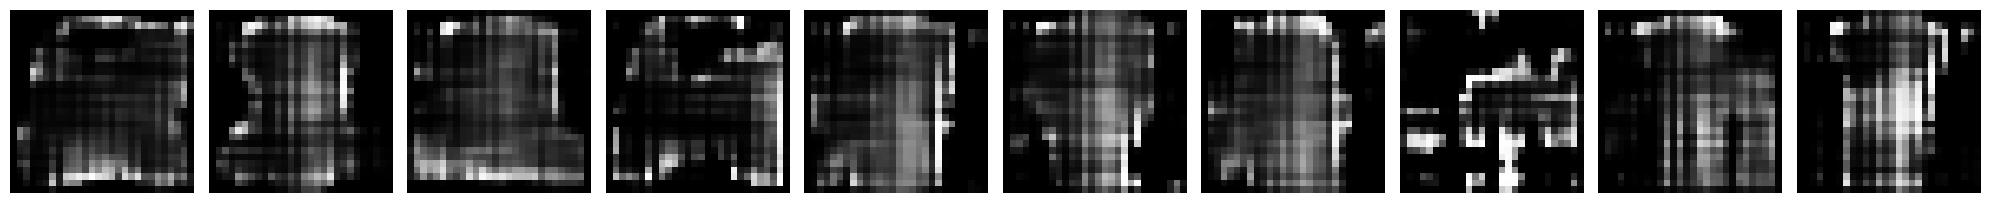

547/547 - 23s - loss: 1.4279 - d_loss: 0.6605 - g_loss: 0.7674 - 23s/epoch - 42ms/step
Epoch 24/100


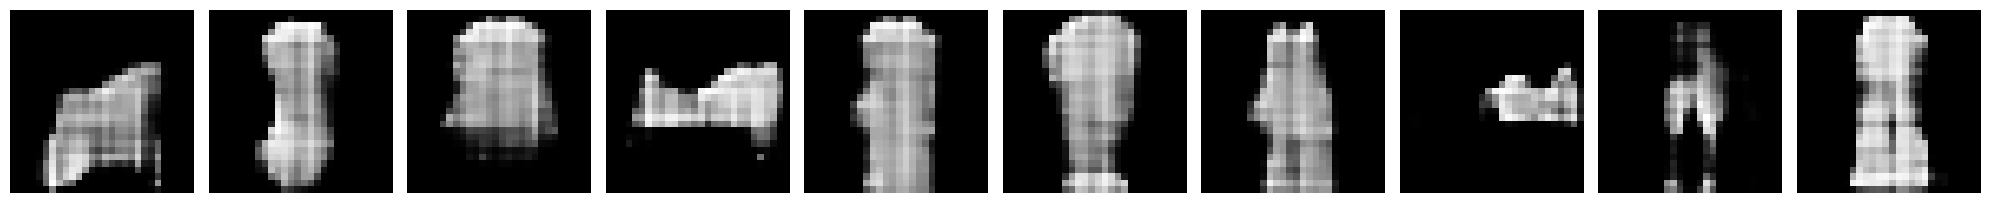

547/547 - 23s - loss: 1.4472 - d_loss: 0.6629 - g_loss: 0.7843 - 23s/epoch - 42ms/step
Epoch 25/100


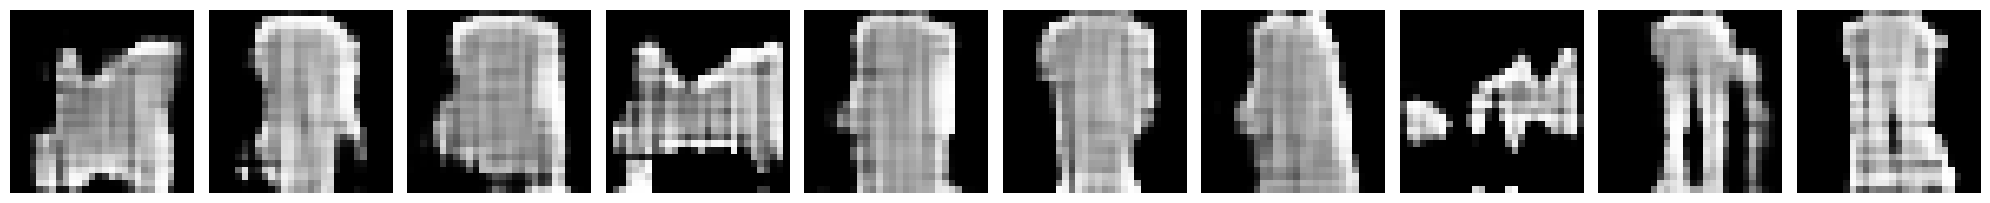

547/547 - 23s - loss: 1.4405 - d_loss: 0.6522 - g_loss: 0.7883 - 23s/epoch - 42ms/step
Epoch 26/100


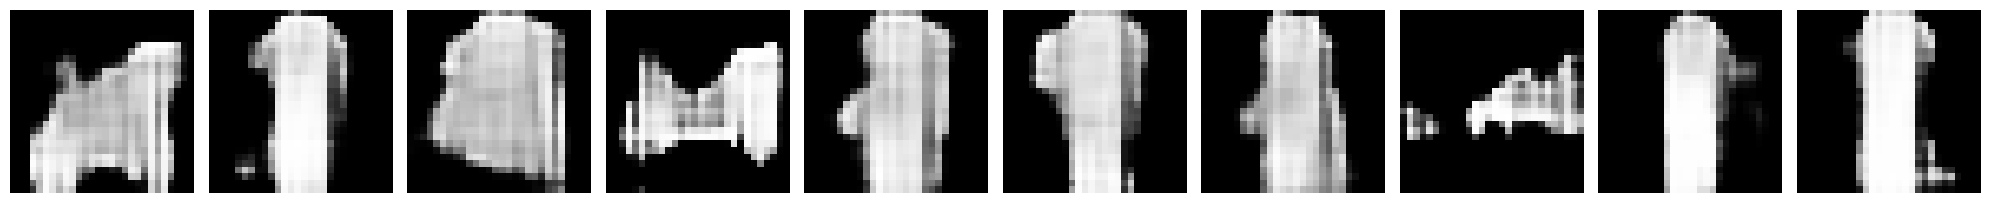

547/547 - 23s - loss: 1.4429 - d_loss: 0.6441 - g_loss: 0.7988 - 23s/epoch - 42ms/step
Epoch 27/100


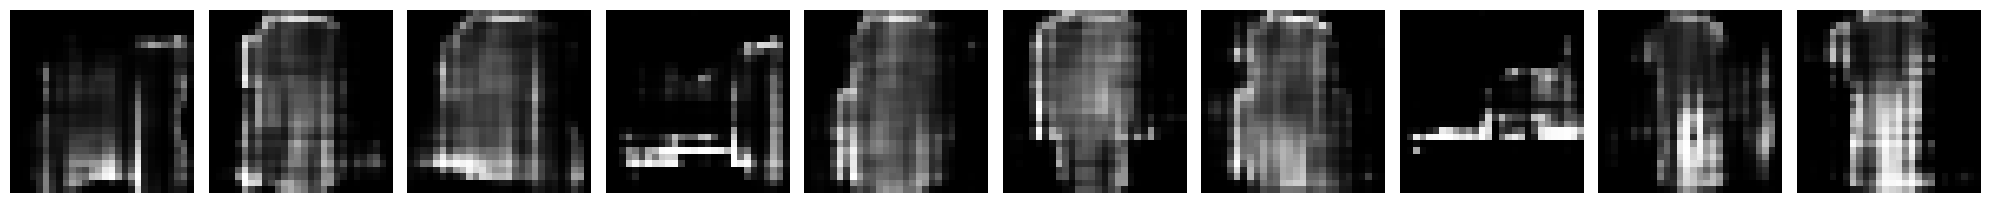

547/547 - 23s - loss: 1.5122 - d_loss: 0.6309 - g_loss: 0.8812 - 23s/epoch - 42ms/step
Epoch 28/100


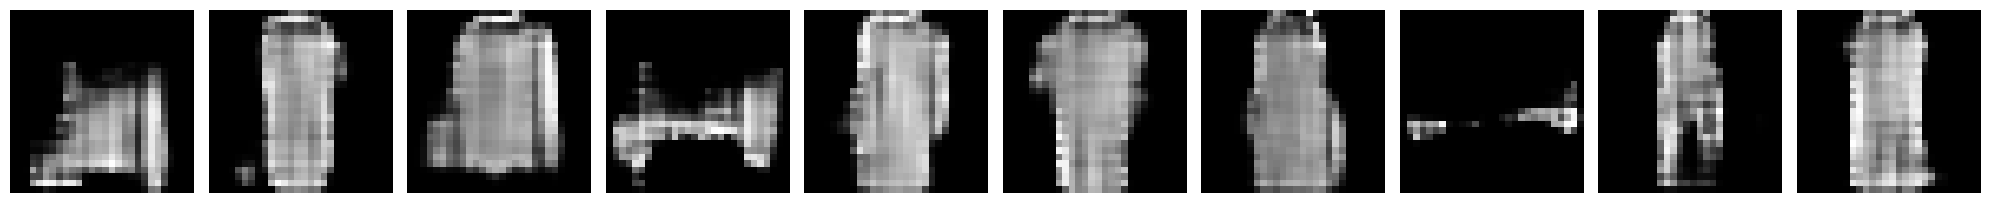

547/547 - 23s - loss: 1.4289 - d_loss: 0.6507 - g_loss: 0.7781 - 23s/epoch - 42ms/step
Epoch 29/100


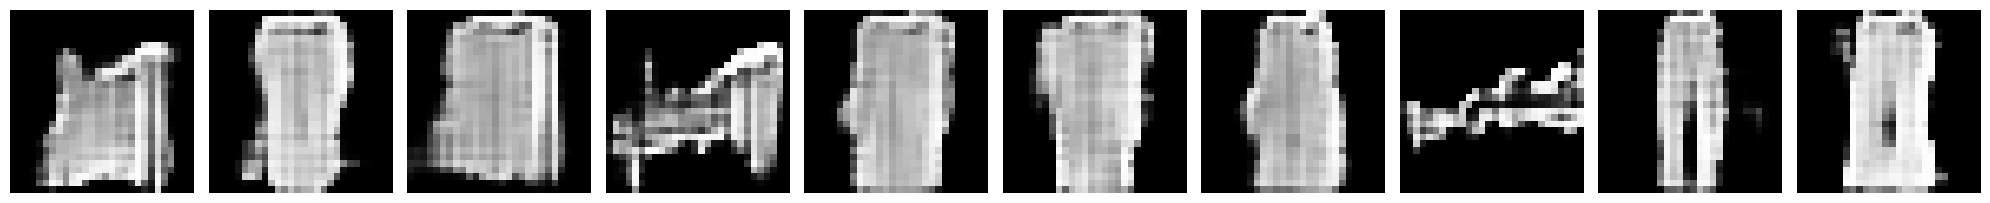

547/547 - 23s - loss: 1.4587 - d_loss: 0.6446 - g_loss: 0.8142 - 23s/epoch - 42ms/step
Epoch 30/100


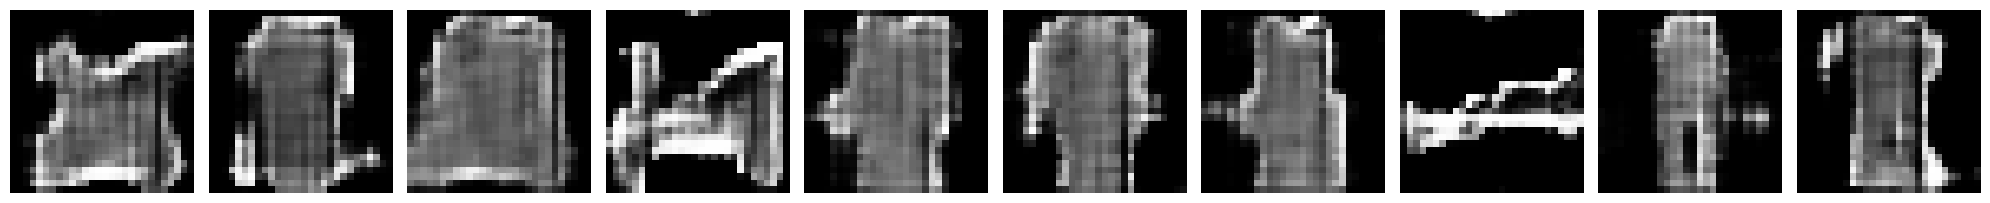

547/547 - 23s - loss: 1.4458 - d_loss: 0.6364 - g_loss: 0.8095 - 23s/epoch - 42ms/step
Epoch 31/100


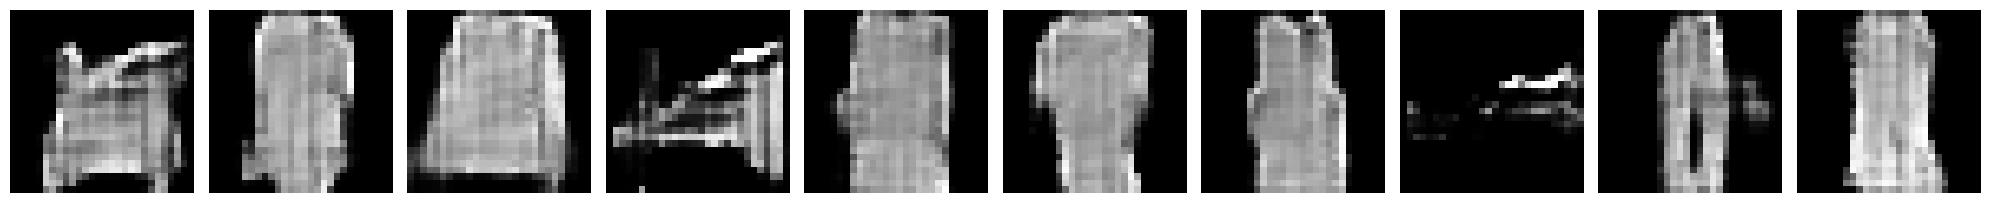

547/547 - 23s - loss: 1.4810 - d_loss: 0.6448 - g_loss: 0.8362 - 23s/epoch - 42ms/step
Epoch 32/100


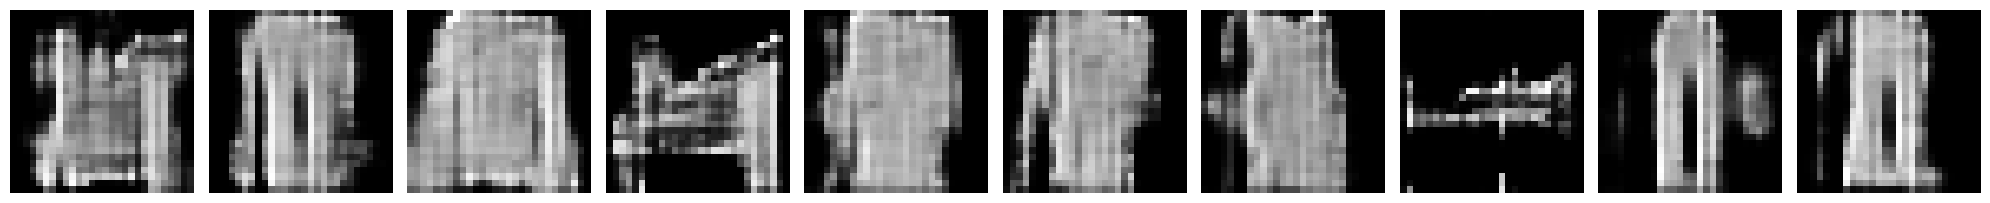

547/547 - 23s - loss: 1.5044 - d_loss: 0.6175 - g_loss: 0.8869 - 23s/epoch - 42ms/step
Epoch 33/100


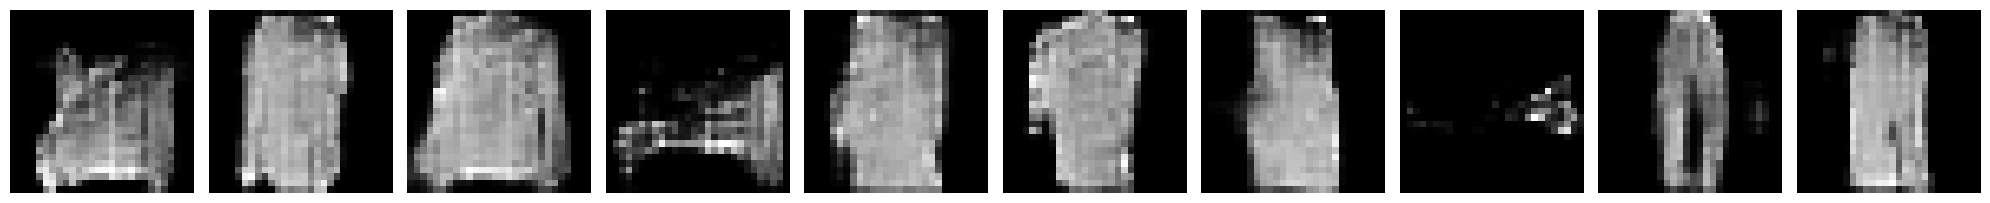

547/547 - 23s - loss: 1.4807 - d_loss: 0.6379 - g_loss: 0.8428 - 23s/epoch - 42ms/step
Epoch 34/100


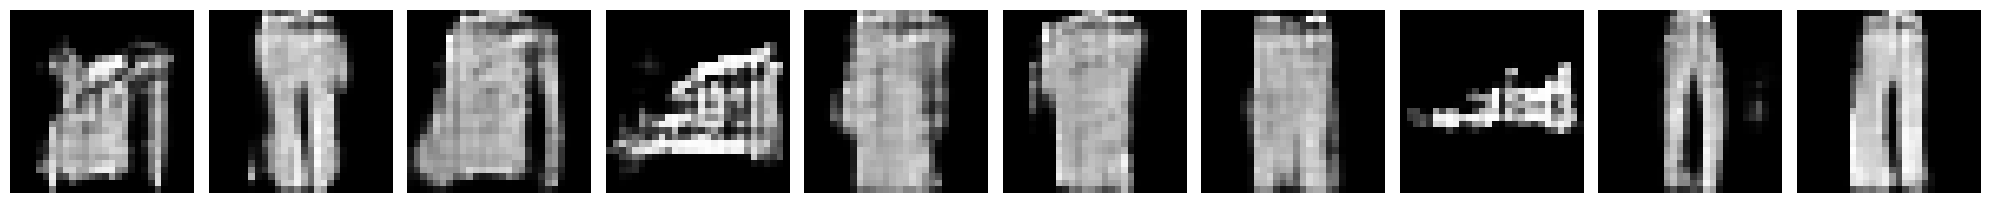

547/547 - 23s - loss: 1.4529 - d_loss: 0.6353 - g_loss: 0.8176 - 23s/epoch - 42ms/step
Epoch 35/100


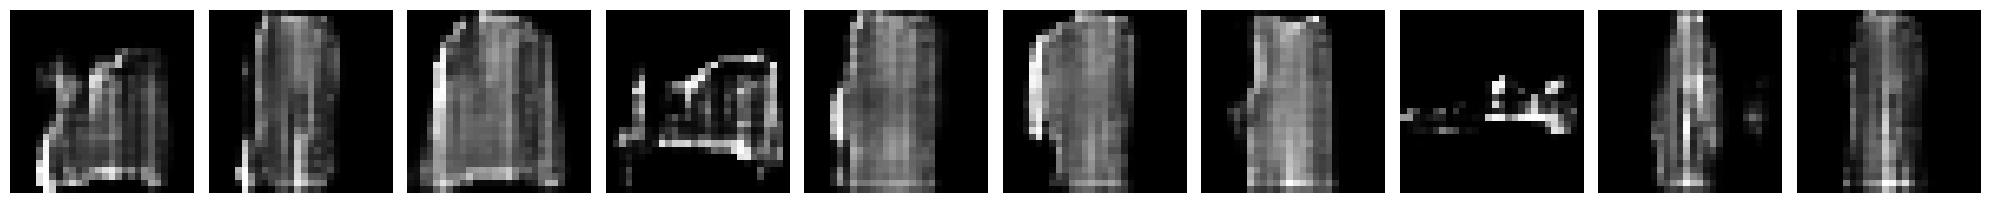

547/547 - 23s - loss: 1.5017 - d_loss: 0.6224 - g_loss: 0.8793 - 23s/epoch - 42ms/step
Epoch 36/100


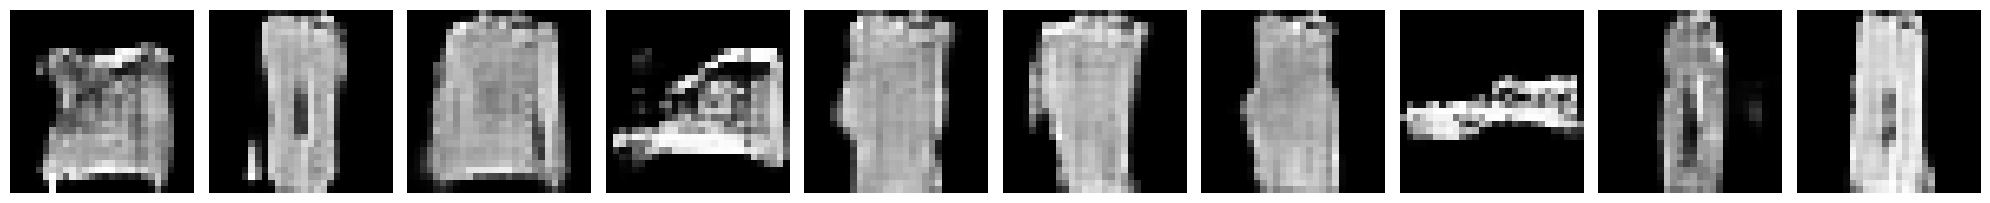

547/547 - 23s - loss: 1.4689 - d_loss: 0.6355 - g_loss: 0.8334 - 23s/epoch - 42ms/step
Epoch 37/100


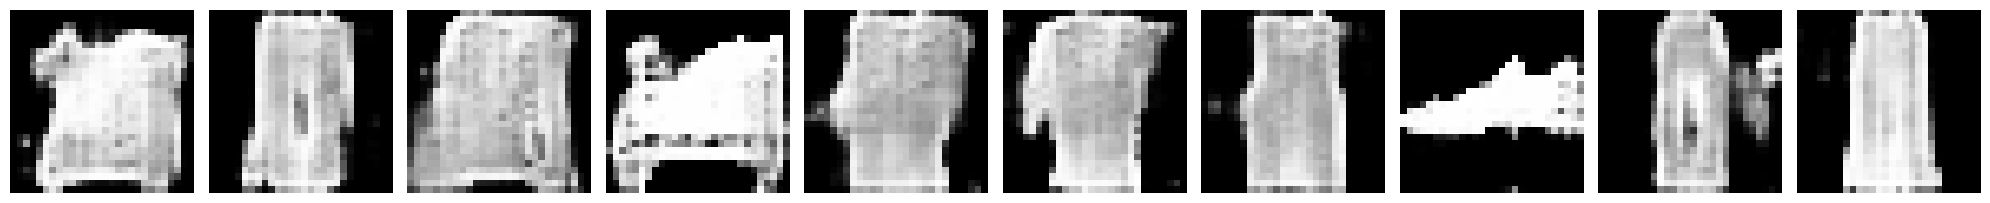

547/547 - 23s - loss: 1.4929 - d_loss: 0.6349 - g_loss: 0.8580 - 23s/epoch - 42ms/step
Epoch 38/100


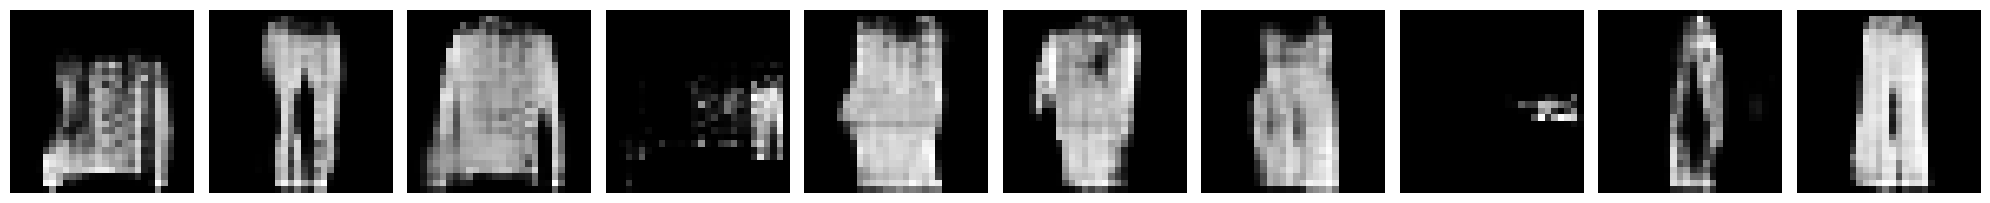

547/547 - 23s - loss: 1.5027 - d_loss: 0.6269 - g_loss: 0.8758 - 23s/epoch - 42ms/step
Epoch 39/100


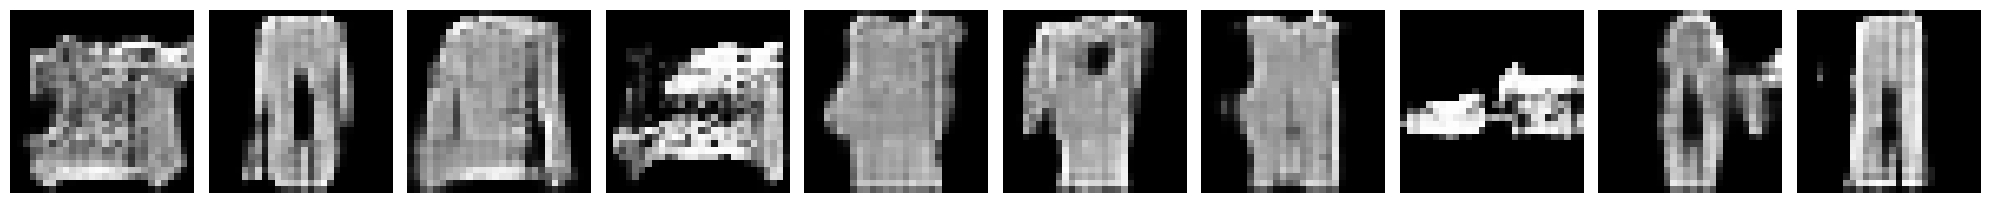

547/547 - 23s - loss: 1.4570 - d_loss: 0.6197 - g_loss: 0.8373 - 23s/epoch - 42ms/step
Epoch 40/100


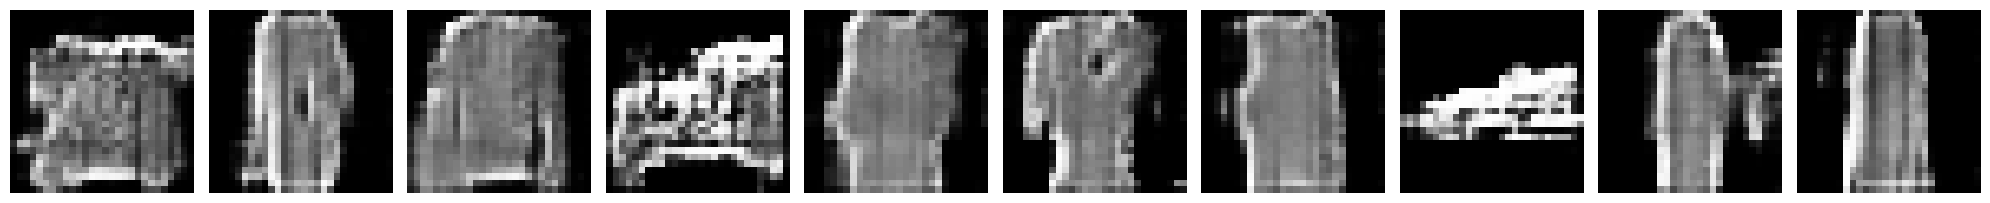

547/547 - 23s - loss: 1.5109 - d_loss: 0.6136 - g_loss: 0.8973 - 23s/epoch - 42ms/step
Epoch 41/100


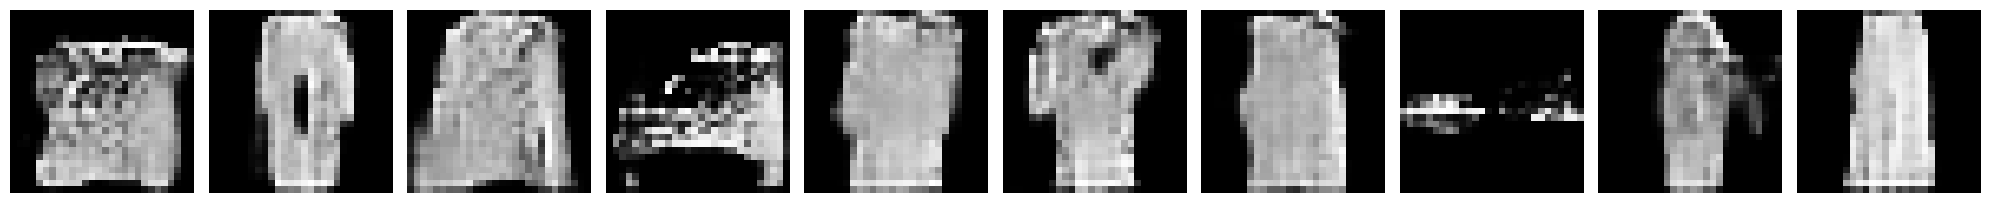

547/547 - 23s - loss: 1.4826 - d_loss: 0.6226 - g_loss: 0.8601 - 23s/epoch - 42ms/step
Epoch 42/100


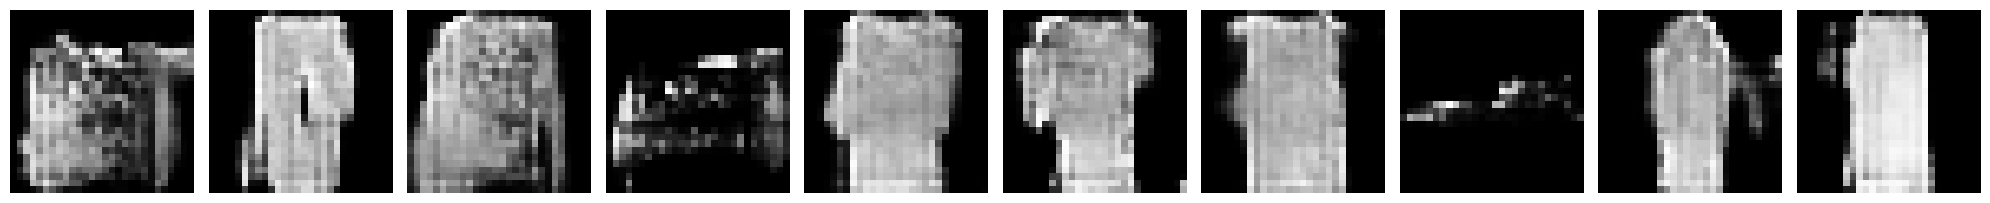

547/547 - 23s - loss: 1.4689 - d_loss: 0.6278 - g_loss: 0.8411 - 23s/epoch - 42ms/step
Epoch 43/100


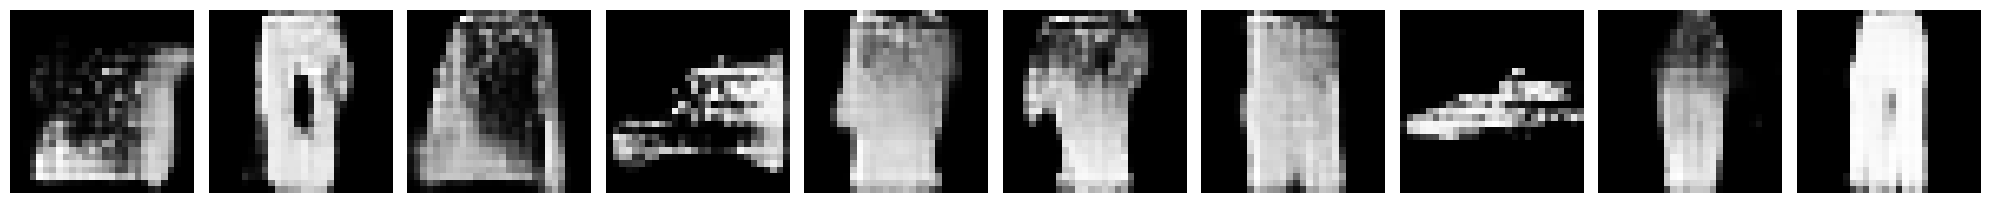

547/547 - 23s - loss: 1.4709 - d_loss: 0.6233 - g_loss: 0.8477 - 23s/epoch - 42ms/step
Epoch 44/100


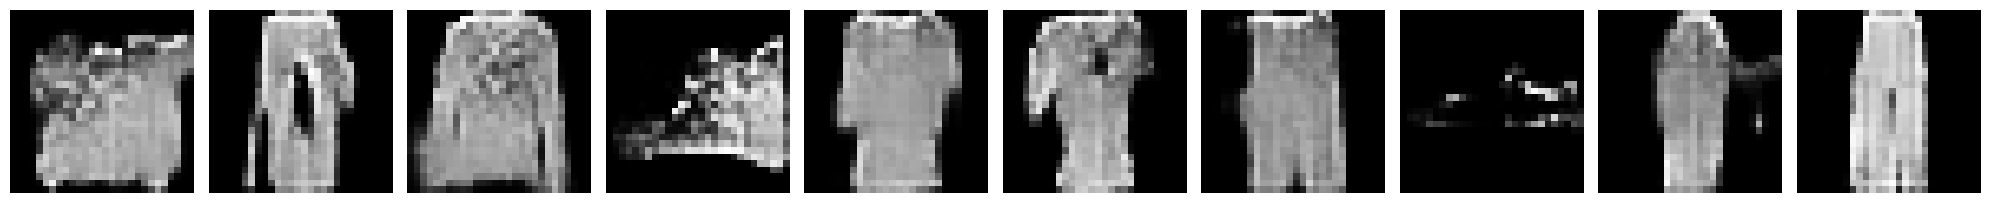

547/547 - 23s - loss: 1.4905 - d_loss: 0.6268 - g_loss: 0.8637 - 23s/epoch - 42ms/step
Epoch 45/100


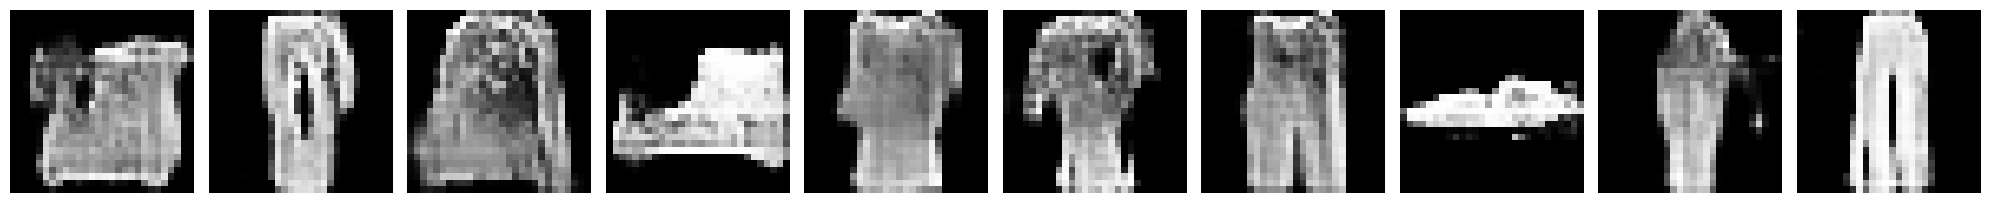

547/547 - 23s - loss: 1.4406 - d_loss: 0.6412 - g_loss: 0.7994 - 23s/epoch - 42ms/step
Epoch 46/100


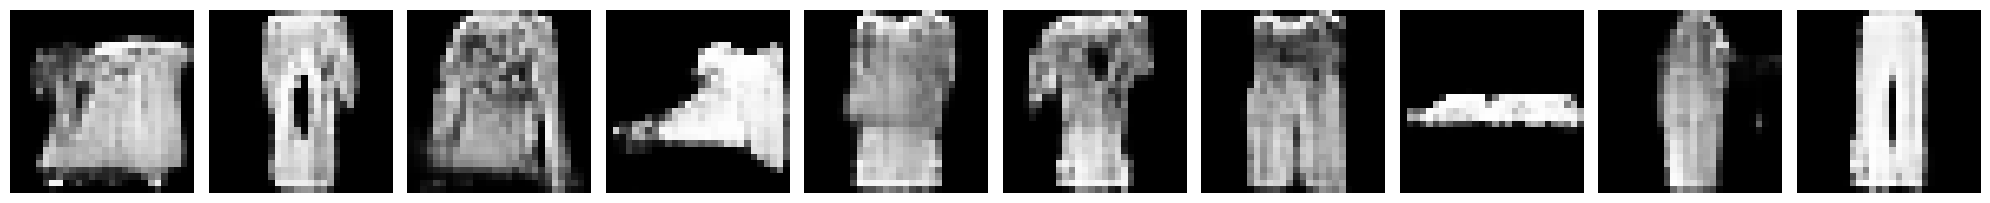

547/547 - 23s - loss: 1.5092 - d_loss: 0.6322 - g_loss: 0.8771 - 23s/epoch - 42ms/step
Epoch 47/100


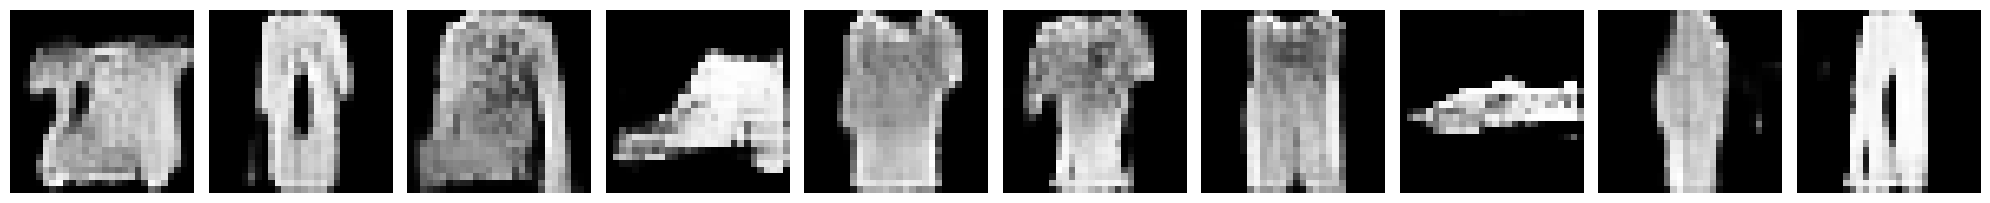

547/547 - 23s - loss: 1.4479 - d_loss: 0.6412 - g_loss: 0.8067 - 23s/epoch - 42ms/step
Epoch 48/100


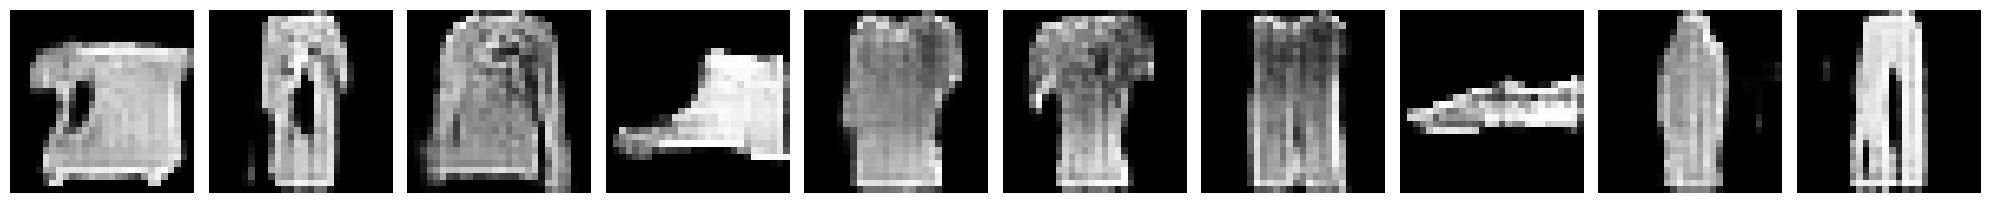

547/547 - 23s - loss: 1.4425 - d_loss: 0.6469 - g_loss: 0.7955 - 23s/epoch - 42ms/step
Epoch 49/100


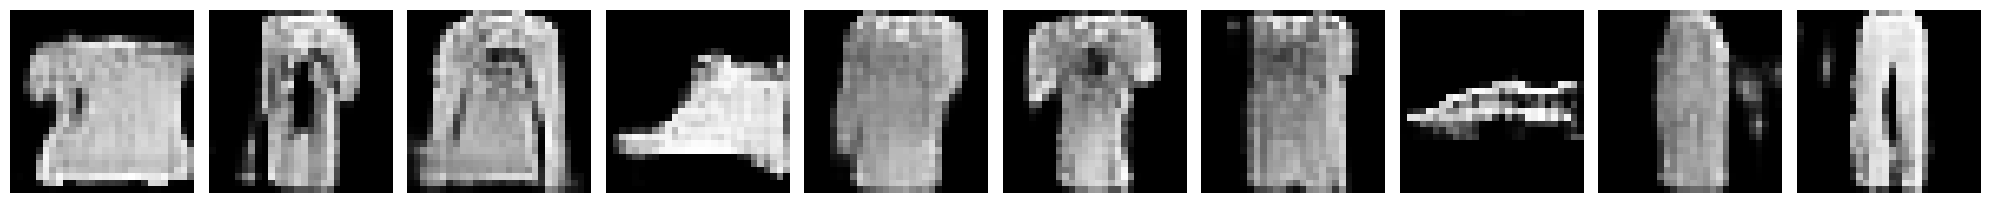

547/547 - 23s - loss: 1.5056 - d_loss: 0.6357 - g_loss: 0.8699 - 23s/epoch - 42ms/step
Epoch 50/100


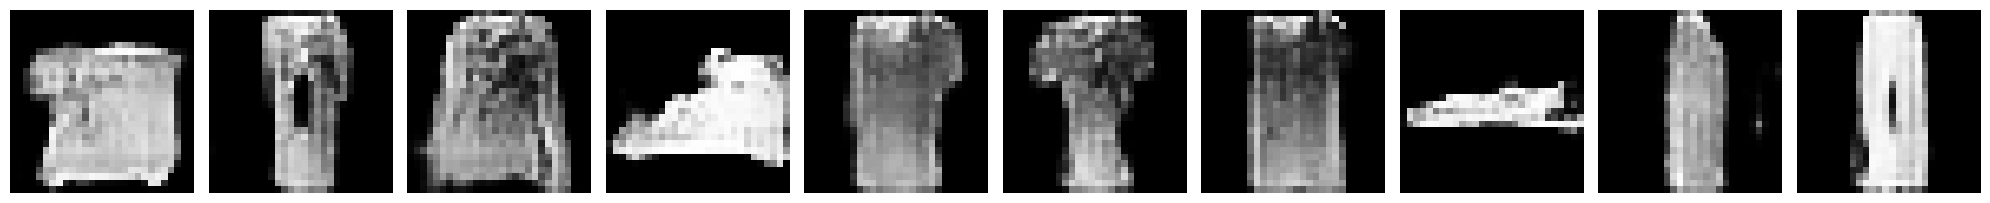

547/547 - 23s - loss: 1.4633 - d_loss: 0.6441 - g_loss: 0.8191 - 23s/epoch - 42ms/step
Epoch 51/100


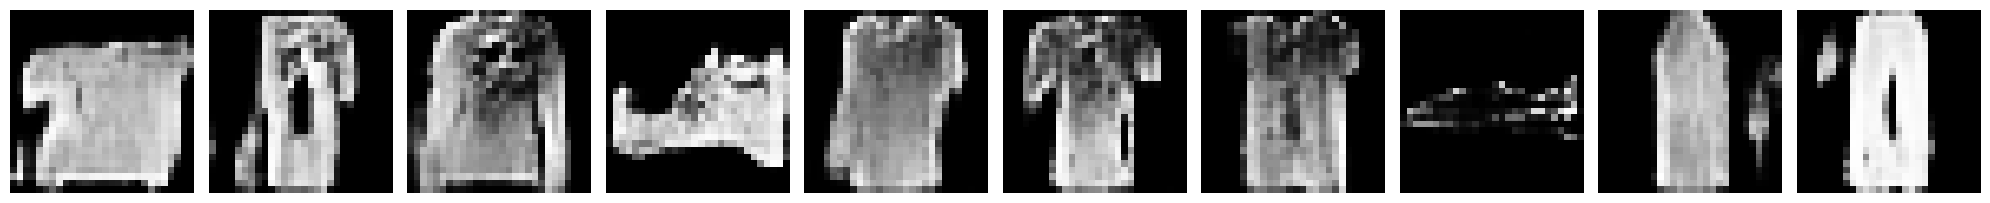

547/547 - 23s - loss: 1.4314 - d_loss: 0.6447 - g_loss: 0.7868 - 23s/epoch - 43ms/step
Epoch 52/100


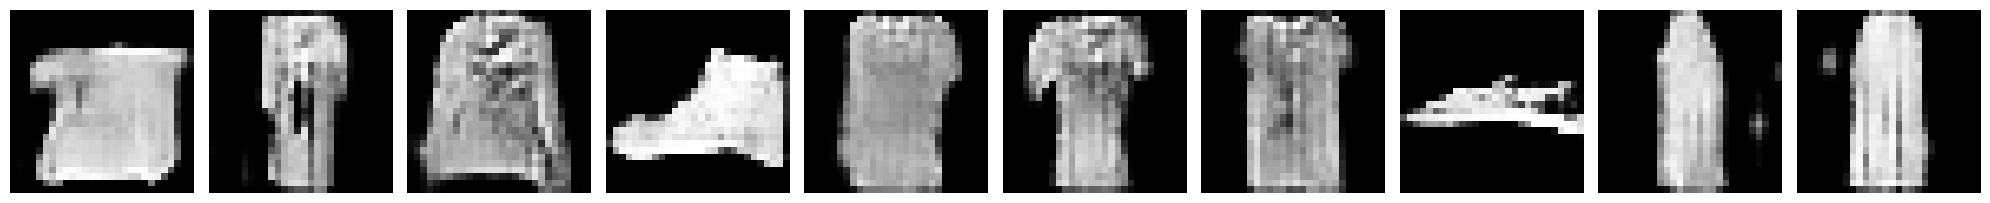

547/547 - 23s - loss: 1.4490 - d_loss: 0.6437 - g_loss: 0.8053 - 23s/epoch - 42ms/step
Epoch 53/100


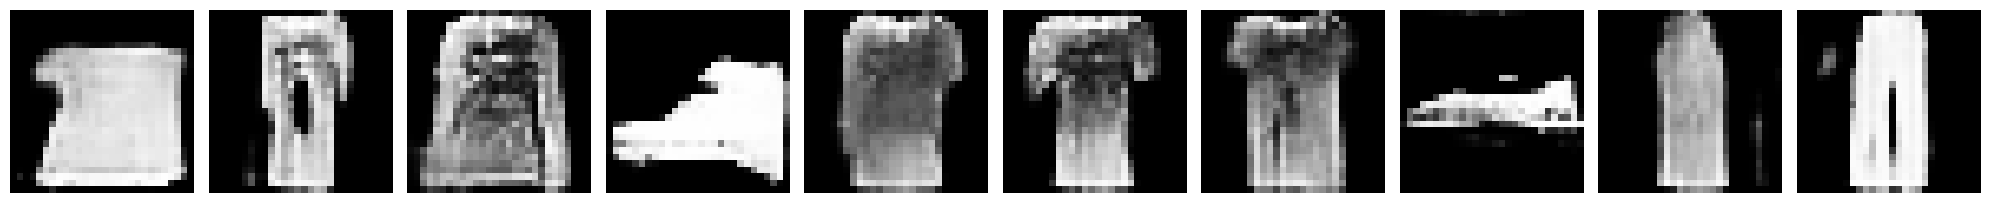

547/547 - 24s - loss: 1.4700 - d_loss: 0.6421 - g_loss: 0.8279 - 24s/epoch - 43ms/step
Epoch 54/100


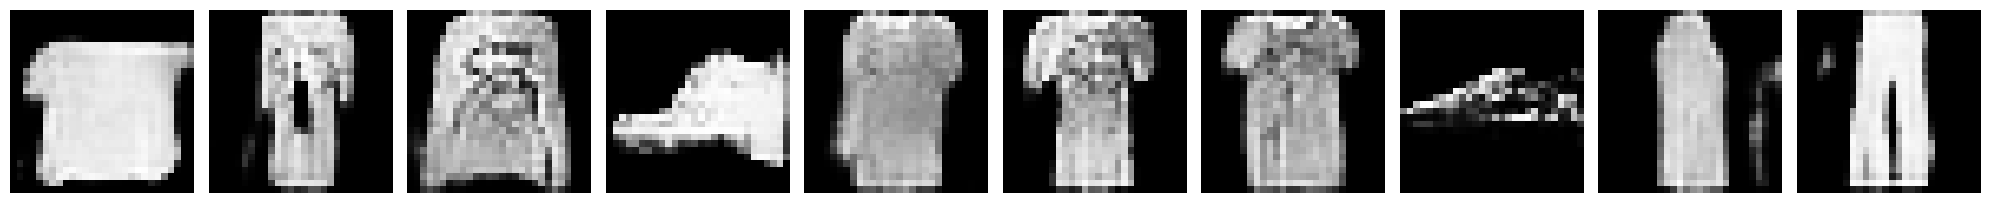

547/547 - 23s - loss: 1.4918 - d_loss: 0.6386 - g_loss: 0.8532 - 23s/epoch - 42ms/step
Epoch 55/100


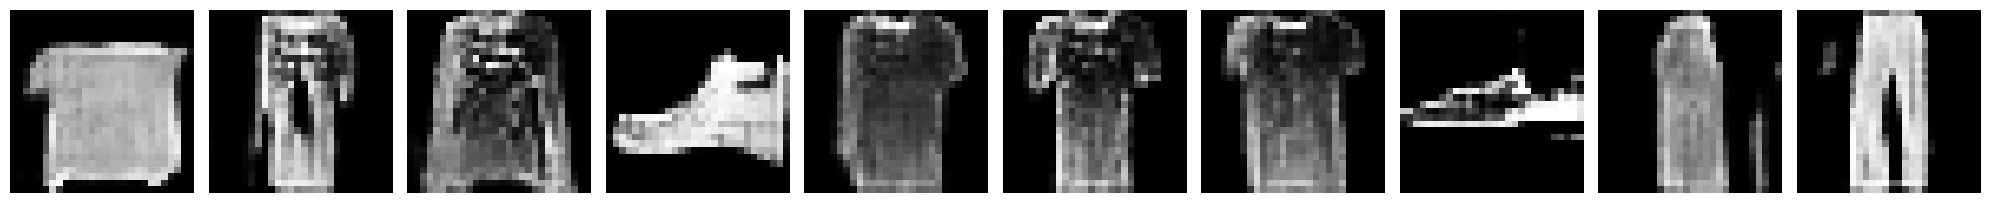

547/547 - 23s - loss: 1.4454 - d_loss: 0.6437 - g_loss: 0.8017 - 23s/epoch - 42ms/step
Epoch 56/100


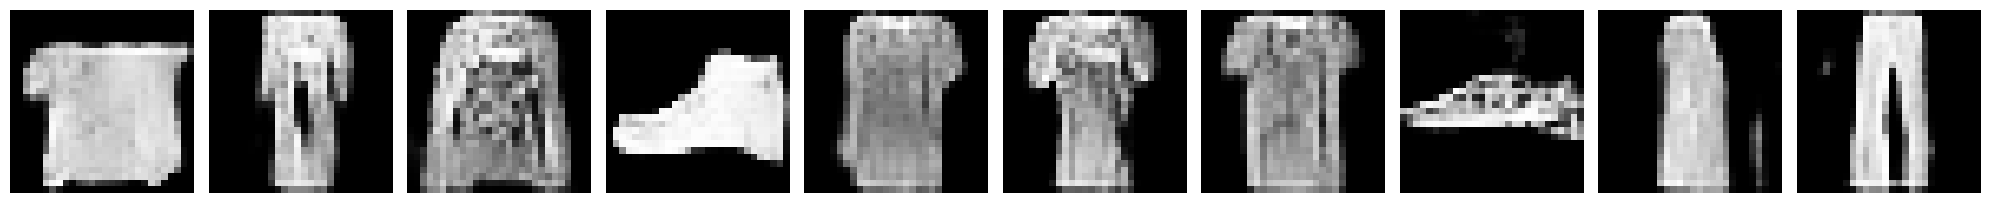

547/547 - 23s - loss: 1.4488 - d_loss: 0.6432 - g_loss: 0.8056 - 23s/epoch - 42ms/step
Epoch 57/100


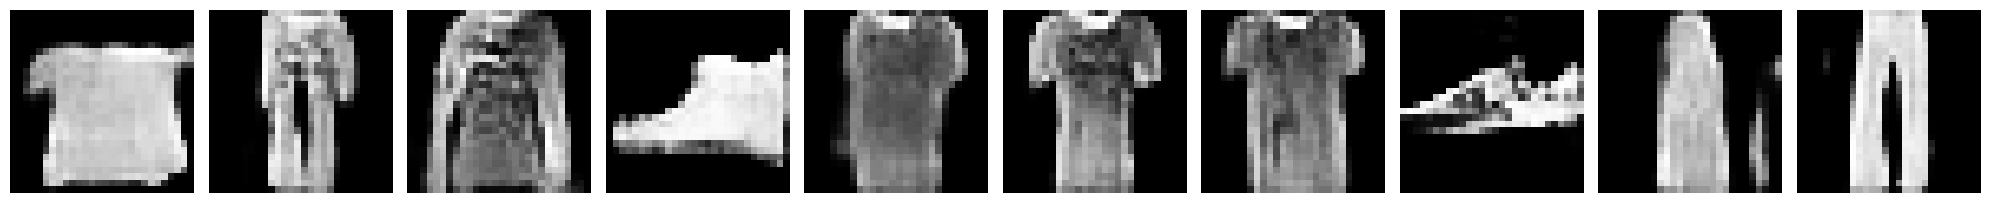

547/547 - 23s - loss: 1.4471 - d_loss: 0.6489 - g_loss: 0.7982 - 23s/epoch - 42ms/step
Epoch 58/100


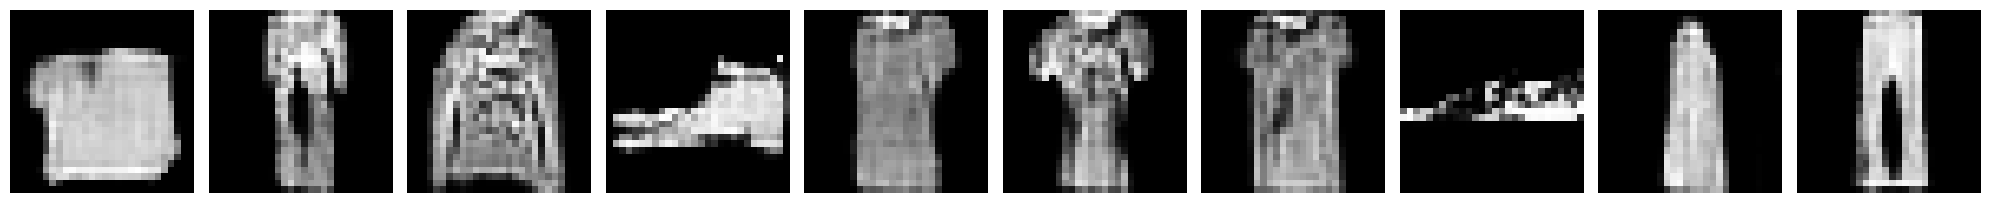

547/547 - 23s - loss: 1.4847 - d_loss: 0.6371 - g_loss: 0.8476 - 23s/epoch - 42ms/step
Epoch 59/100


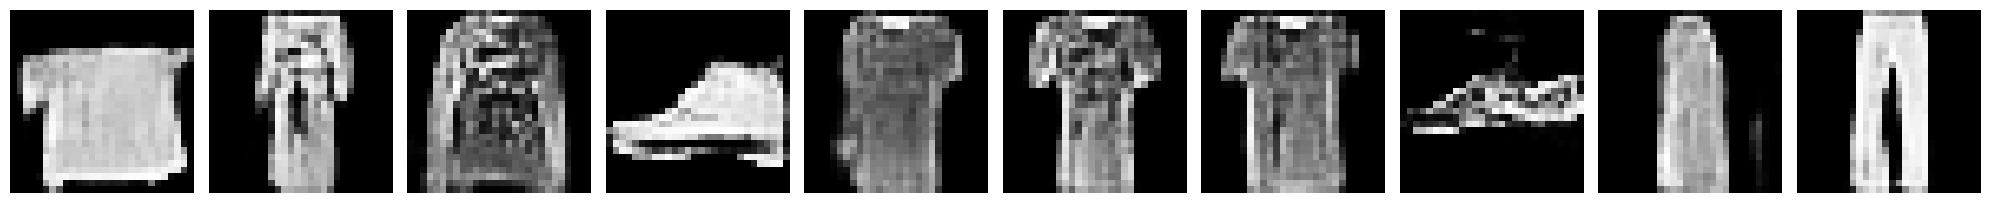

547/547 - 23s - loss: 1.4368 - d_loss: 0.6487 - g_loss: 0.7881 - 23s/epoch - 43ms/step
Epoch 60/100


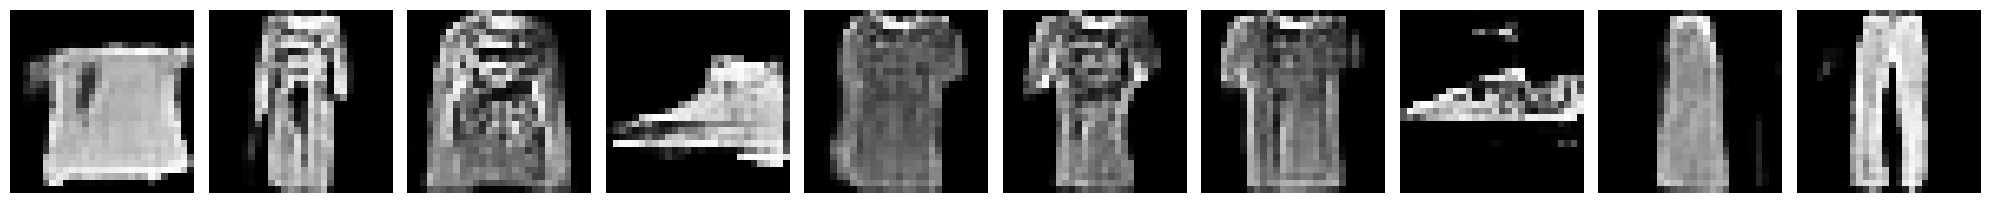

547/547 - 23s - loss: 1.4661 - d_loss: 0.6456 - g_loss: 0.8206 - 23s/epoch - 42ms/step
Epoch 61/100


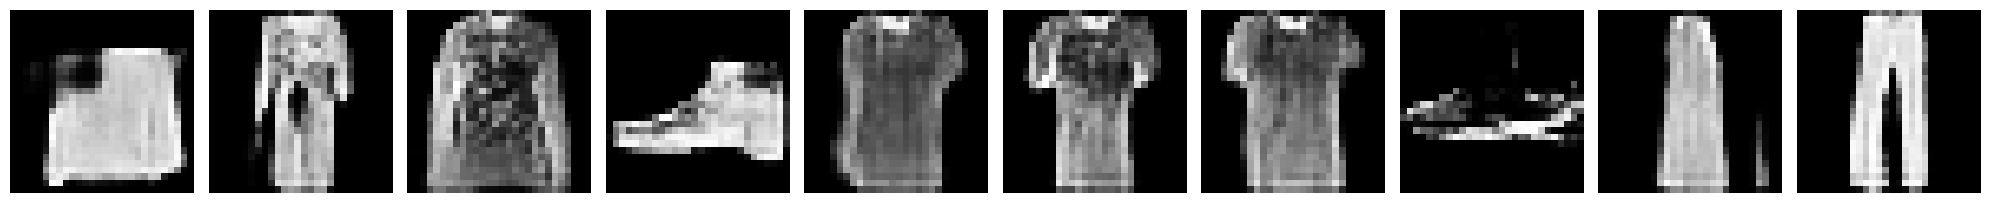

547/547 - 23s - loss: 1.4390 - d_loss: 0.6457 - g_loss: 0.7933 - 23s/epoch - 42ms/step
Epoch 62/100


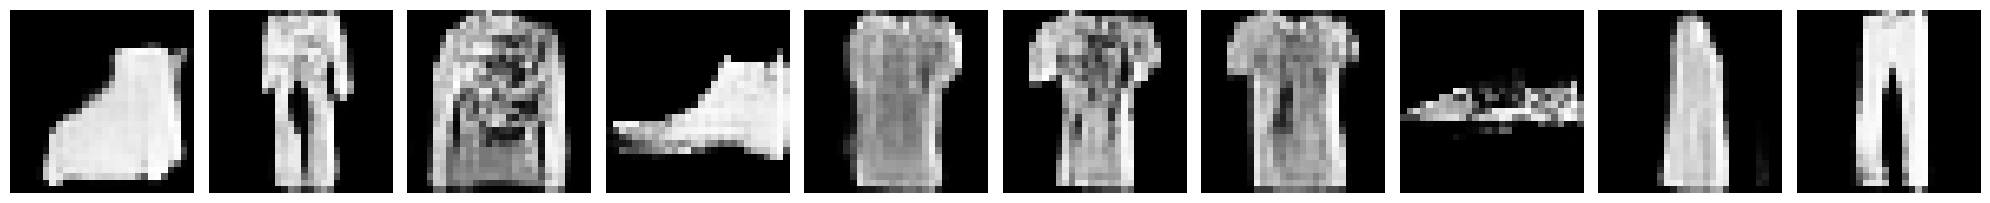

547/547 - 23s - loss: 1.4728 - d_loss: 0.6377 - g_loss: 0.8351 - 23s/epoch - 42ms/step
Epoch 63/100


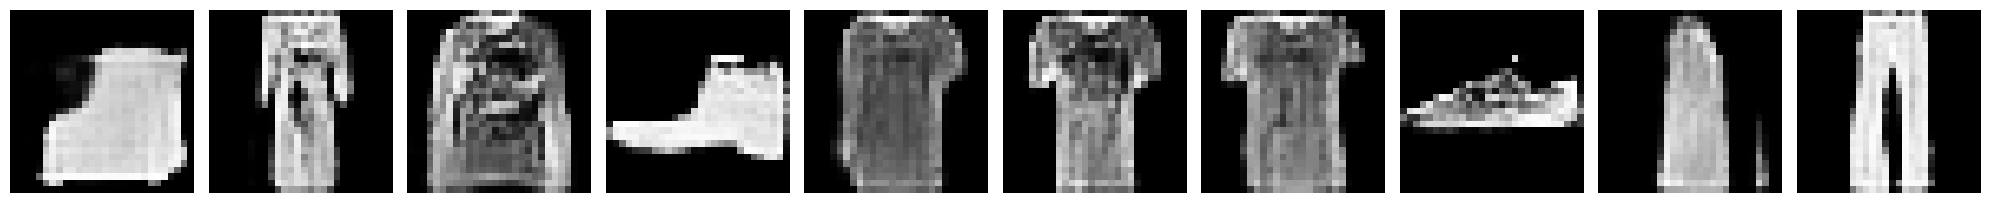

547/547 - 23s - loss: 1.4500 - d_loss: 0.6456 - g_loss: 0.8044 - 23s/epoch - 42ms/step
Epoch 64/100


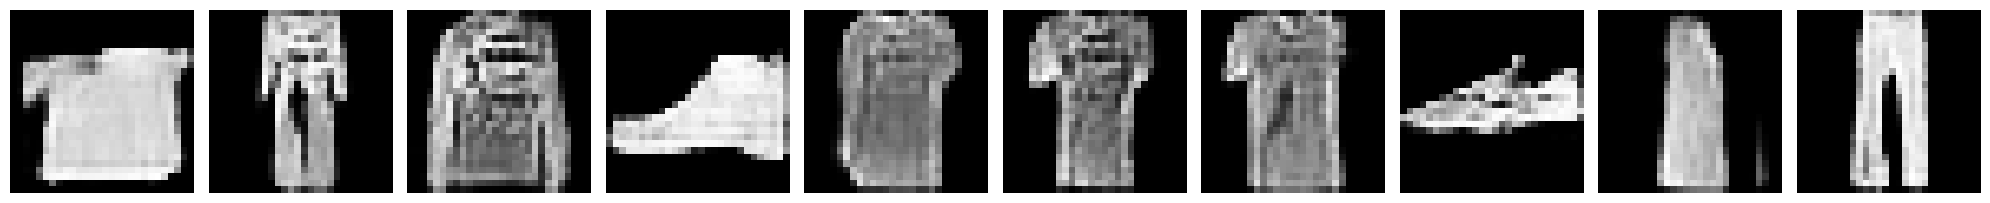

547/547 - 23s - loss: 1.4393 - d_loss: 0.6415 - g_loss: 0.7978 - 23s/epoch - 42ms/step
Epoch 65/100


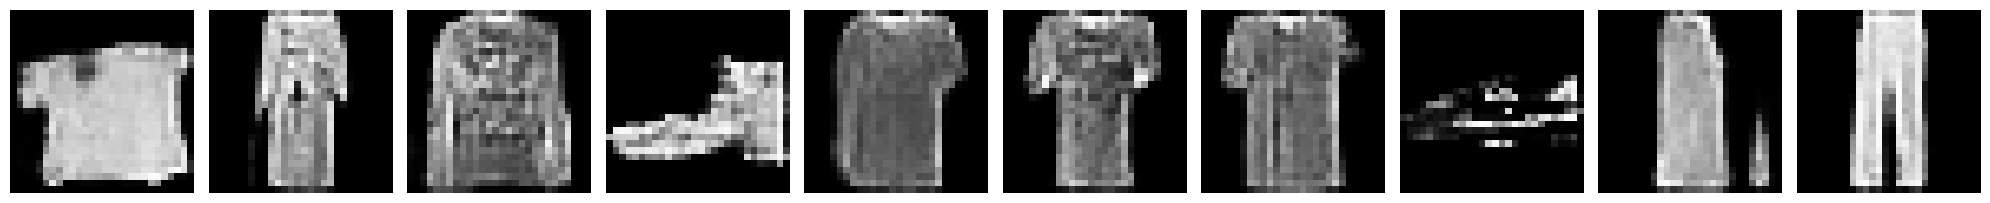

547/547 - 23s - loss: 1.5069 - d_loss: 0.6362 - g_loss: 0.8706 - 23s/epoch - 42ms/step
Epoch 66/100


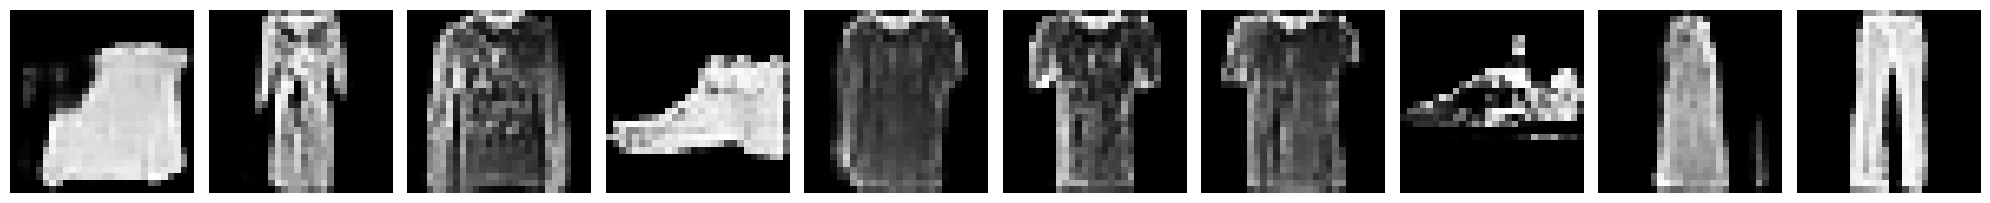

547/547 - 23s - loss: 1.4410 - d_loss: 0.6429 - g_loss: 0.7981 - 23s/epoch - 42ms/step
Epoch 67/100


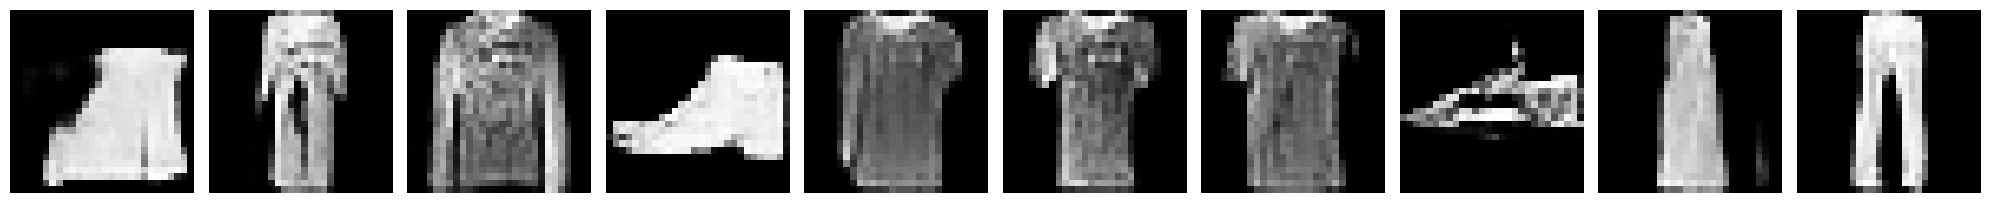

547/547 - 23s - loss: 1.4326 - d_loss: 0.6429 - g_loss: 0.7897 - 23s/epoch - 43ms/step
Epoch 68/100


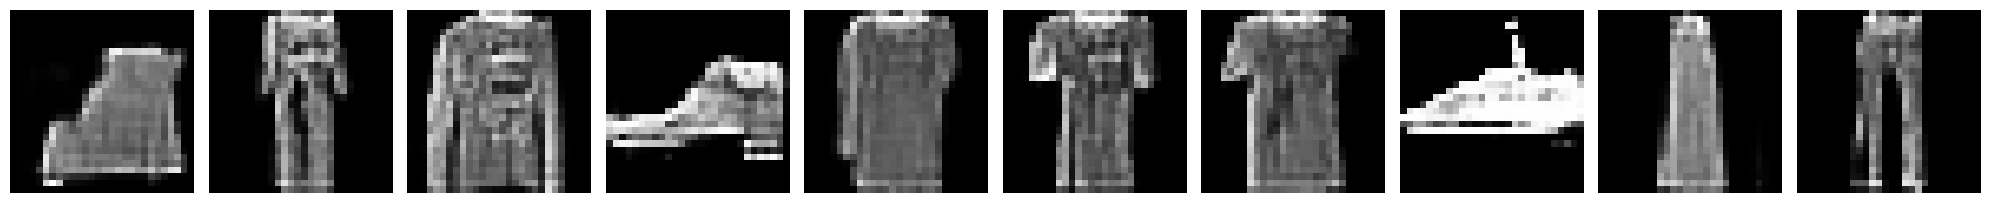

547/547 - 23s - loss: 1.5267 - d_loss: 0.6370 - g_loss: 0.8897 - 23s/epoch - 43ms/step
Epoch 69/100


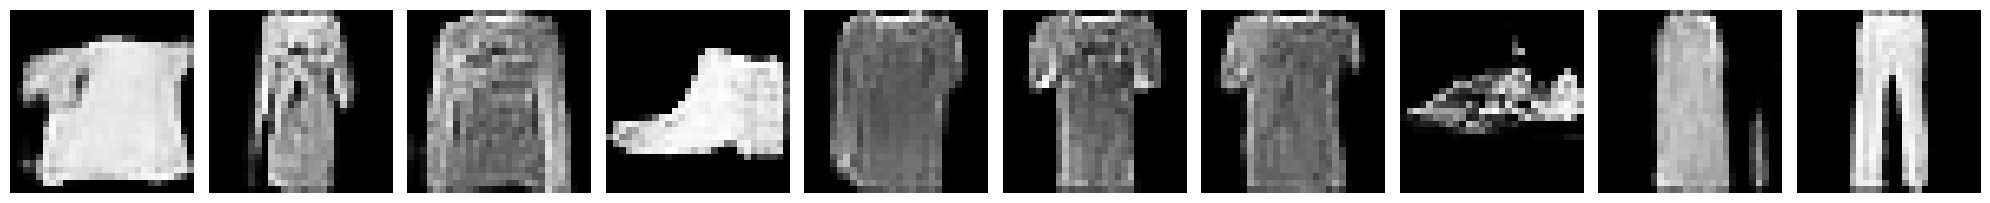

547/547 - 23s - loss: 1.4575 - d_loss: 0.6351 - g_loss: 0.8224 - 23s/epoch - 42ms/step
Epoch 70/100


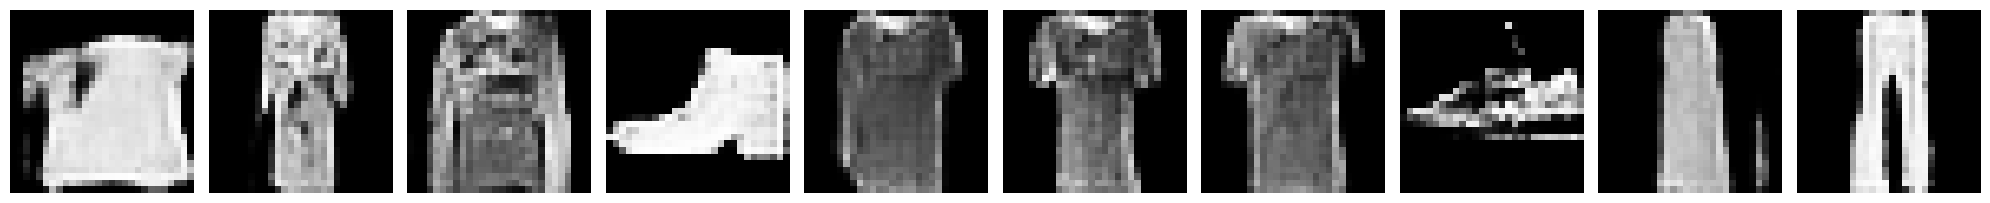

547/547 - 23s - loss: 1.4298 - d_loss: 0.6404 - g_loss: 0.7894 - 23s/epoch - 42ms/step
Epoch 71/100


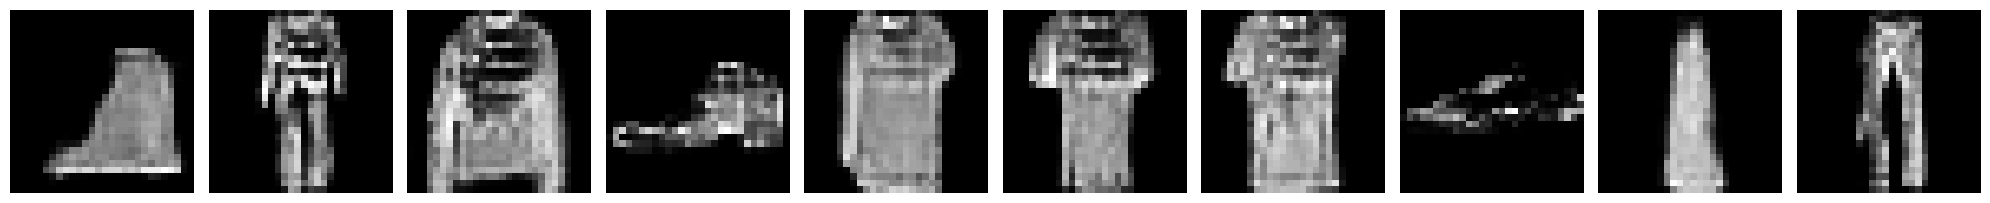

547/547 - 23s - loss: 1.4981 - d_loss: 0.6376 - g_loss: 0.8606 - 23s/epoch - 42ms/step
Epoch 72/100


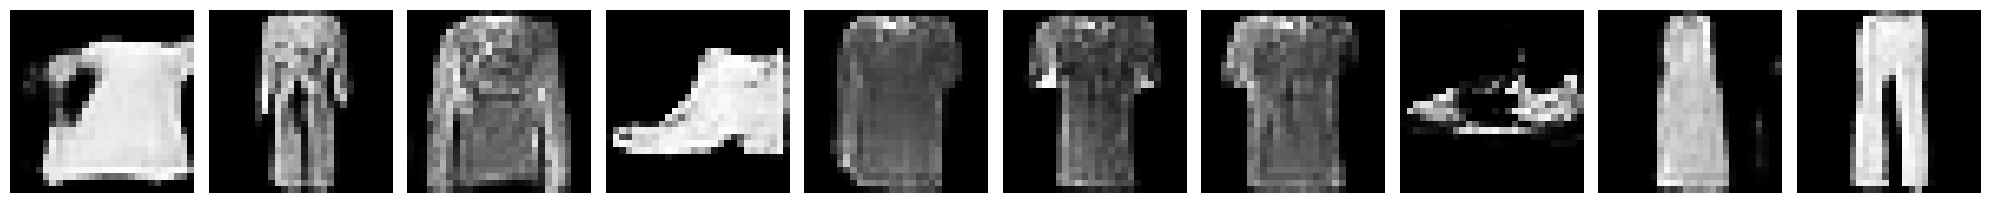

547/547 - 23s - loss: 1.4818 - d_loss: 0.6336 - g_loss: 0.8482 - 23s/epoch - 42ms/step
Epoch 73/100


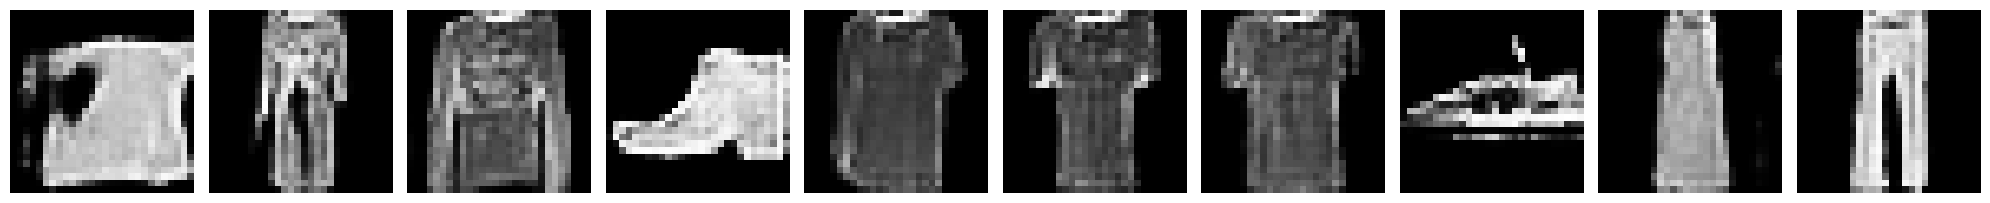

547/547 - 23s - loss: 1.4261 - d_loss: 0.6426 - g_loss: 0.7836 - 23s/epoch - 42ms/step
Epoch 74/100


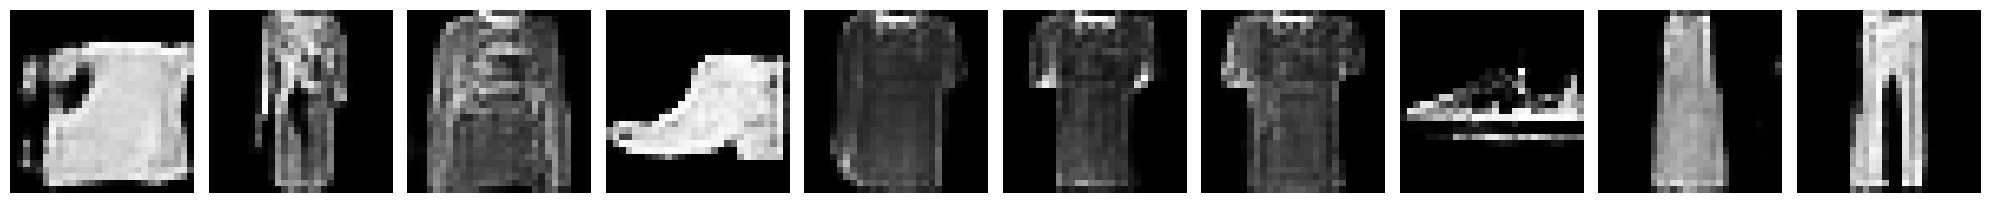

547/547 - 23s - loss: 1.4258 - d_loss: 0.6459 - g_loss: 0.7799 - 23s/epoch - 42ms/step
Epoch 75/100


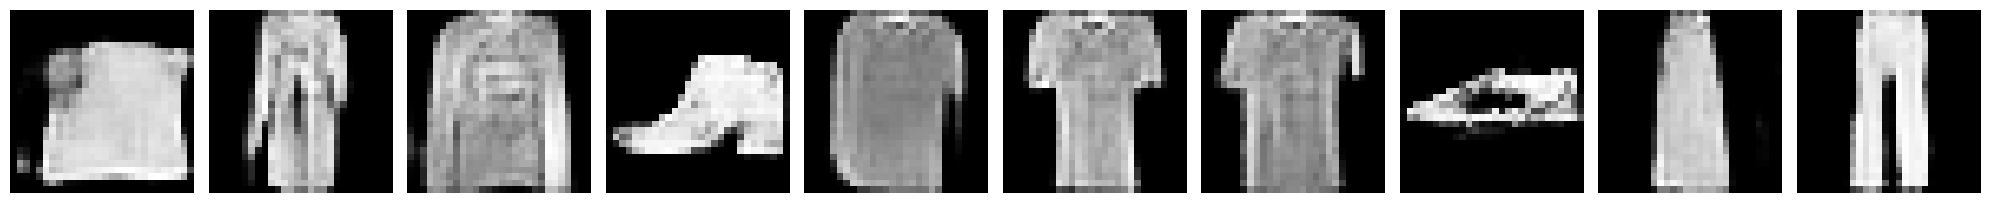

547/547 - 23s - loss: 1.5150 - d_loss: 0.6357 - g_loss: 0.8792 - 23s/epoch - 43ms/step
Epoch 76/100


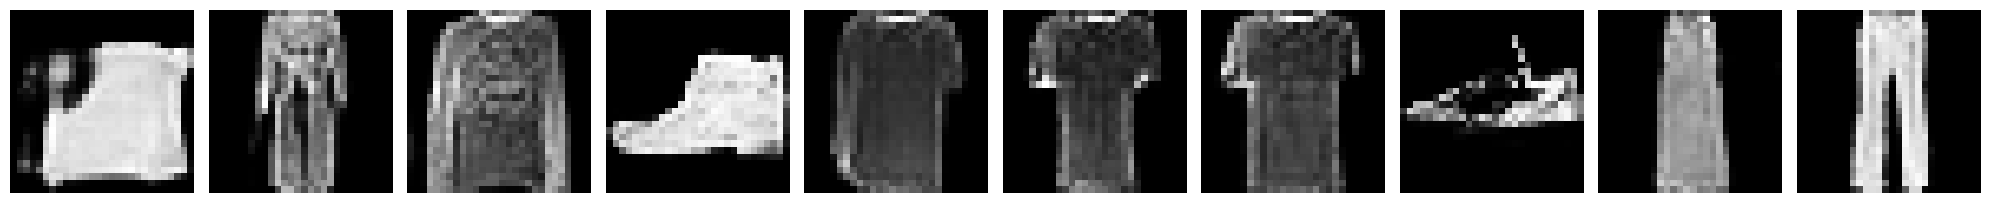

547/547 - 23s - loss: 1.4650 - d_loss: 0.6308 - g_loss: 0.8342 - 23s/epoch - 42ms/step
Epoch 77/100


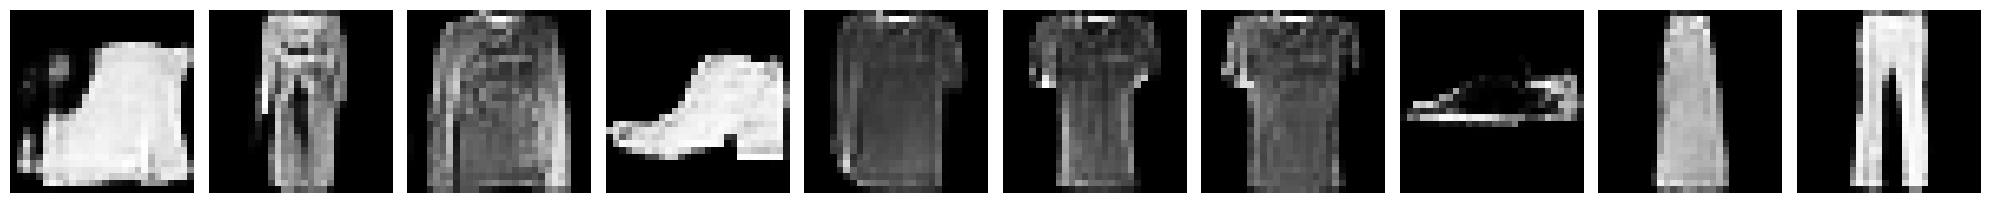

547/547 - 23s - loss: 1.4231 - d_loss: 0.6464 - g_loss: 0.7767 - 23s/epoch - 42ms/step
Epoch 78/100


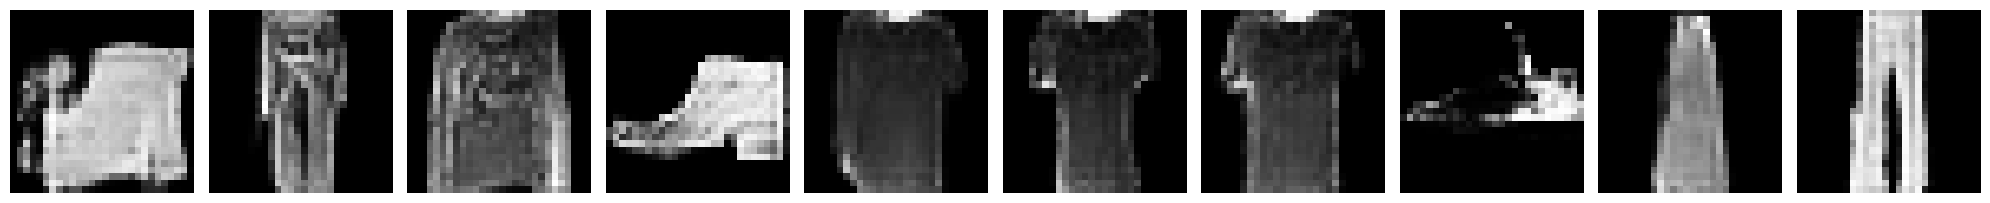

547/547 - 23s - loss: 1.4345 - d_loss: 0.6421 - g_loss: 0.7924 - 23s/epoch - 42ms/step
Epoch 79/100


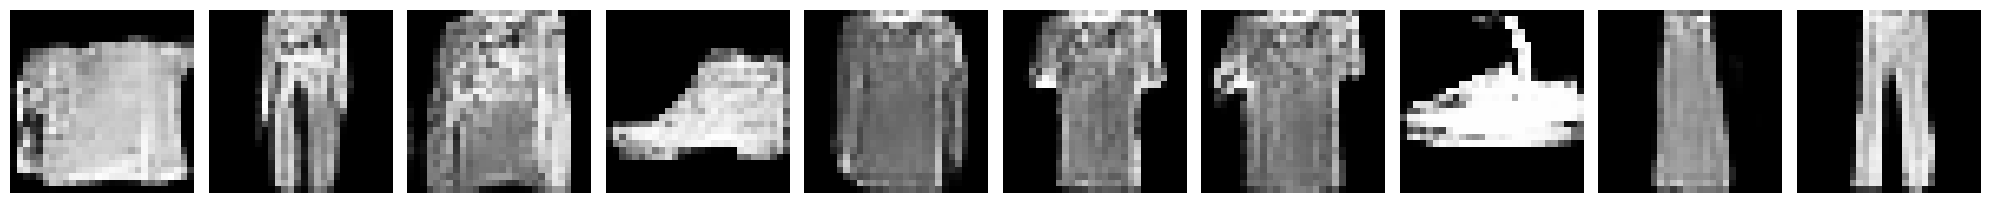

547/547 - 23s - loss: 1.4980 - d_loss: 0.6317 - g_loss: 0.8663 - 23s/epoch - 42ms/step
Epoch 80/100


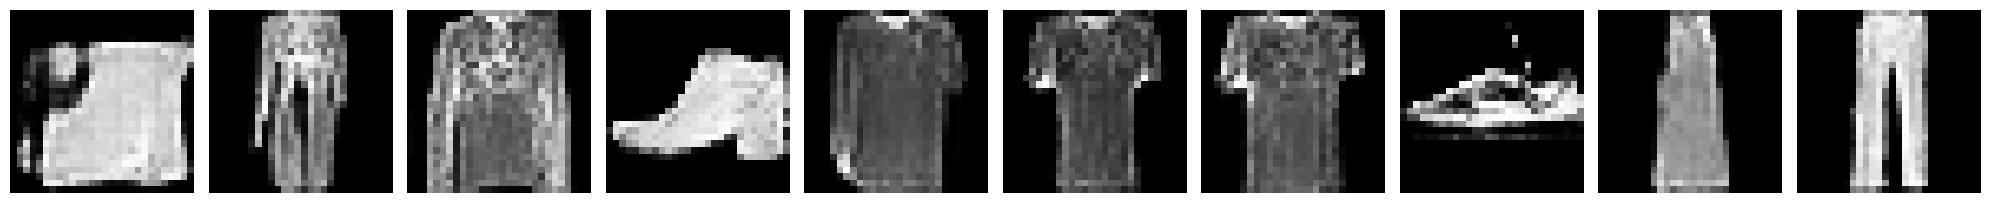

547/547 - 23s - loss: 1.4388 - d_loss: 0.6429 - g_loss: 0.7959 - 23s/epoch - 42ms/step
Epoch 81/100


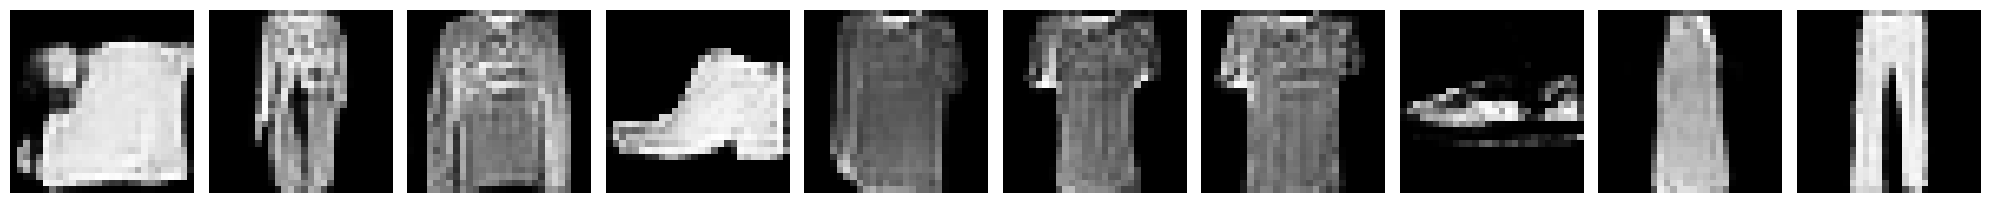

547/547 - 23s - loss: 1.4210 - d_loss: 0.6456 - g_loss: 0.7754 - 23s/epoch - 42ms/step
Epoch 82/100


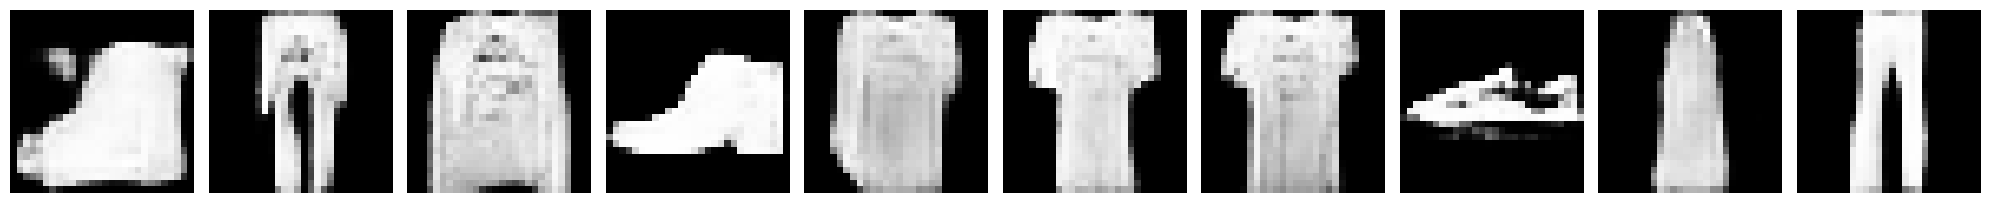

547/547 - 23s - loss: 1.4766 - d_loss: 0.6413 - g_loss: 0.8353 - 23s/epoch - 42ms/step
Epoch 83/100


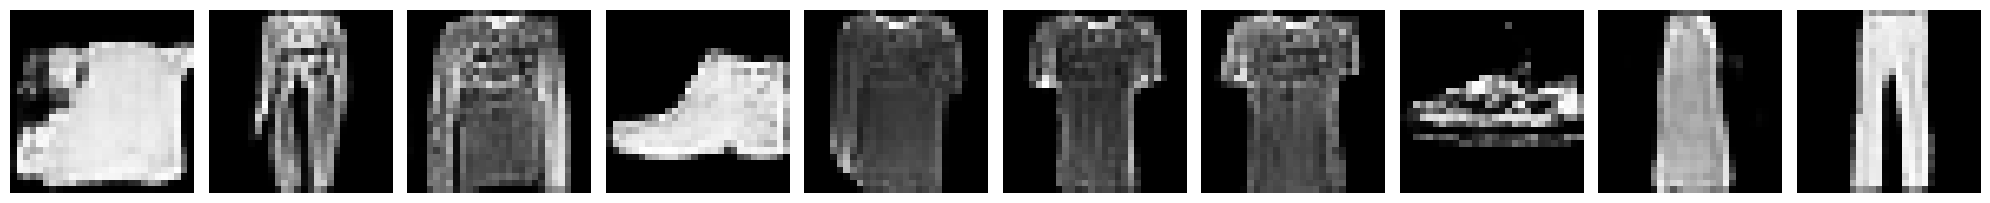

547/547 - 23s - loss: 1.4750 - d_loss: 0.6365 - g_loss: 0.8385 - 23s/epoch - 42ms/step
Epoch 84/100


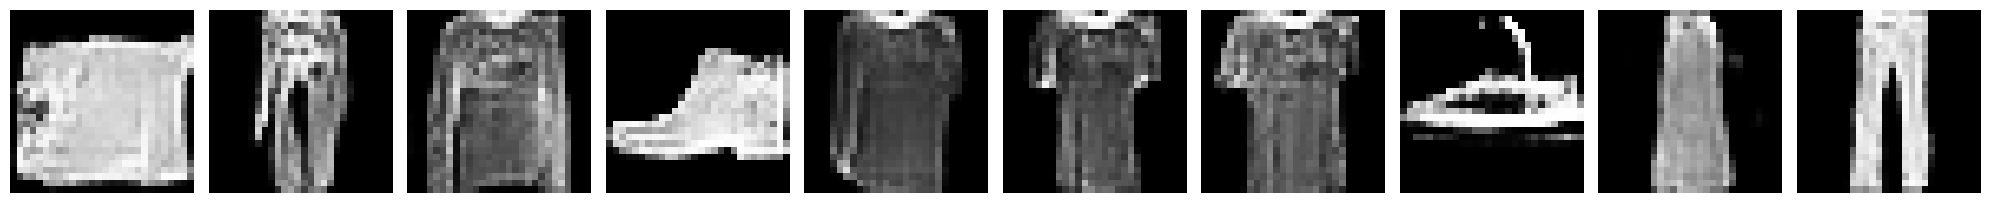

547/547 - 23s - loss: 1.4191 - d_loss: 0.6478 - g_loss: 0.7714 - 23s/epoch - 43ms/step
Epoch 85/100


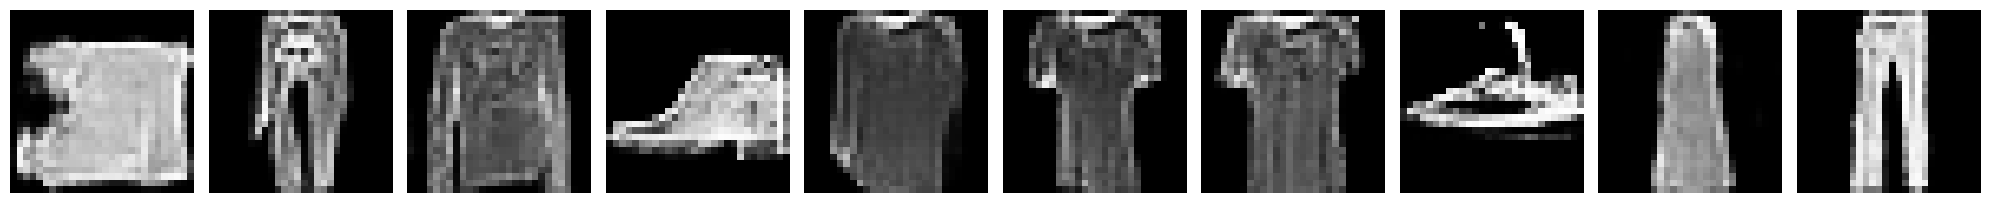

547/547 - 23s - loss: 1.4335 - d_loss: 0.6483 - g_loss: 0.7852 - 23s/epoch - 42ms/step
Epoch 86/100


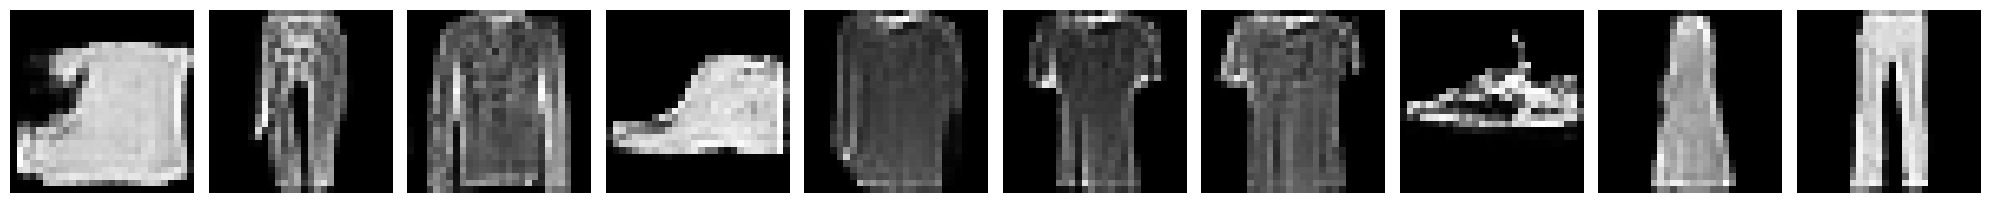

547/547 - 23s - loss: 1.4291 - d_loss: 0.6533 - g_loss: 0.7758 - 23s/epoch - 42ms/step
Epoch 87/100


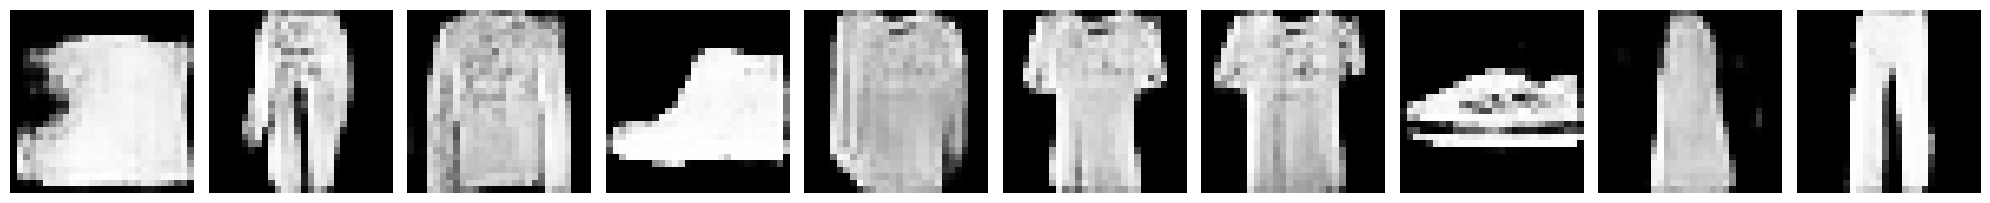

547/547 - 23s - loss: 1.4523 - d_loss: 0.6556 - g_loss: 0.7967 - 23s/epoch - 42ms/step
Epoch 88/100


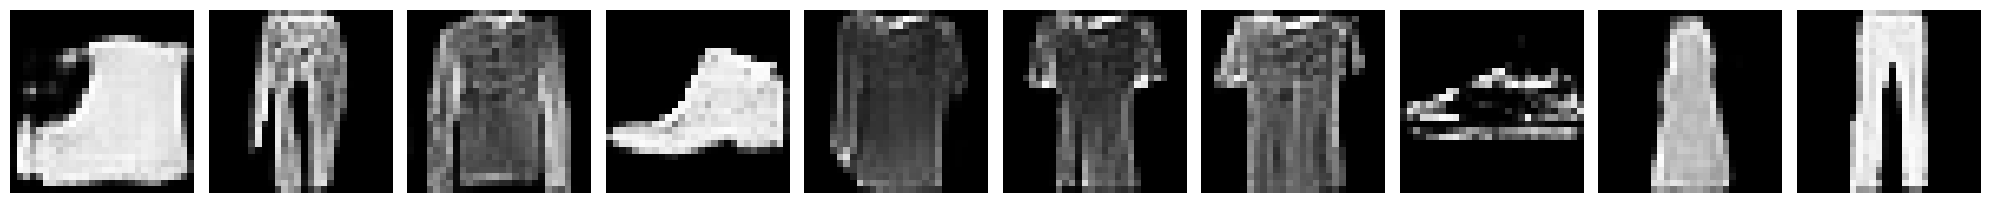

547/547 - 23s - loss: 1.4805 - d_loss: 0.6421 - g_loss: 0.8384 - 23s/epoch - 42ms/step
Epoch 89/100


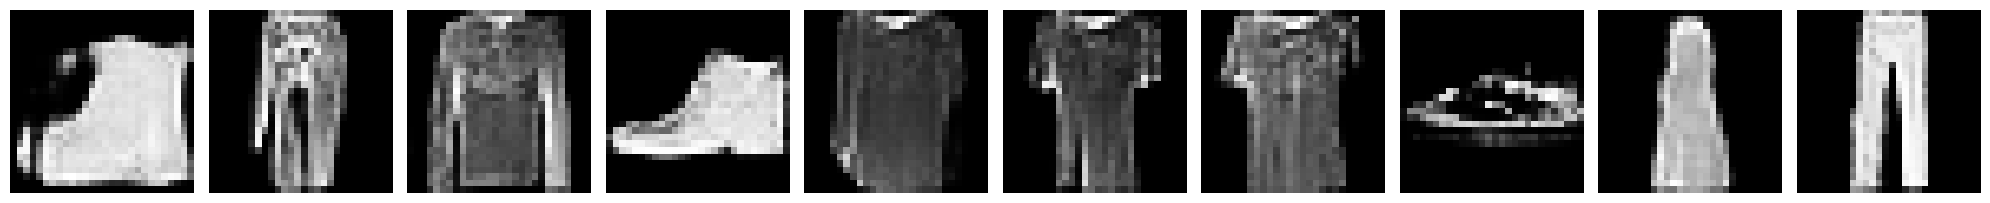

547/547 - 23s - loss: 1.4084 - d_loss: 0.6544 - g_loss: 0.7540 - 23s/epoch - 42ms/step
Epoch 90/100


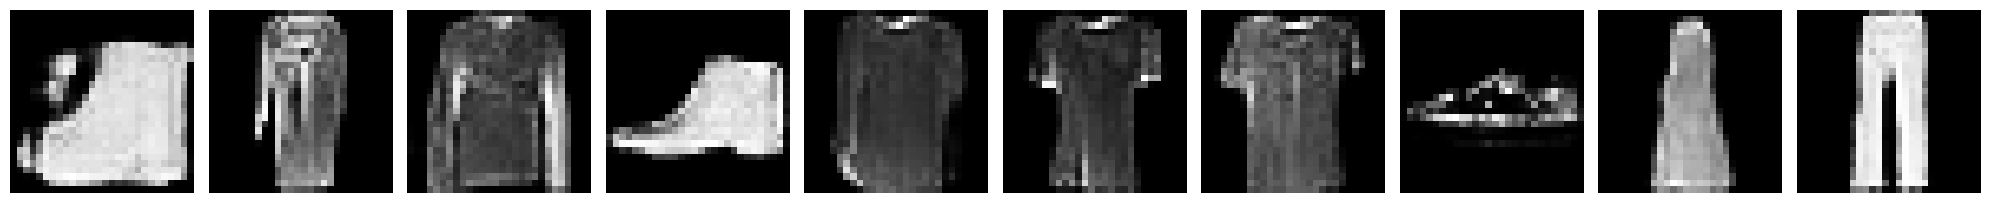

547/547 - 23s - loss: 1.4315 - d_loss: 0.6512 - g_loss: 0.7802 - 23s/epoch - 41ms/step
Epoch 91/100


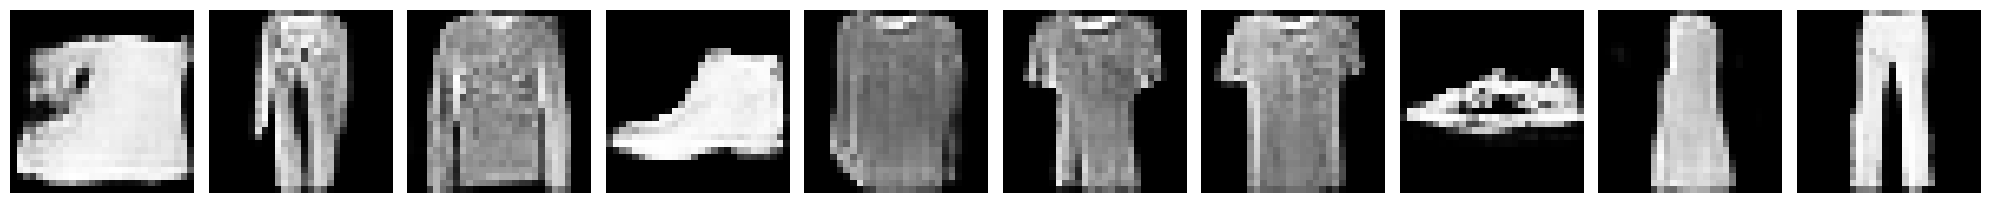

547/547 - 23s - loss: 1.4591 - d_loss: 0.6506 - g_loss: 0.8084 - 23s/epoch - 42ms/step
Epoch 92/100


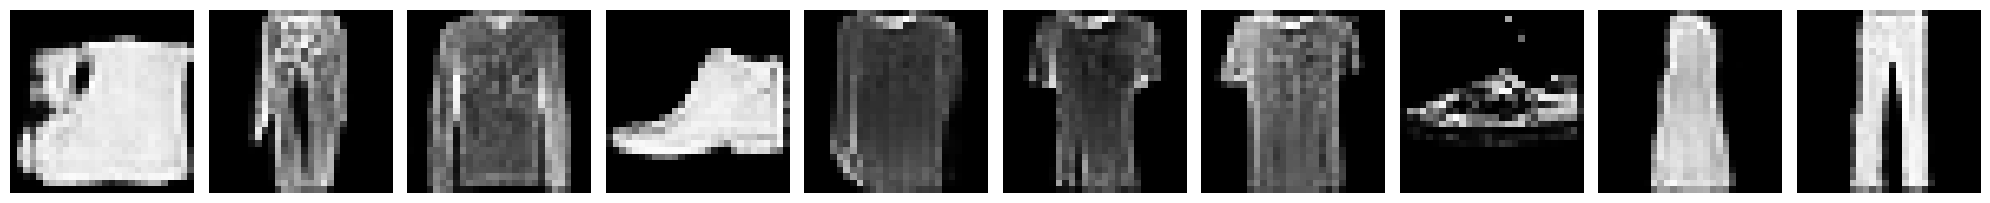

547/547 - 23s - loss: 1.4589 - d_loss: 0.6439 - g_loss: 0.8150 - 23s/epoch - 42ms/step
Epoch 93/100


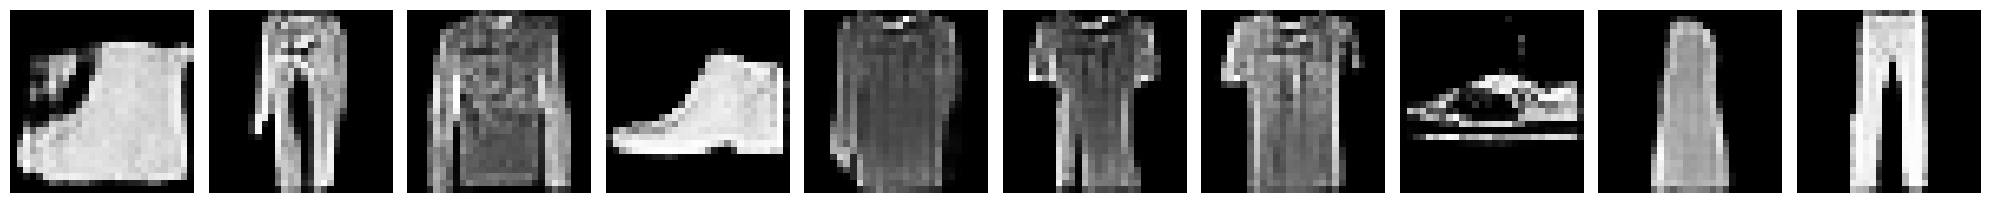

547/547 - 23s - loss: 1.4126 - d_loss: 0.6552 - g_loss: 0.7575 - 23s/epoch - 42ms/step
Epoch 94/100


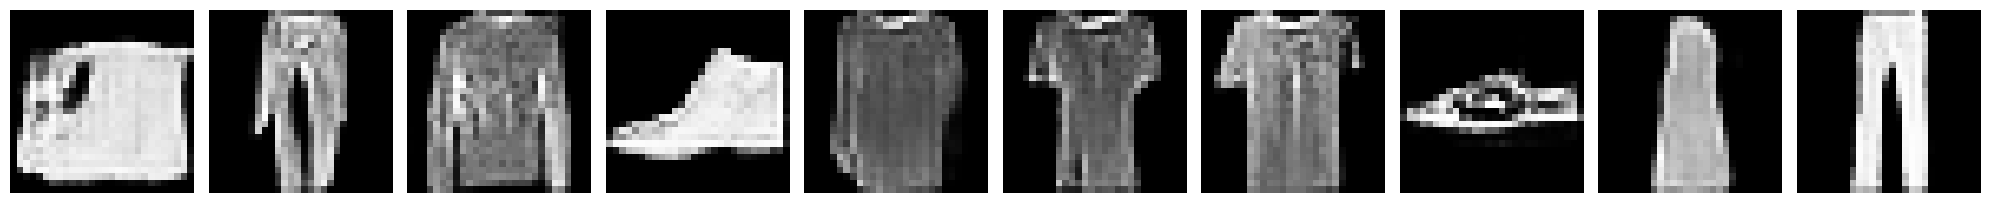

547/547 - 23s - loss: 1.4235 - d_loss: 0.6536 - g_loss: 0.7699 - 23s/epoch - 42ms/step
Epoch 95/100


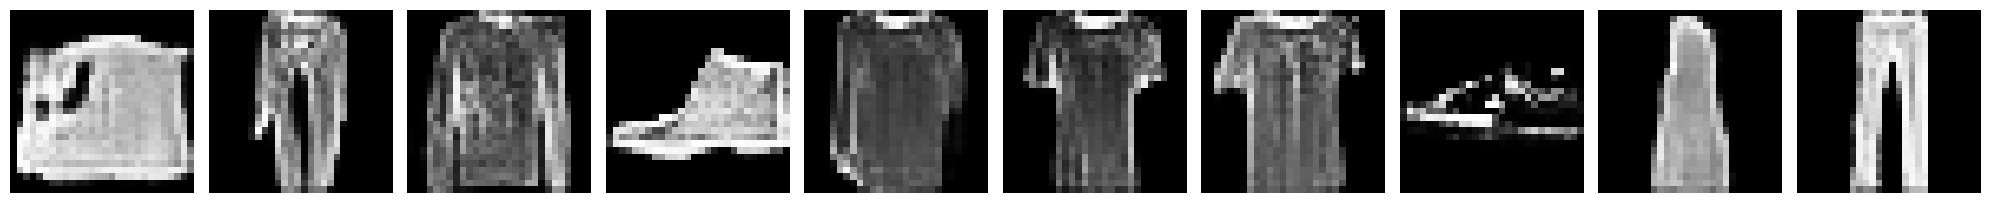

547/547 - 23s - loss: 1.4399 - d_loss: 0.6530 - g_loss: 0.7869 - 23s/epoch - 42ms/step
Epoch 96/100


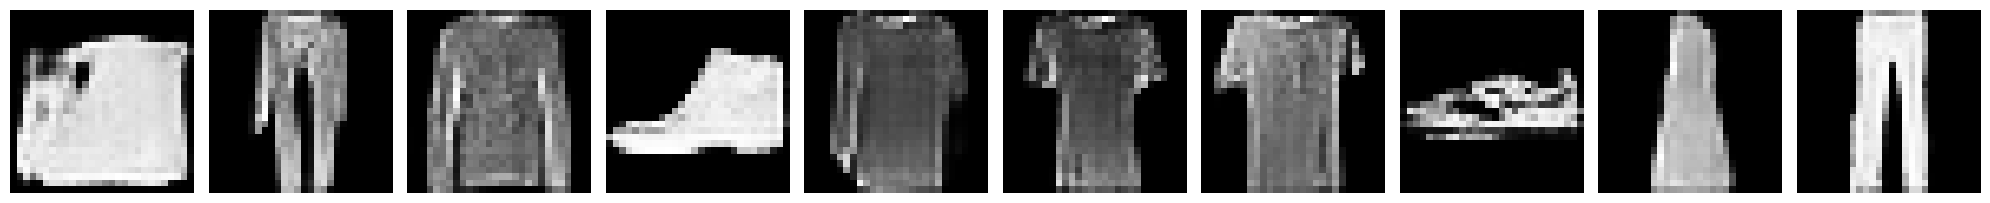

547/547 - 23s - loss: 1.4751 - d_loss: 0.6430 - g_loss: 0.8320 - 23s/epoch - 41ms/step
Epoch 97/100


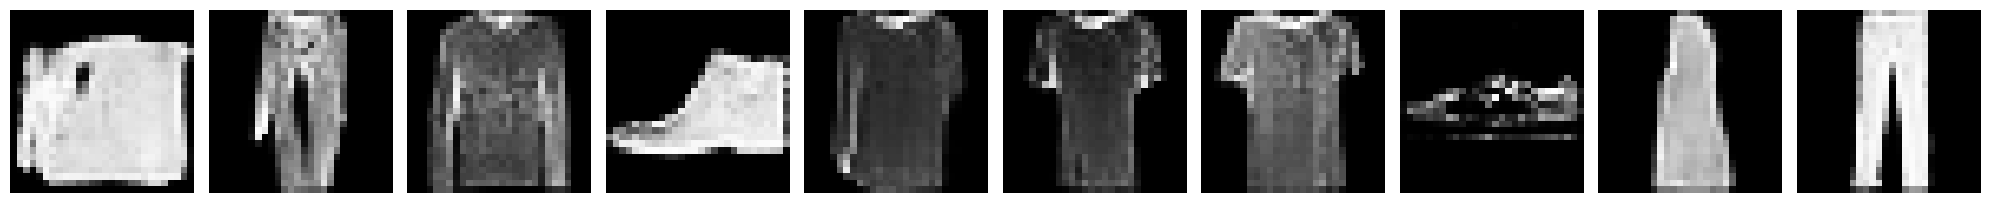

547/547 - 23s - loss: 1.4221 - d_loss: 0.6544 - g_loss: 0.7676 - 23s/epoch - 41ms/step
Epoch 98/100


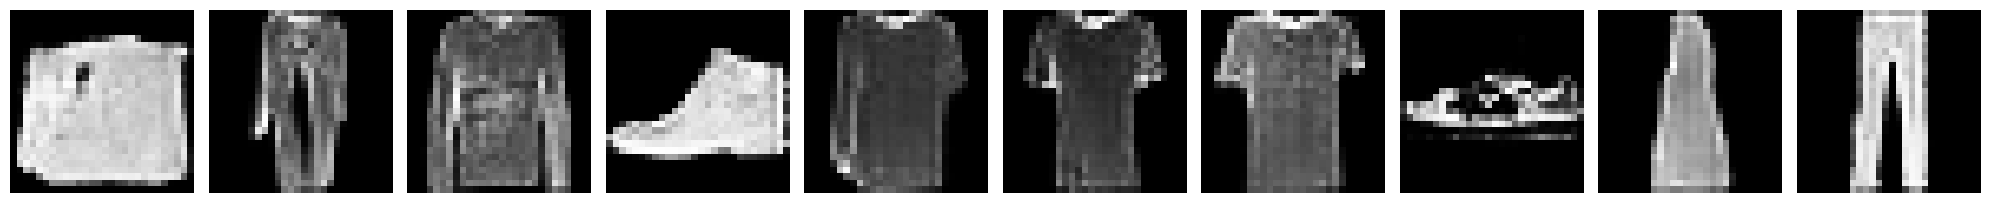

547/547 - 23s - loss: 1.4047 - d_loss: 0.6542 - g_loss: 0.7505 - 23s/epoch - 42ms/step
Epoch 99/100


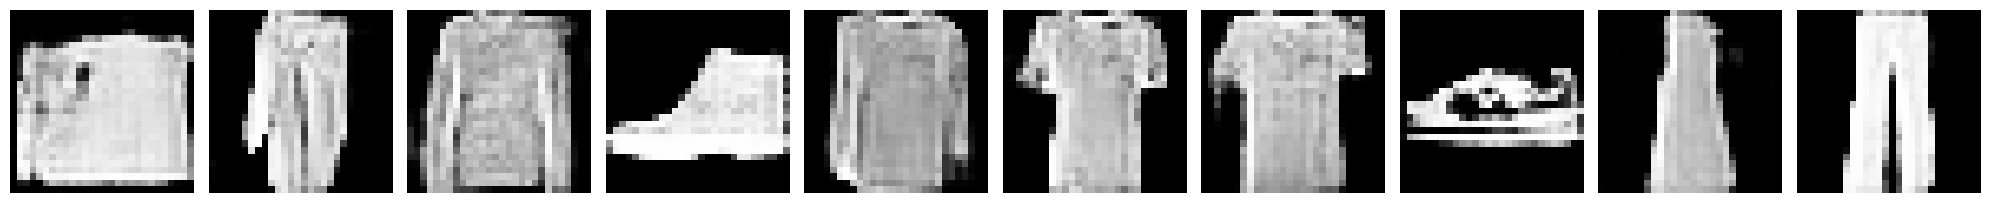

547/547 - 23s - loss: 1.4698 - d_loss: 0.6517 - g_loss: 0.8181 - 23s/epoch - 42ms/step
Epoch 100/100


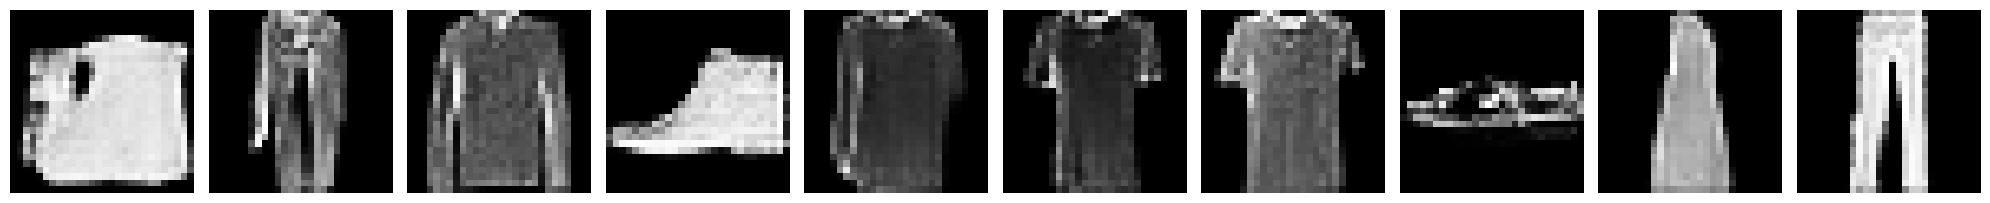

547/547 - 23s - loss: 1.4543 - d_loss: 0.6456 - g_loss: 0.8088 - 23s/epoch - 42ms/step


In [ ]:
history = gan.fit(
    X,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [GANMonitor(name='vanilla', gray=True)],
    verbose = 2
).history

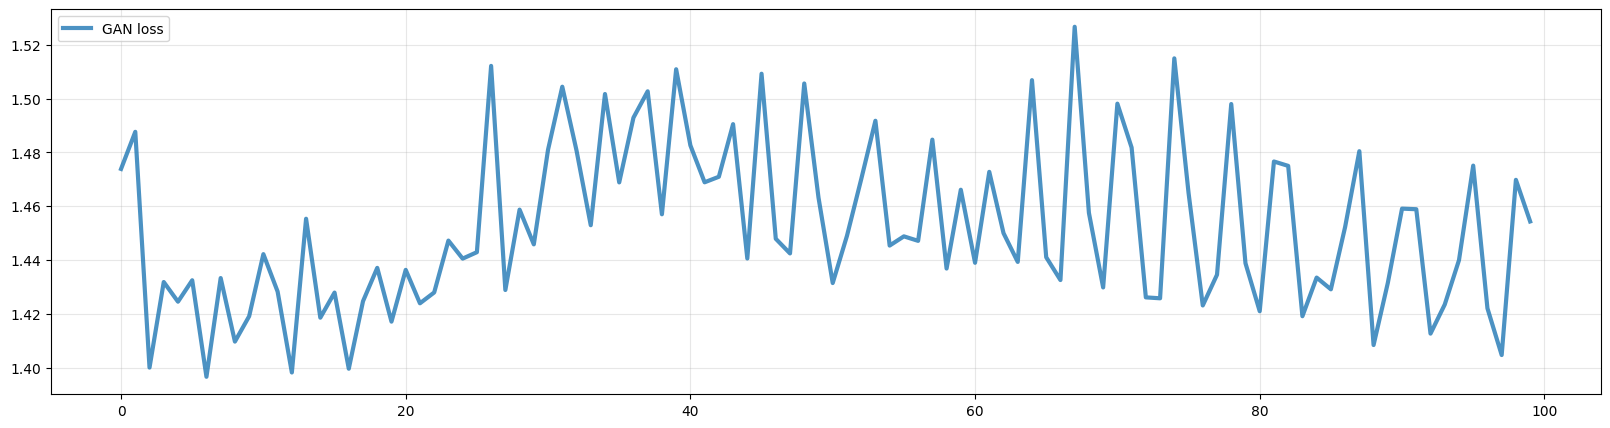

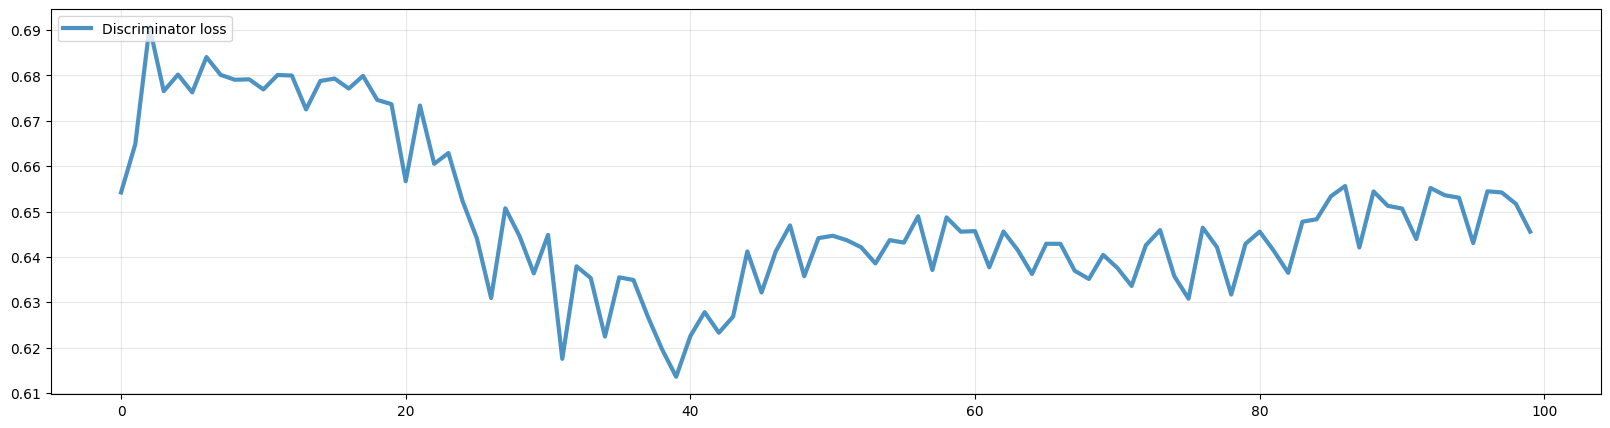

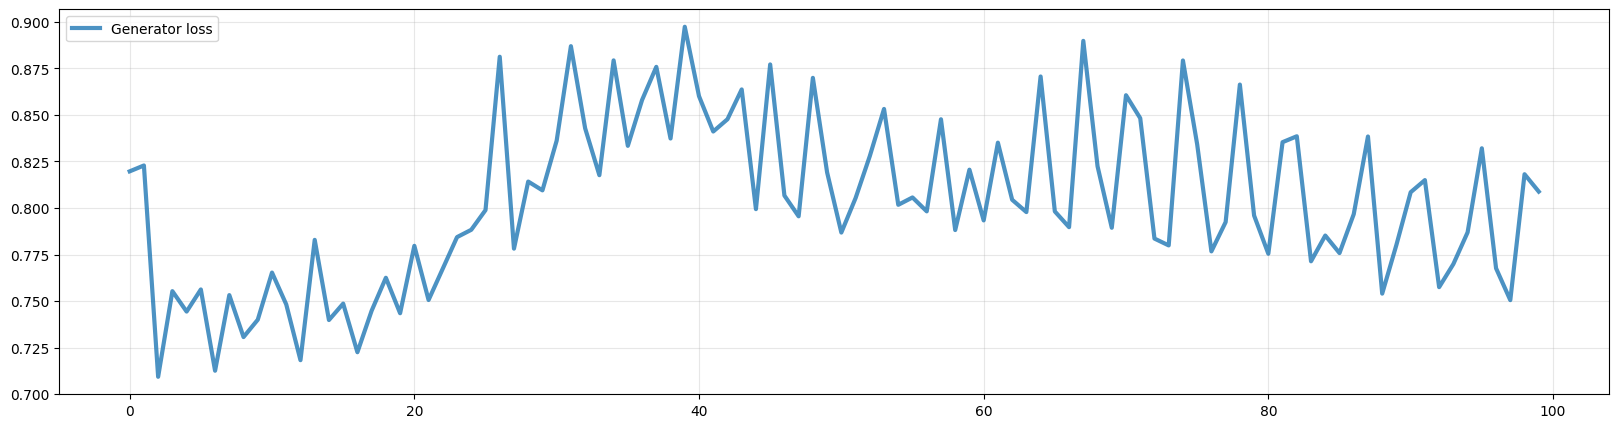

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [ ]:
gan.generator.save('vanilla_gan_generator')

In [ ]:
vanilla_gan_generator = tfk.models.load_model('vanilla_gan_generator')

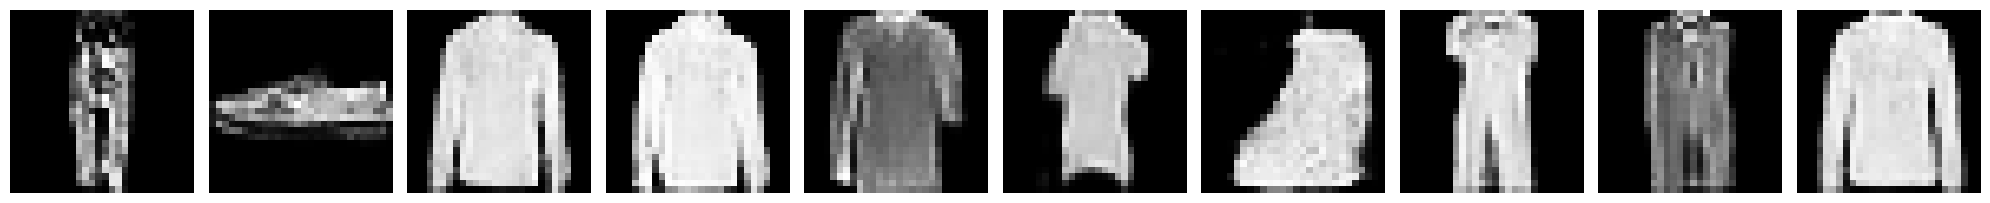

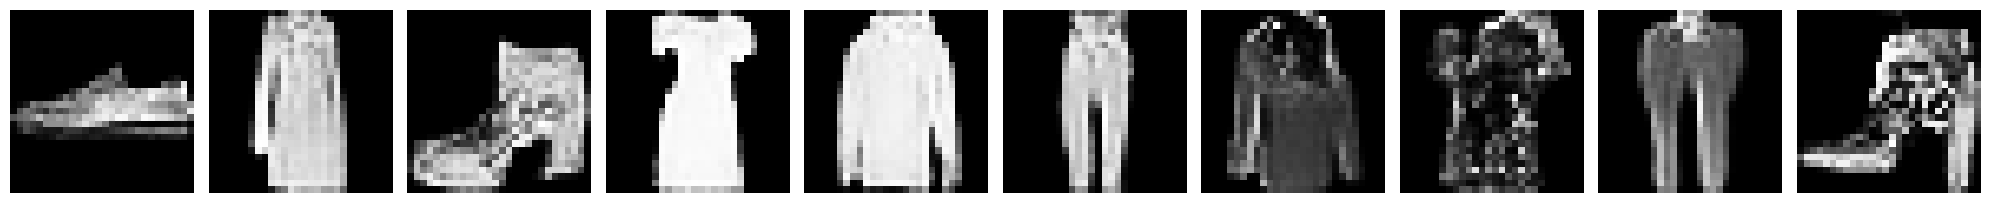

In [ ]:
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)

In [ ]:
imgs = 2500
X_hat = generate_dataset(vanilla_gan_generator, imgs, latent_dim)*127.5 + 127.5
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))
X_hat = np.mean(X_hat, axis=0)

X_temp = X[:imgs]*127.5 + 127.5
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)

print(X_hat.shape, X_temp.shape)

(784,) (784,)


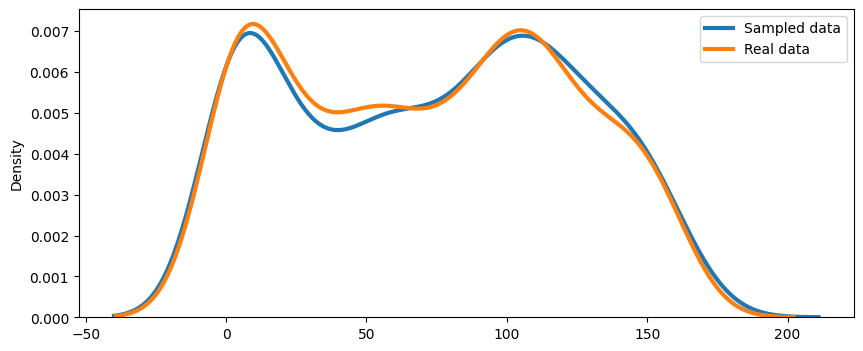

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()

### Deep Convolutional Conditional GAN

In [ ]:
image_size = input_shape[0]
num_classes = len(np.unique(y))
num_channels = input_shape[-1]

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [ ]:
conditional_generator_input = (generator_in_channels)
conditional_discriminator_input = (image_size, image_size, discriminator_in_channels)
conditional_discriminator_input, conditional_generator_input

((28, 28, 11), 138)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 11)]      0         
                                                                 
 padding (ZeroPadding2D)     (None, 32, 32, 11)        0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 64)        6400      
                                                                 
 bn1 (BatchNormalization)    (None, 16, 16, 64)        256       
                                                                 
 activation1 (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 bn2 (BatchNormalization)    (None, 8, 8, 128)       

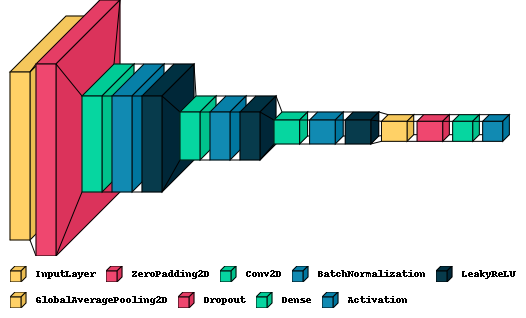

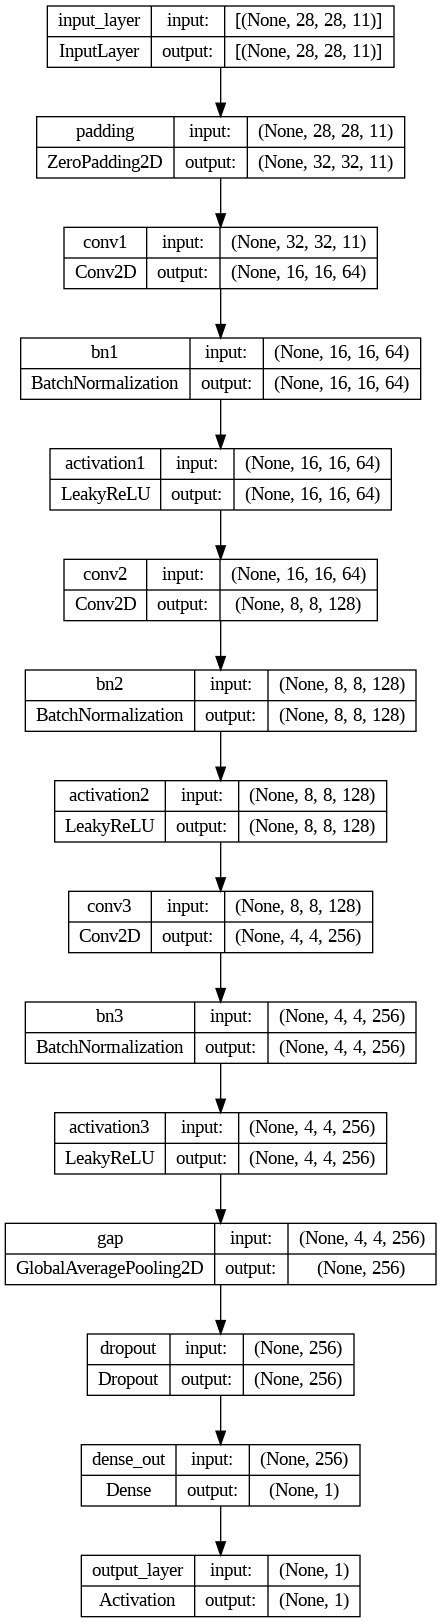

In [ ]:
discriminator = get_dc_discriminator(conditional_discriminator_input)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='conditional_discriminator.png')

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 138)]             0         
                                                                 
 dense0 (Dense)              (None, 1024)              141312    
                                                                 
 bn0 (BatchNormalization)    (None, 1024)              4096      
                                                                 
 activation0 (LeakyReLU)     (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 upsampling1 (UpSampling2D)  (None, 8, 8, 64)          0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          36

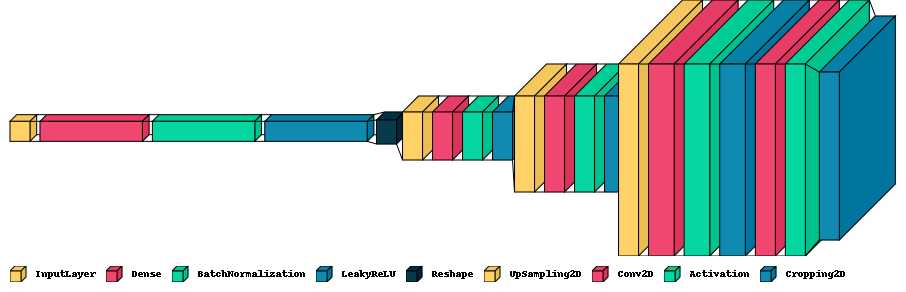

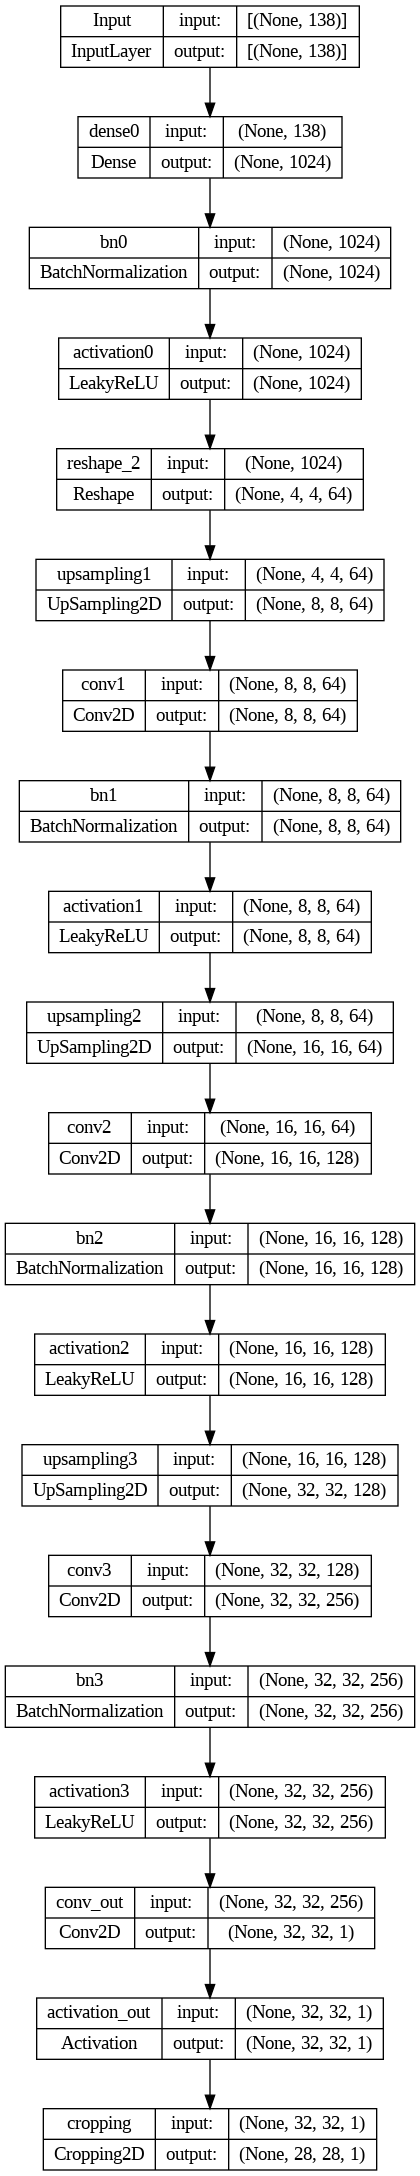

In [ ]:
generator = get_dc_generator(conditional_generator_input)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='conditional_generator.png')

In [ ]:
class ConditionalGAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data):
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], -1)

        # Generate fake images from z
        generated_images = self.generator(z)


        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        # Combine generated images and real ones
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], axis=1)

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(z)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            misleading_predictions = self.discriminator(fake_image_and_labels)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0,self.num_img), num_classes), 'float32')
        labels = tfk.utils.to_categorical(labels, num_classes)
        random_latent_vectors = tf.concat([random_latent_vectors,labels],-1)
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,2*self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png')
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)
        shutil.rmtree(self.name+"temp")

In [ ]:
all_labels = tfk.utils.to_categorical(y, num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
cgan = ConditionalGAN(
    discriminator = get_dc_discriminator(conditional_discriminator_input),
    generator = get_dc_generator(conditional_generator_input),
    latent_dim = latent_dim
)
cgan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [ ]:
def conditional_sample(model, num_img, latent_dim, fixed=True, gray=False, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,2*num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()
    return generated_images, labels

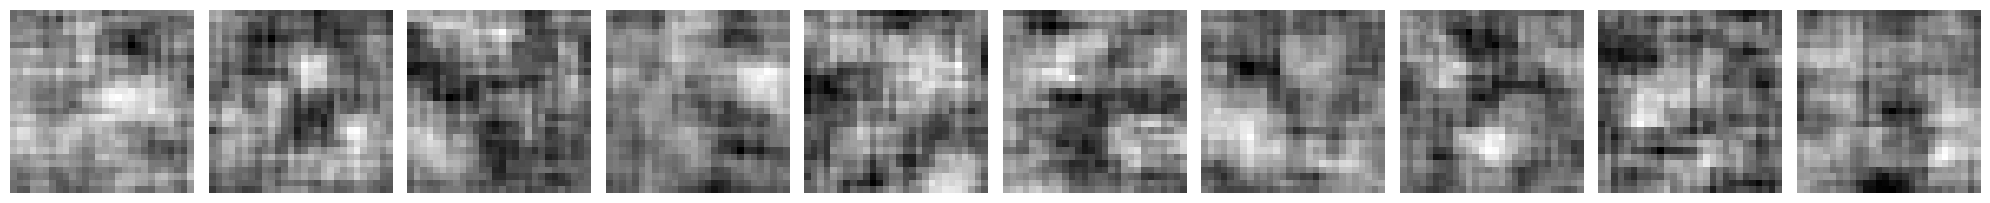

In [ ]:
conditional_sample(cgan.generator, 10, latent_dim, gray=True)

Epoch 1/100


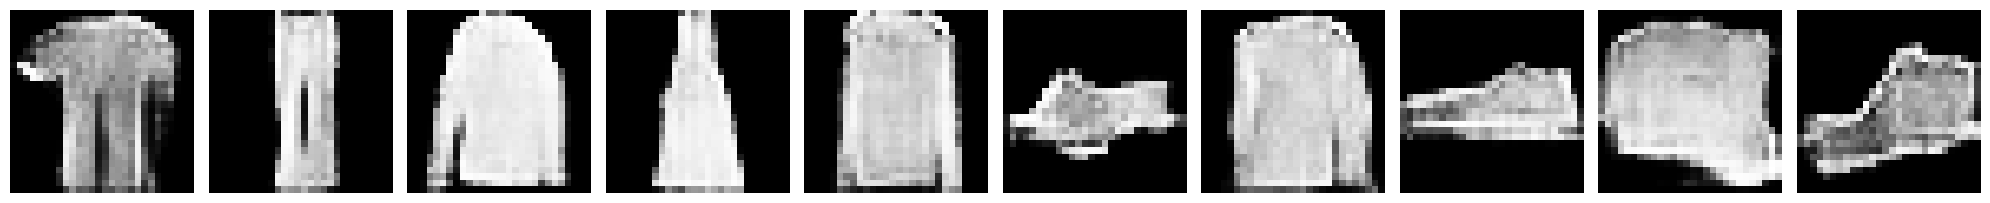

547/547 - 23s - loss: 1.4148 - d_loss: 0.6685 - g_loss: 0.7463 - 23s/epoch - 42ms/step
Epoch 2/100


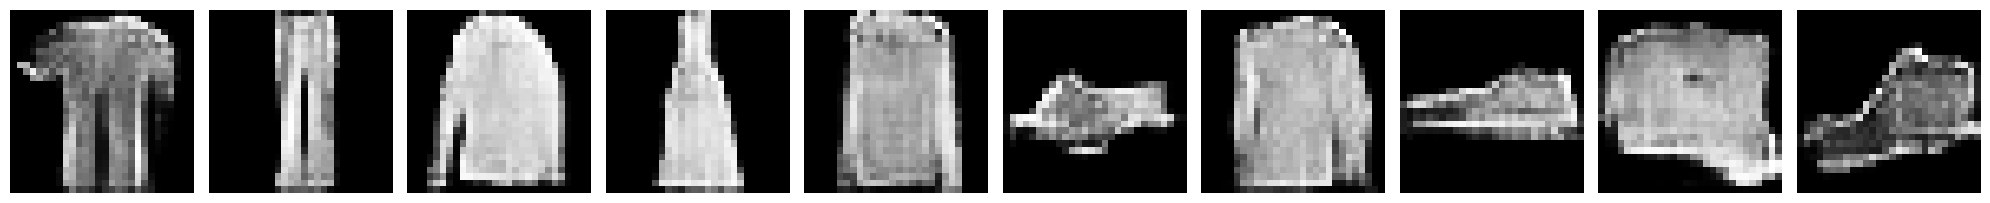

547/547 - 23s - loss: 1.4092 - d_loss: 0.6682 - g_loss: 0.7410 - 23s/epoch - 43ms/step
Epoch 3/100


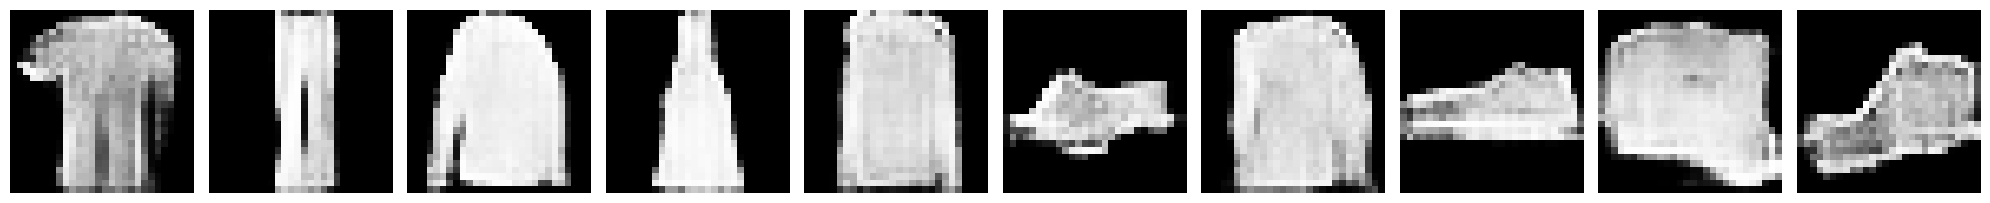

547/547 - 23s - loss: 1.4171 - d_loss: 0.6694 - g_loss: 0.7477 - 23s/epoch - 43ms/step
Epoch 4/100


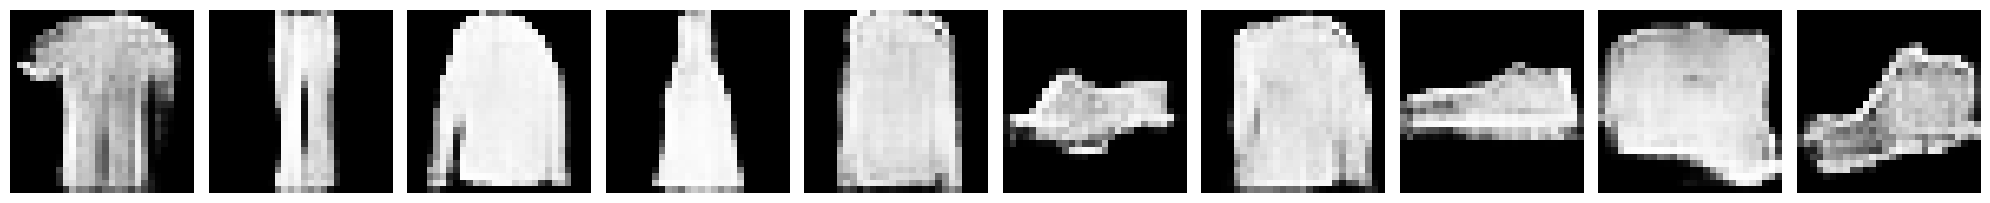

547/547 - 23s - loss: 1.4209 - d_loss: 0.6687 - g_loss: 0.7522 - 23s/epoch - 43ms/step
Epoch 5/100


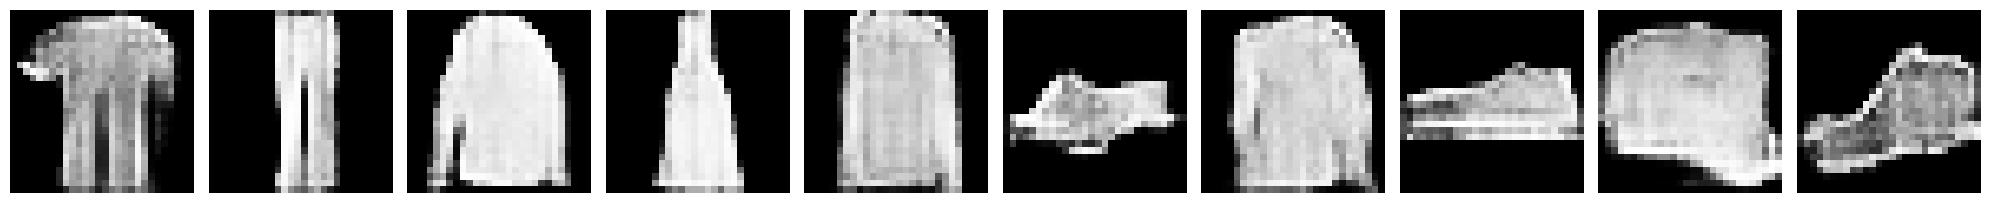

547/547 - 24s - loss: 1.4115 - d_loss: 0.6681 - g_loss: 0.7434 - 24s/epoch - 43ms/step
Epoch 6/100


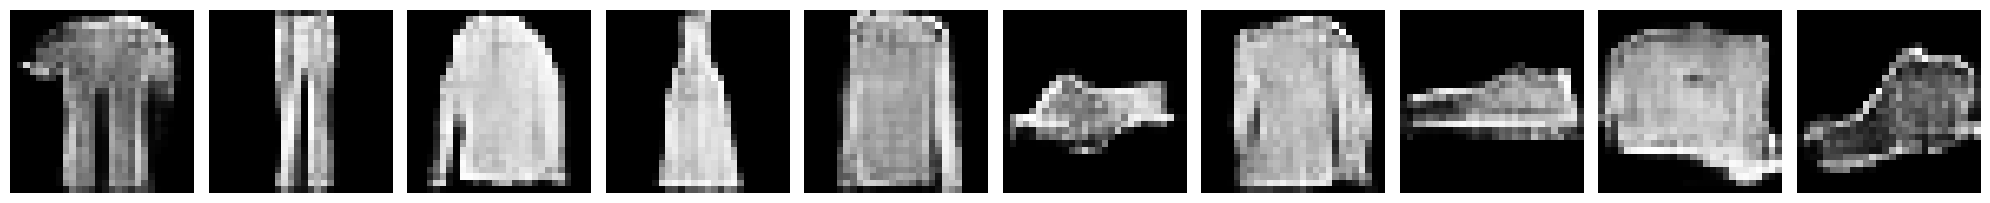

547/547 - 24s - loss: 1.4088 - d_loss: 0.6697 - g_loss: 0.7391 - 24s/epoch - 43ms/step
Epoch 7/100


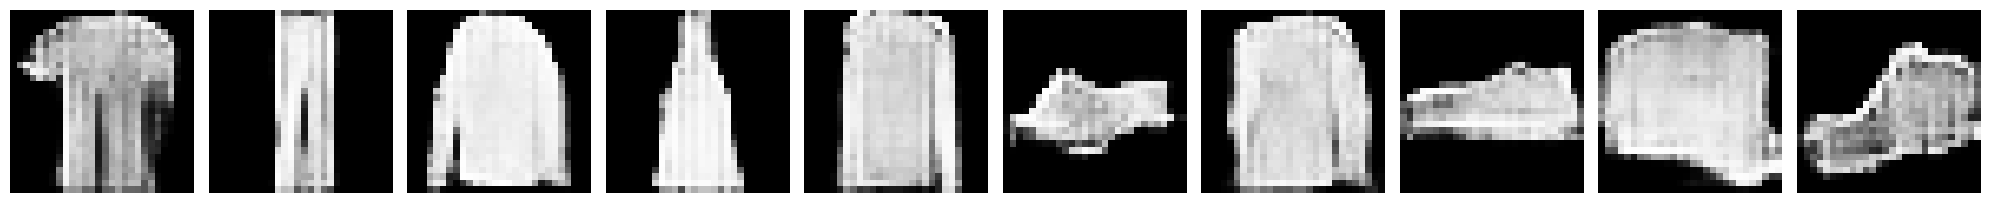

547/547 - 23s - loss: 1.4181 - d_loss: 0.6704 - g_loss: 0.7476 - 23s/epoch - 43ms/step
Epoch 8/100


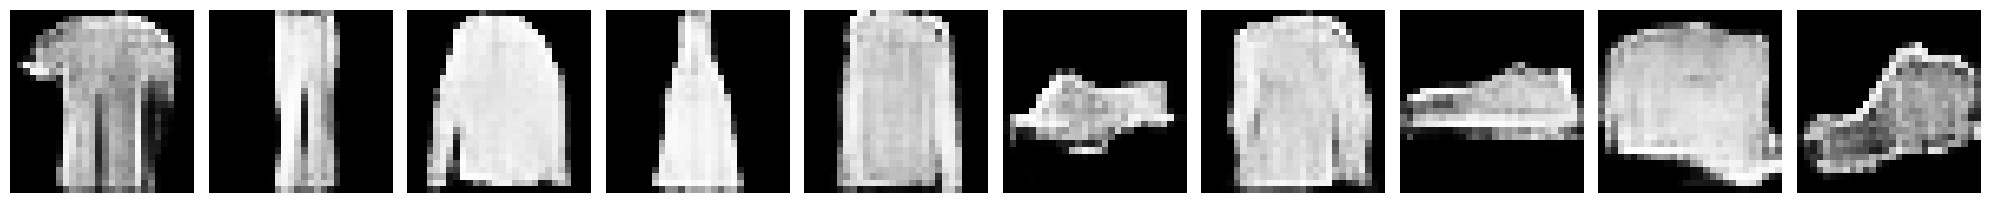

547/547 - 23s - loss: 1.4205 - d_loss: 0.6696 - g_loss: 0.7508 - 23s/epoch - 42ms/step
Epoch 9/100


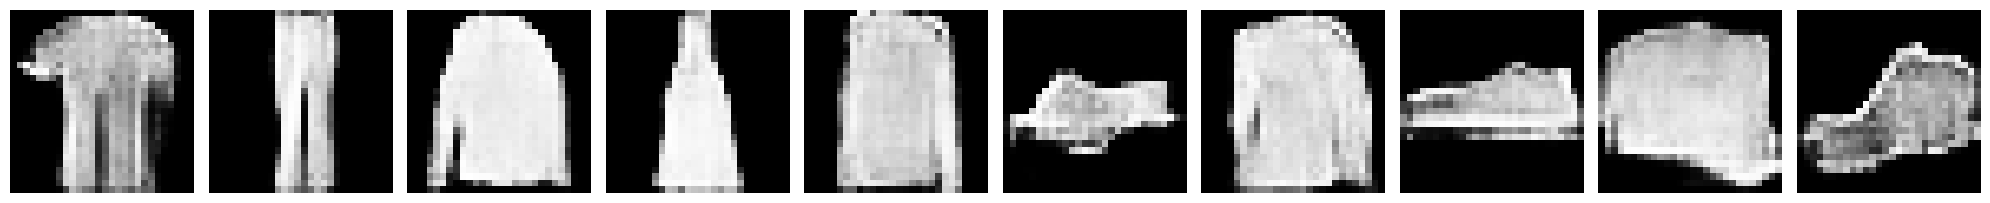

547/547 - 23s - loss: 1.4092 - d_loss: 0.6707 - g_loss: 0.7385 - 23s/epoch - 42ms/step
Epoch 10/100


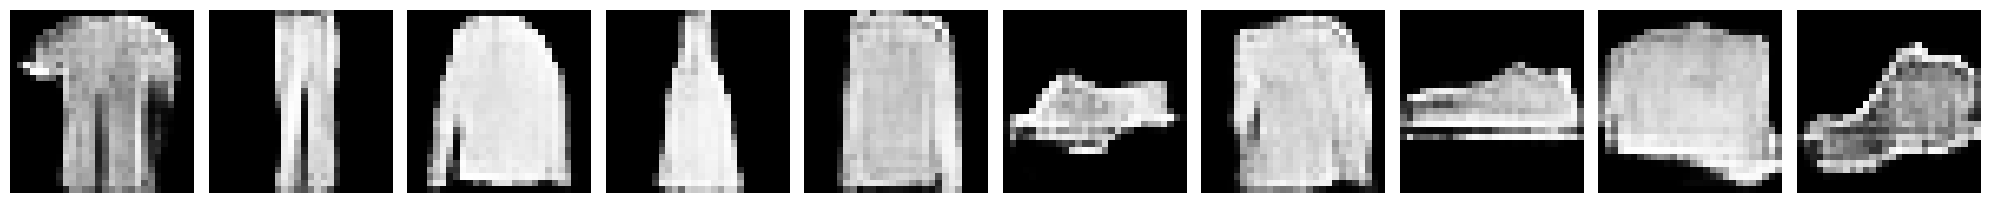

547/547 - 23s - loss: 1.4077 - d_loss: 0.6710 - g_loss: 0.7367 - 23s/epoch - 43ms/step
Epoch 11/100


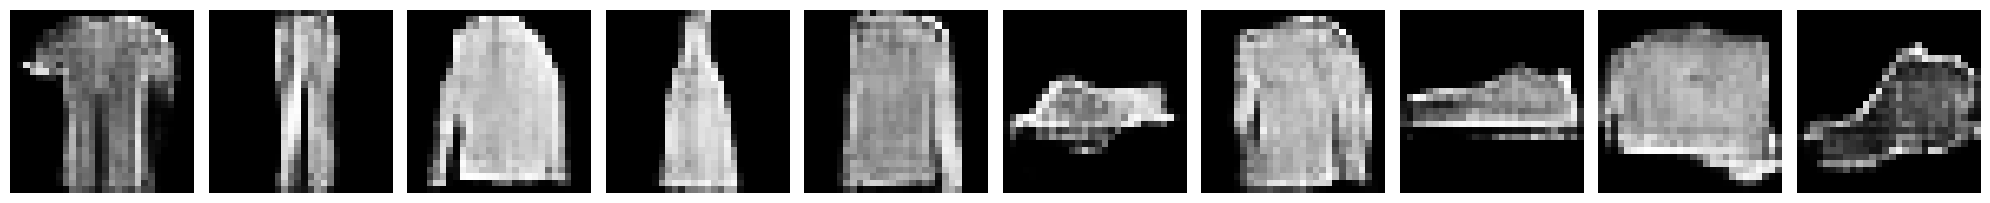

547/547 - 23s - loss: 1.4157 - d_loss: 0.6716 - g_loss: 0.7441 - 23s/epoch - 43ms/step
Epoch 12/100


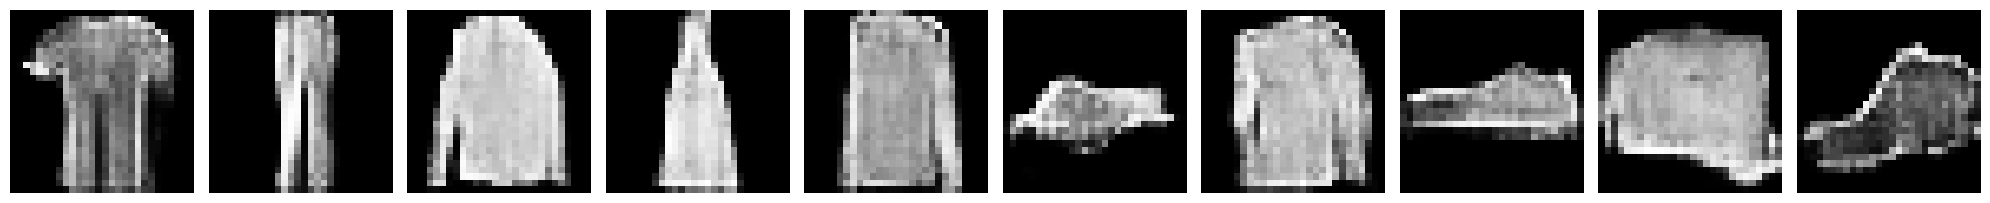

547/547 - 24s - loss: 1.4191 - d_loss: 0.6718 - g_loss: 0.7473 - 24s/epoch - 43ms/step
Epoch 13/100


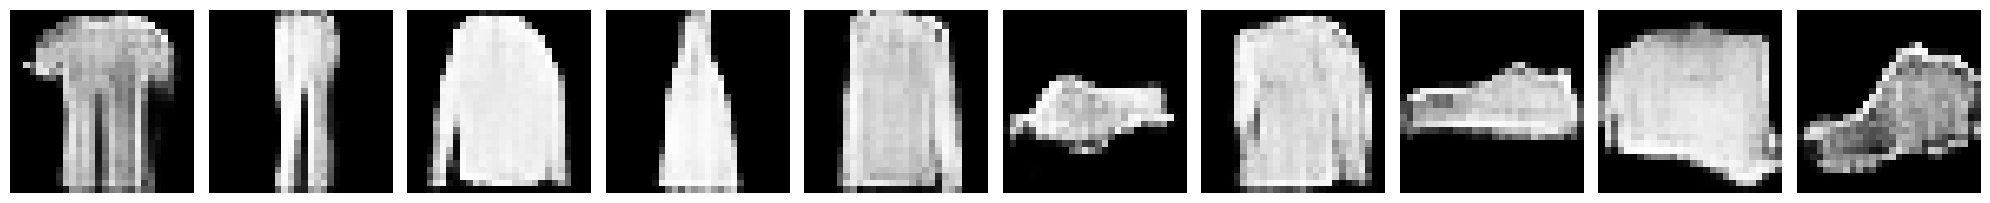

547/547 - 23s - loss: 1.4053 - d_loss: 0.6725 - g_loss: 0.7328 - 23s/epoch - 42ms/step
Epoch 14/100


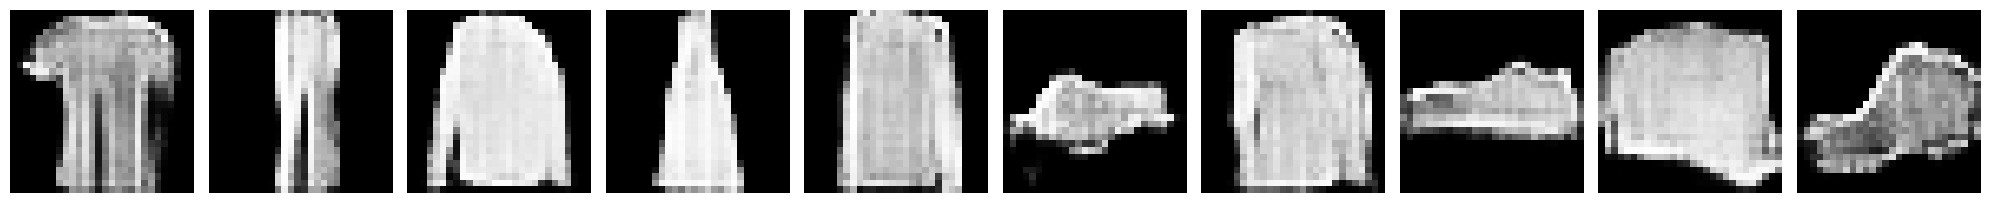

547/547 - 23s - loss: 1.4217 - d_loss: 0.6723 - g_loss: 0.7494 - 23s/epoch - 42ms/step
Epoch 15/100


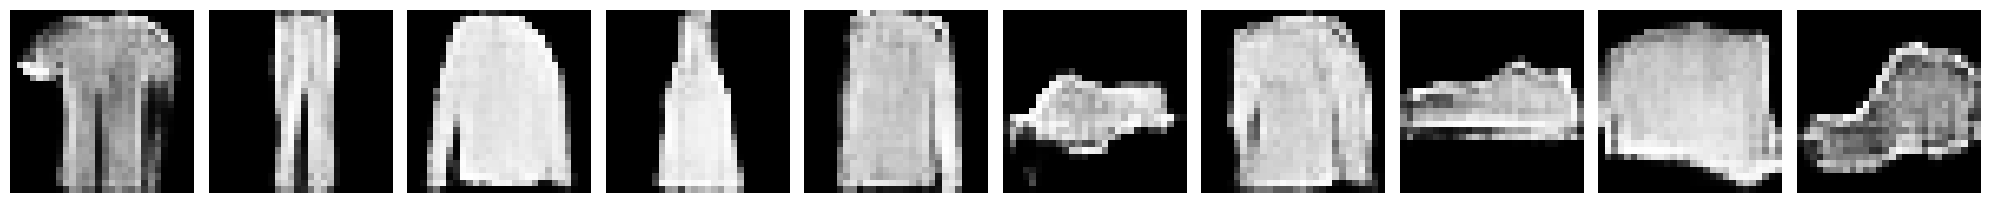

547/547 - 23s - loss: 1.4075 - d_loss: 0.6716 - g_loss: 0.7359 - 23s/epoch - 42ms/step
Epoch 16/100


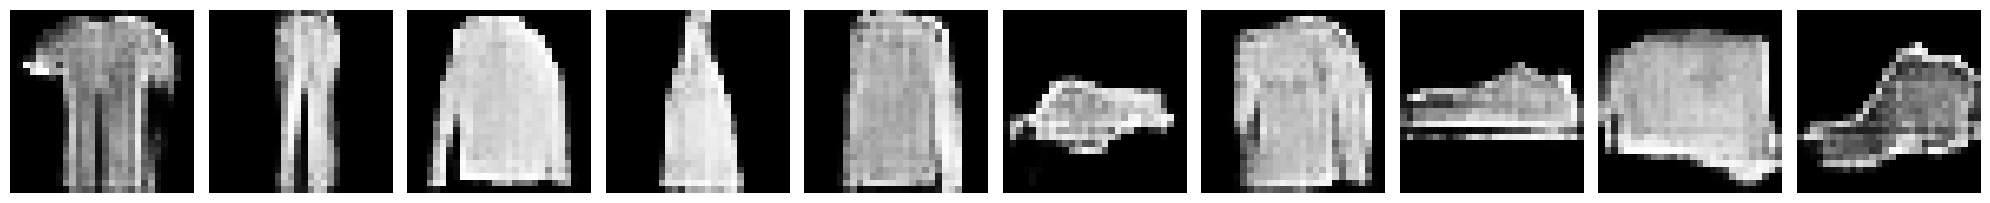

547/547 - 23s - loss: 1.4125 - d_loss: 0.6724 - g_loss: 0.7401 - 23s/epoch - 42ms/step
Epoch 17/100


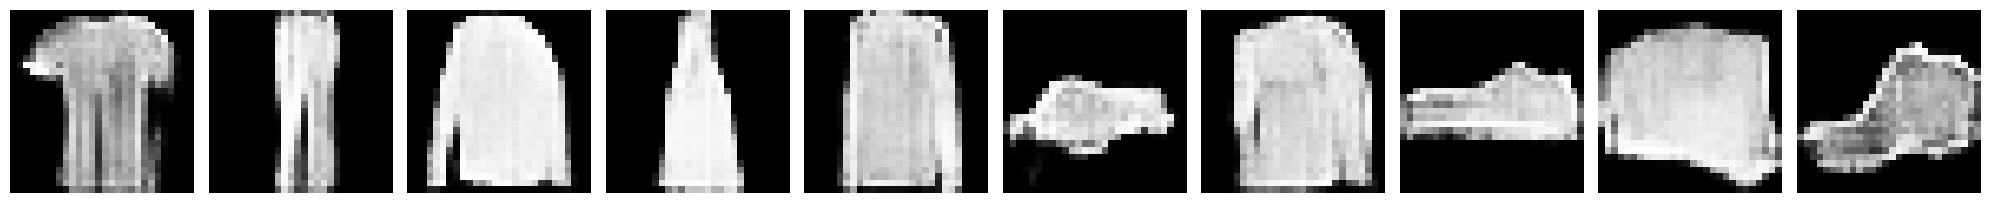

547/547 - 23s - loss: 1.4219 - d_loss: 0.6724 - g_loss: 0.7495 - 23s/epoch - 42ms/step
Epoch 18/100


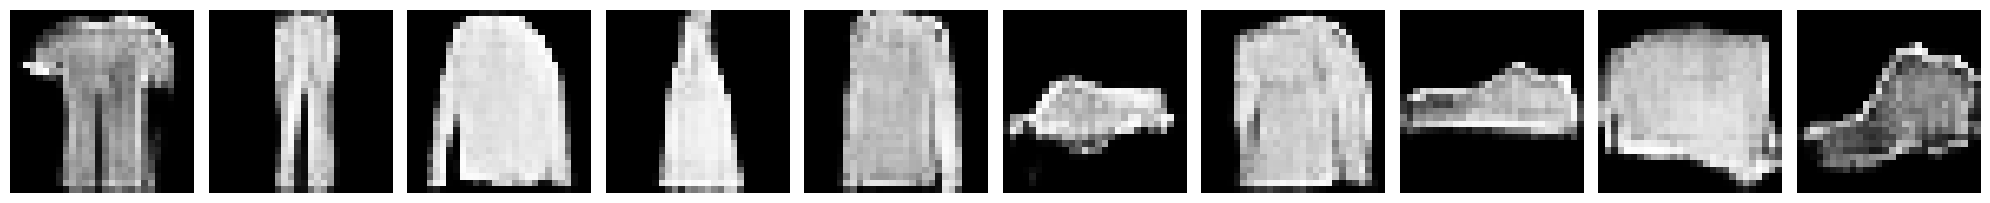

547/547 - 24s - loss: 1.4028 - d_loss: 0.6727 - g_loss: 0.7300 - 24s/epoch - 43ms/step
Epoch 19/100


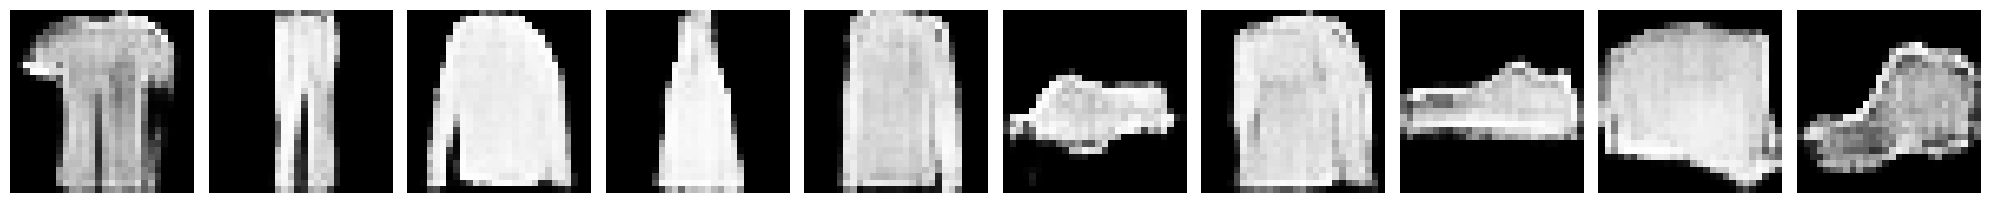

547/547 - 24s - loss: 1.4052 - d_loss: 0.6732 - g_loss: 0.7321 - 24s/epoch - 44ms/step
Epoch 20/100


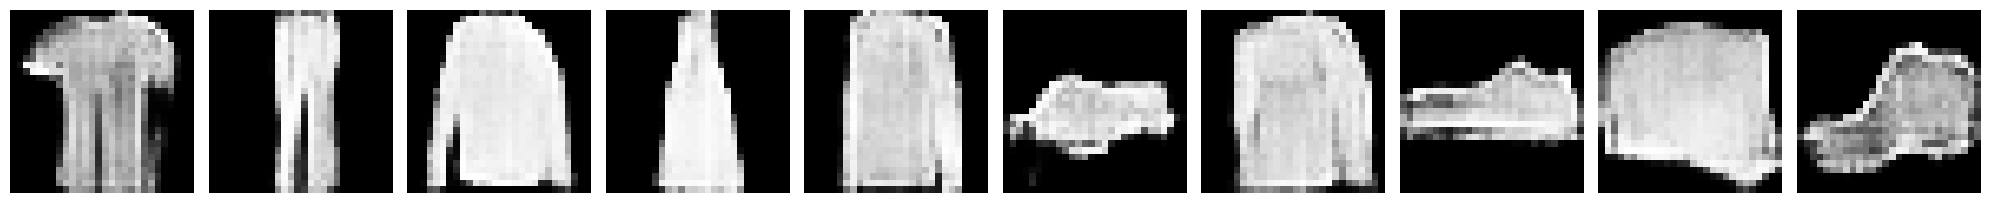

547/547 - 24s - loss: 1.4244 - d_loss: 0.6730 - g_loss: 0.7514 - 24s/epoch - 43ms/step
Epoch 21/100


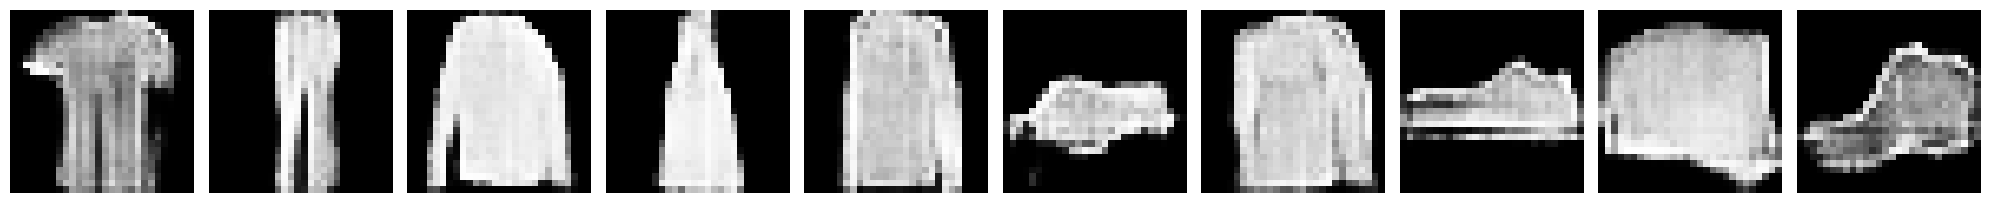

547/547 - 24s - loss: 1.4076 - d_loss: 0.6730 - g_loss: 0.7346 - 24s/epoch - 43ms/step
Epoch 22/100


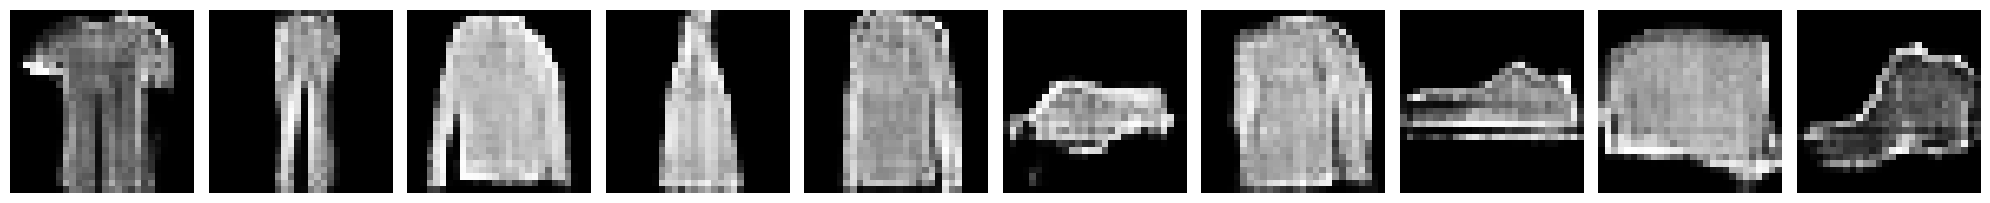

547/547 - 24s - loss: 1.4061 - d_loss: 0.6737 - g_loss: 0.7324 - 24s/epoch - 44ms/step
Epoch 23/100


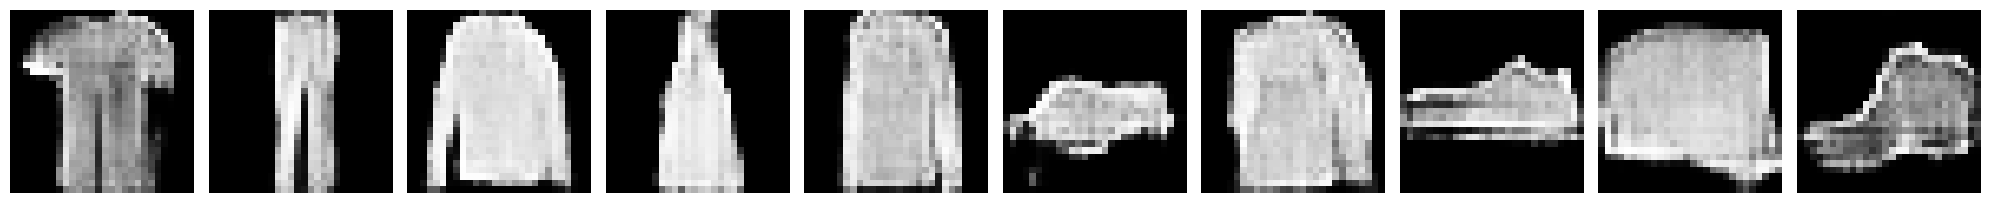

547/547 - 24s - loss: 1.4165 - d_loss: 0.6744 - g_loss: 0.7420 - 24s/epoch - 43ms/step
Epoch 24/100


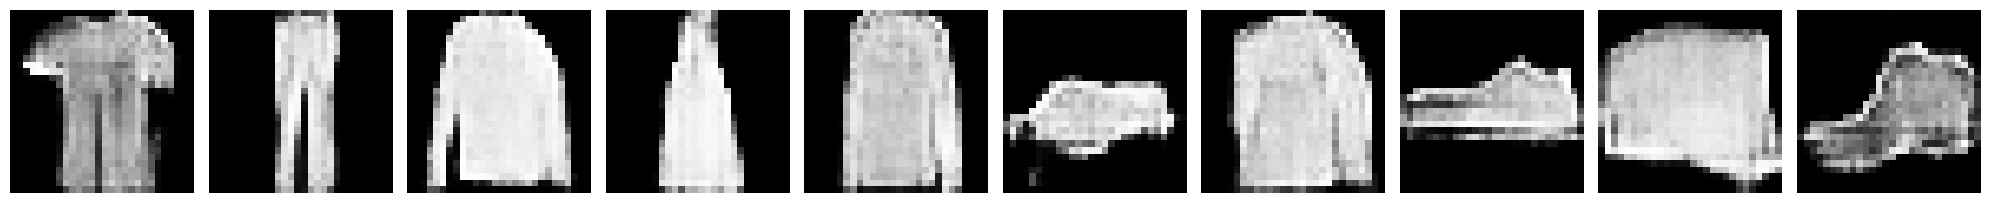

547/547 - 24s - loss: 1.4034 - d_loss: 0.6747 - g_loss: 0.7287 - 24s/epoch - 43ms/step
Epoch 25/100


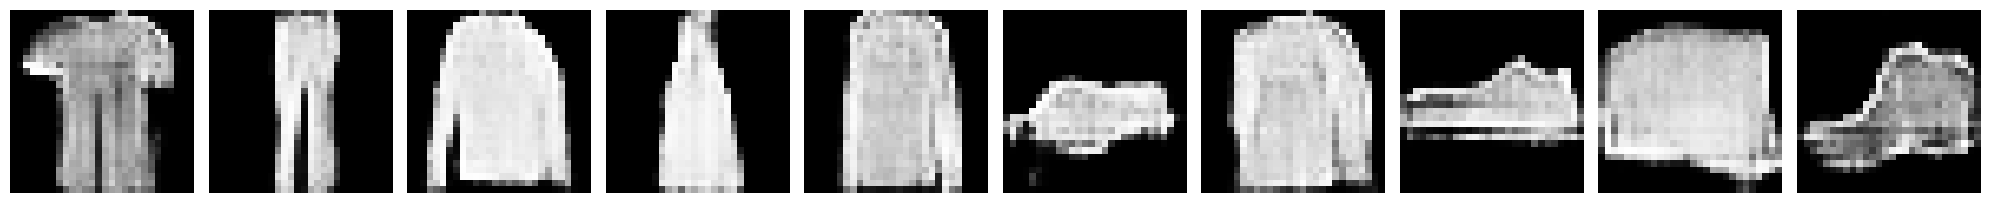

547/547 - 24s - loss: 1.4017 - d_loss: 0.6755 - g_loss: 0.7262 - 24s/epoch - 44ms/step
Epoch 26/100


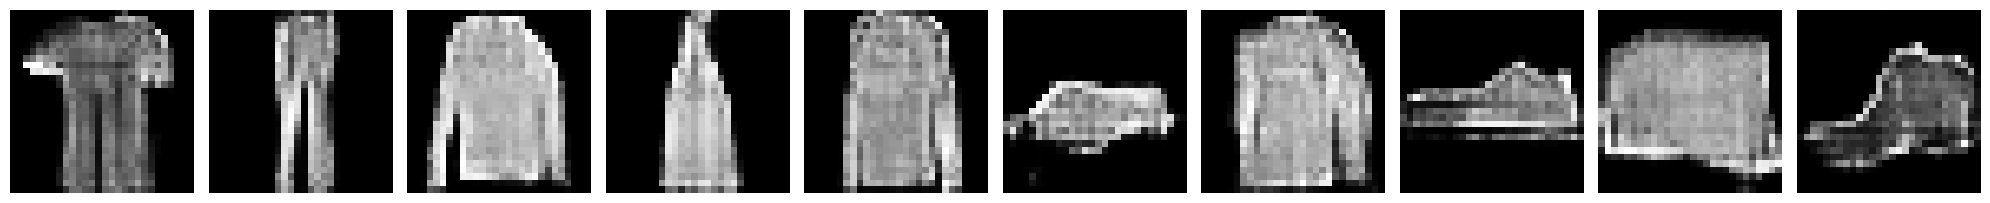

547/547 - 24s - loss: 1.4218 - d_loss: 0.6756 - g_loss: 0.7461 - 24s/epoch - 43ms/step
Epoch 27/100


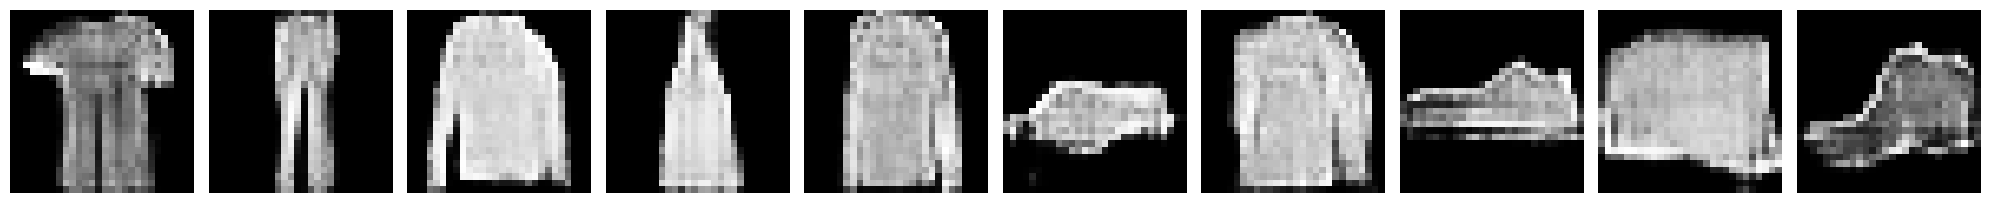

547/547 - 24s - loss: 1.4052 - d_loss: 0.6756 - g_loss: 0.7296 - 24s/epoch - 43ms/step
Epoch 28/100


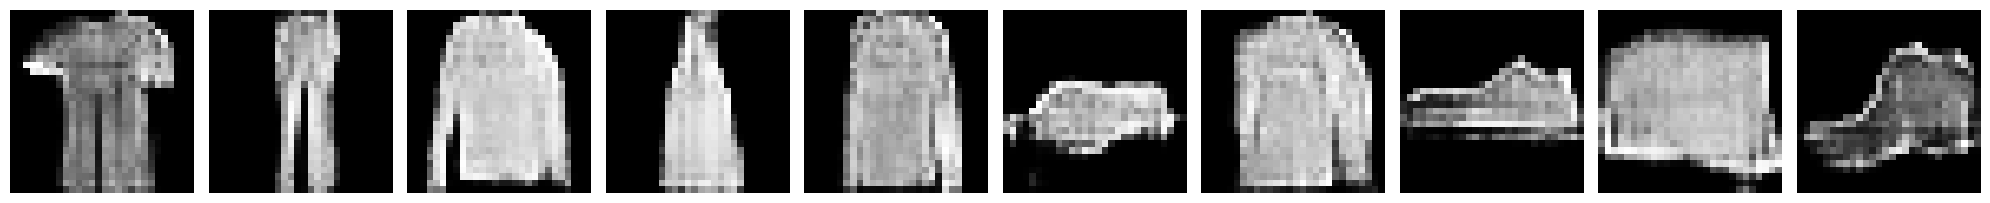

547/547 - 24s - loss: 1.4034 - d_loss: 0.6762 - g_loss: 0.7272 - 24s/epoch - 43ms/step
Epoch 29/100


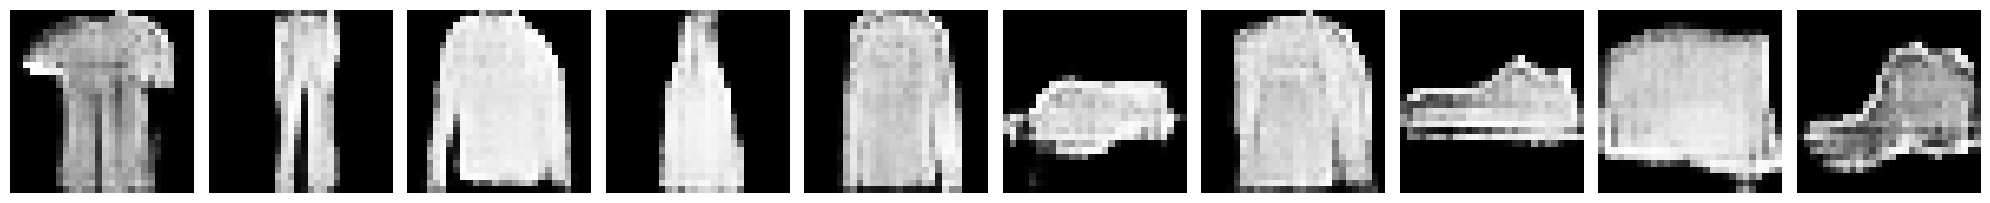

547/547 - 24s - loss: 1.4079 - d_loss: 0.6767 - g_loss: 0.7312 - 24s/epoch - 43ms/step
Epoch 30/100


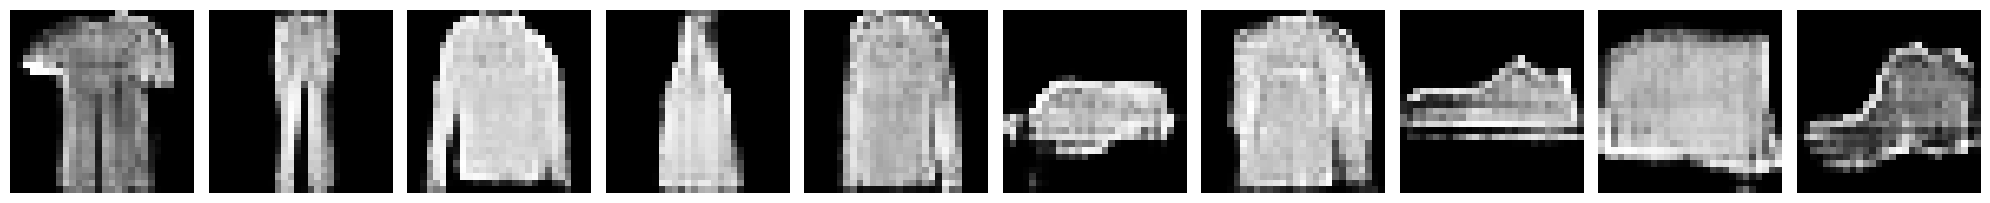

547/547 - 24s - loss: 1.4090 - d_loss: 0.6756 - g_loss: 0.7334 - 24s/epoch - 43ms/step
Epoch 31/100


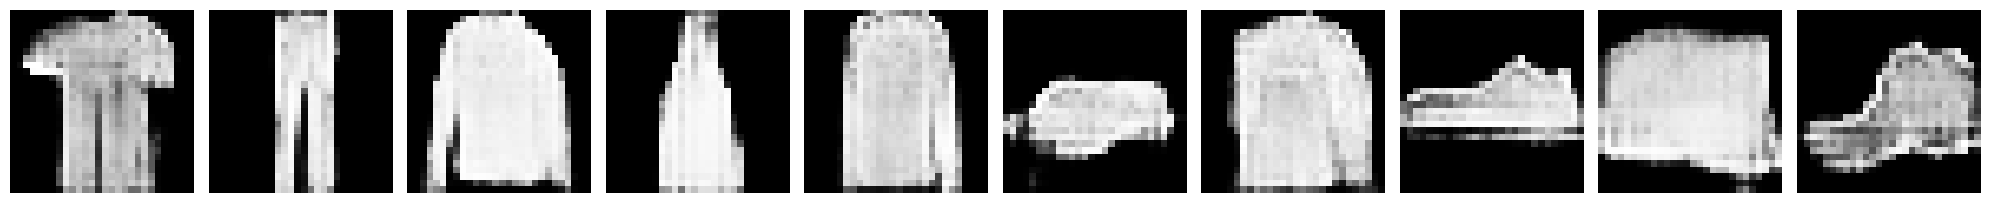

547/547 - 24s - loss: 1.4127 - d_loss: 0.6744 - g_loss: 0.7383 - 24s/epoch - 43ms/step
Epoch 32/100


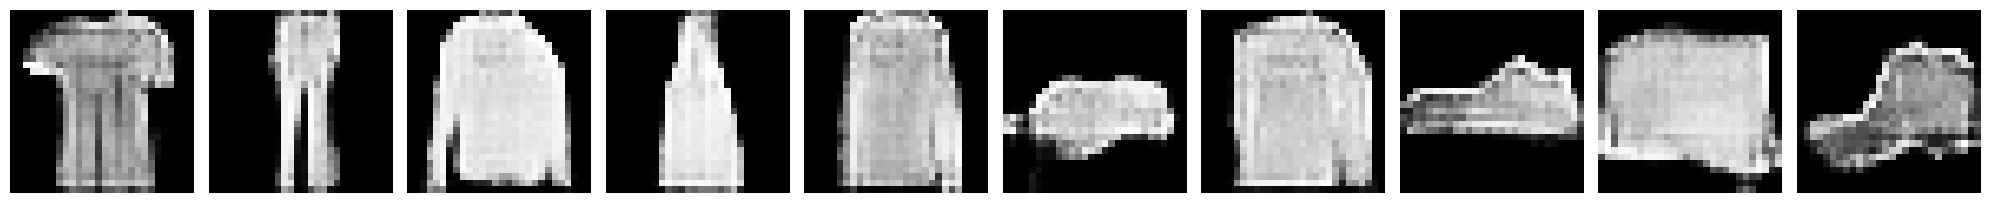

547/547 - 24s - loss: 1.4092 - d_loss: 0.6739 - g_loss: 0.7353 - 24s/epoch - 43ms/step
Epoch 33/100


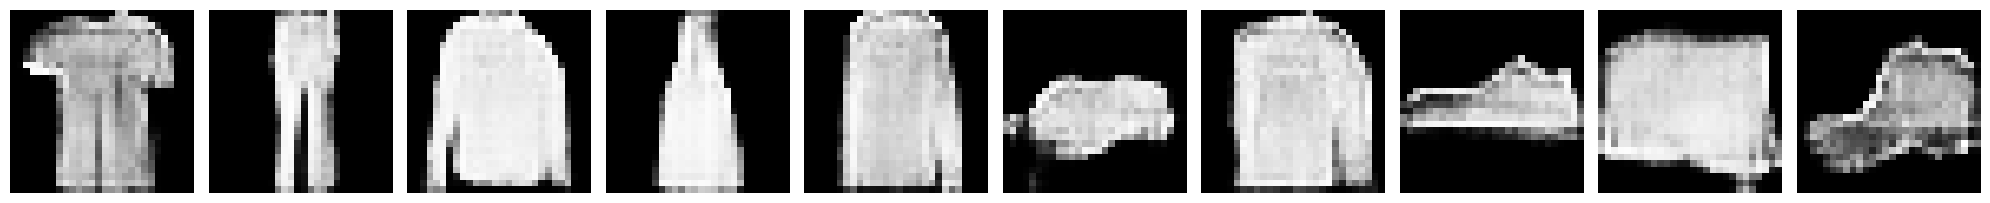

547/547 - 24s - loss: 1.3971 - d_loss: 0.6737 - g_loss: 0.7234 - 24s/epoch - 44ms/step
Epoch 34/100


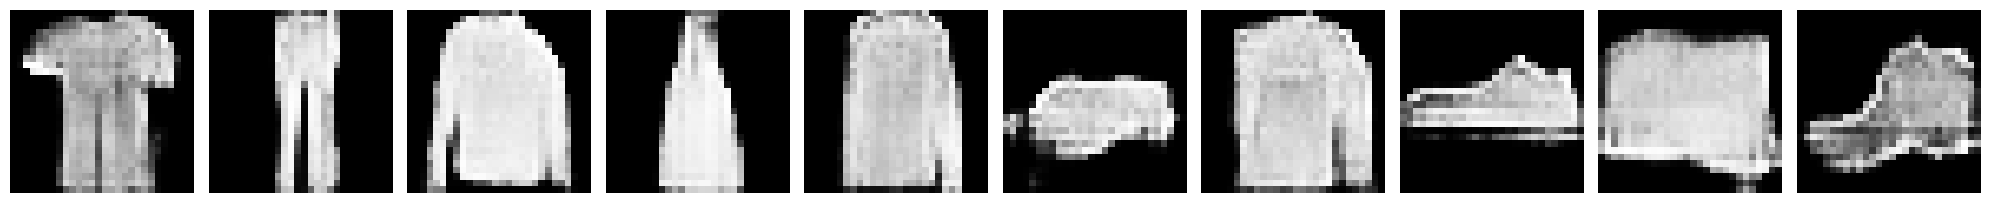

547/547 - 24s - loss: 1.4253 - d_loss: 0.6747 - g_loss: 0.7505 - 24s/epoch - 43ms/step
Epoch 35/100


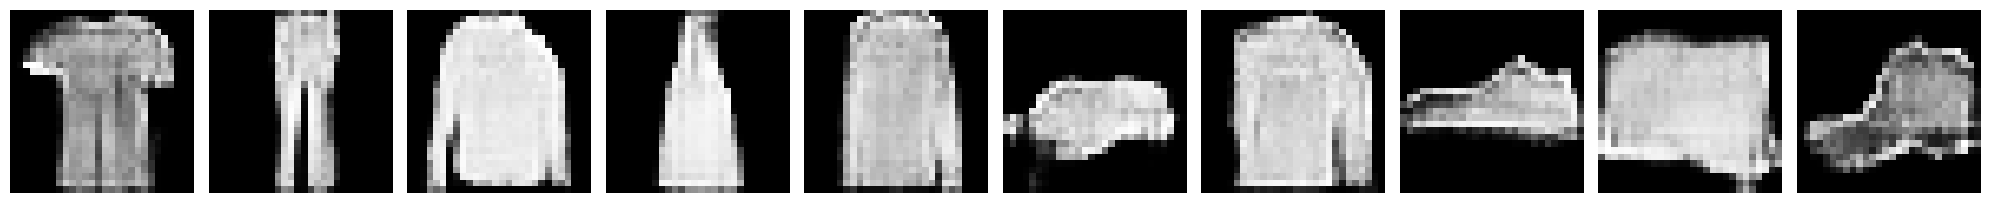

547/547 - 24s - loss: 1.4026 - d_loss: 0.6750 - g_loss: 0.7275 - 24s/epoch - 43ms/step
Epoch 36/100


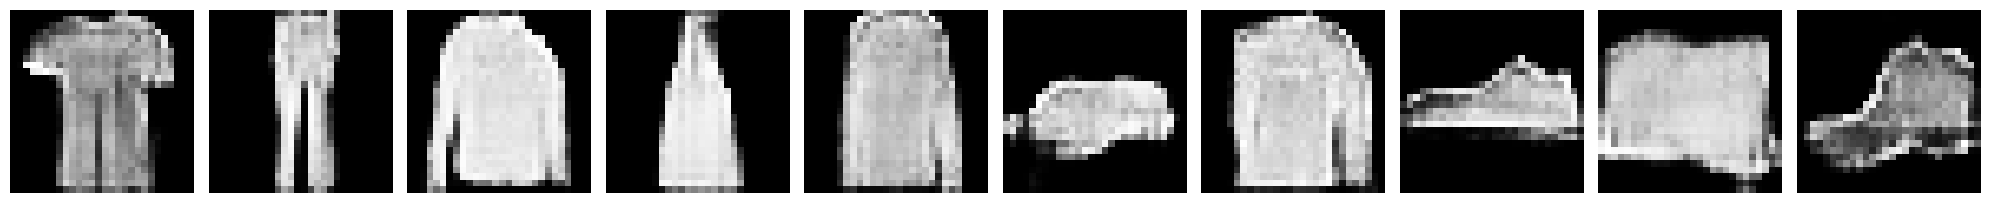

547/547 - 24s - loss: 1.3944 - d_loss: 0.6742 - g_loss: 0.7202 - 24s/epoch - 43ms/step
Epoch 37/100


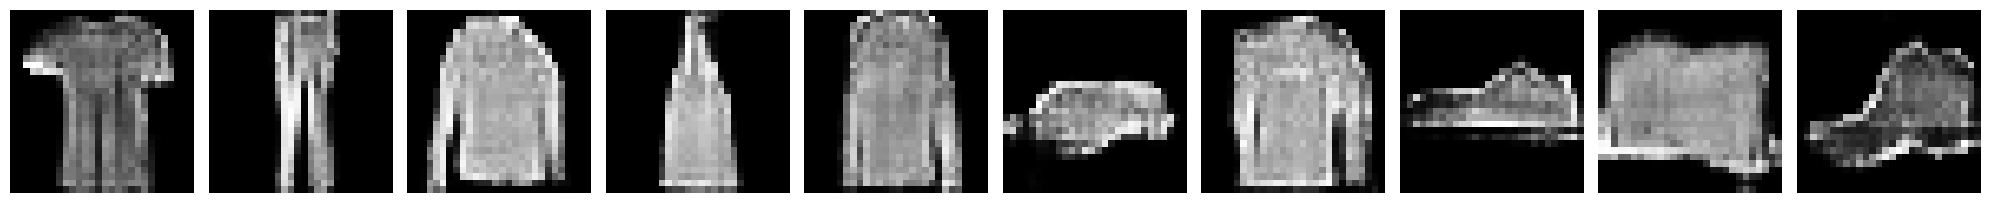

547/547 - 24s - loss: 1.4248 - d_loss: 0.6740 - g_loss: 0.7507 - 24s/epoch - 43ms/step
Epoch 38/100


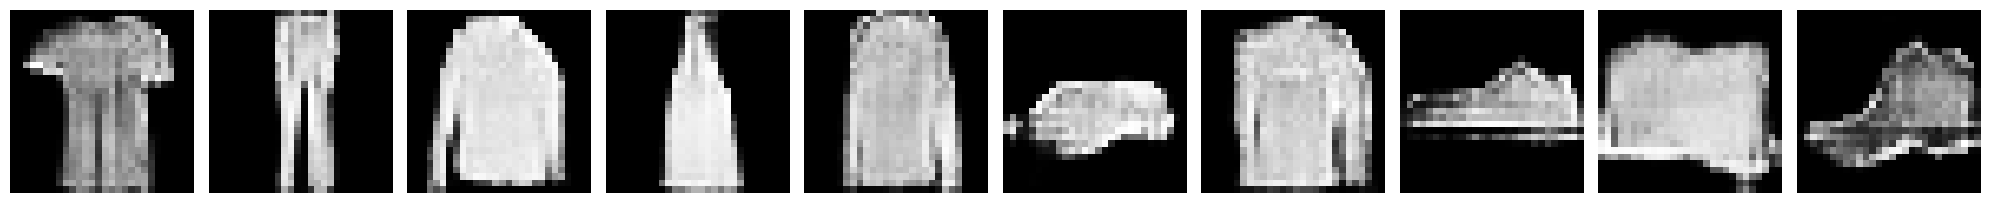

547/547 - 24s - loss: 1.4057 - d_loss: 0.6739 - g_loss: 0.7318 - 24s/epoch - 43ms/step
Epoch 39/100


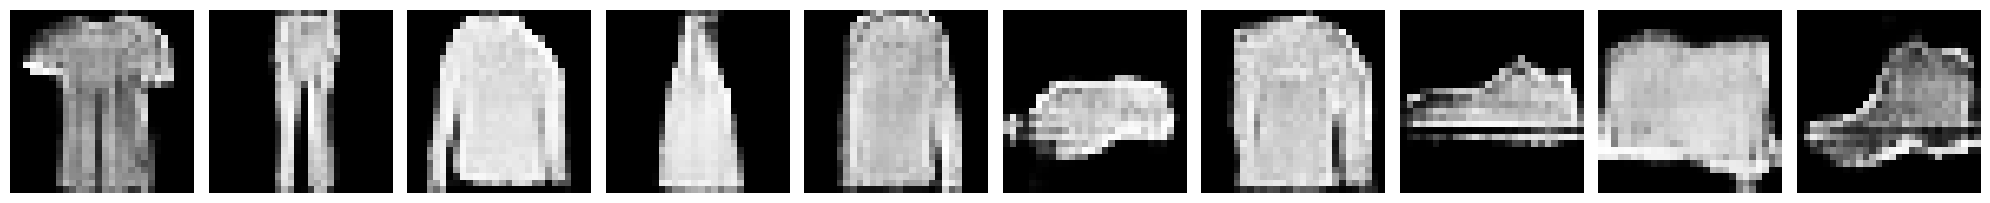

547/547 - 24s - loss: 1.3943 - d_loss: 0.6745 - g_loss: 0.7199 - 24s/epoch - 43ms/step
Epoch 40/100


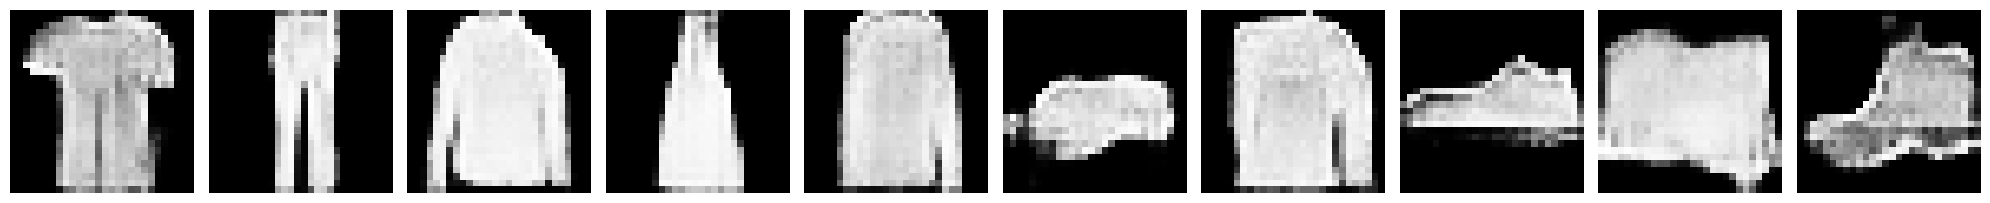

547/547 - 24s - loss: 1.4041 - d_loss: 0.6748 - g_loss: 0.7293 - 24s/epoch - 44ms/step
Epoch 41/100


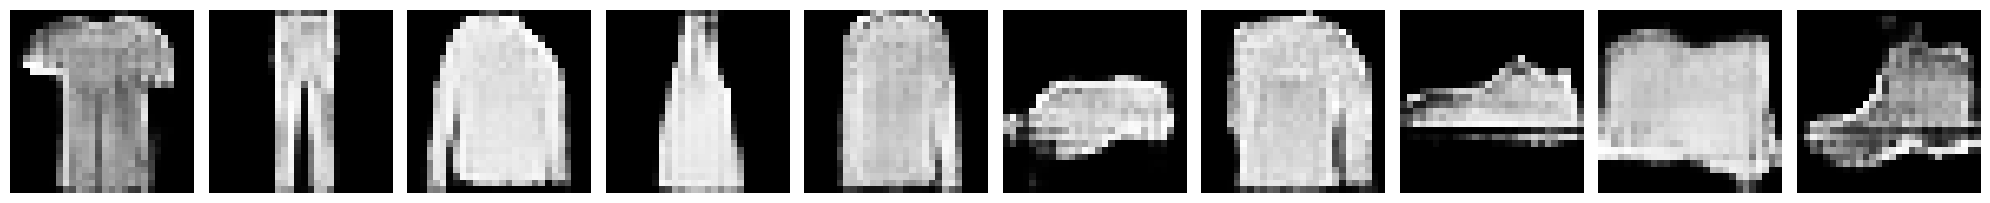

547/547 - 24s - loss: 1.4262 - d_loss: 0.6743 - g_loss: 0.7519 - 24s/epoch - 44ms/step
Epoch 42/100


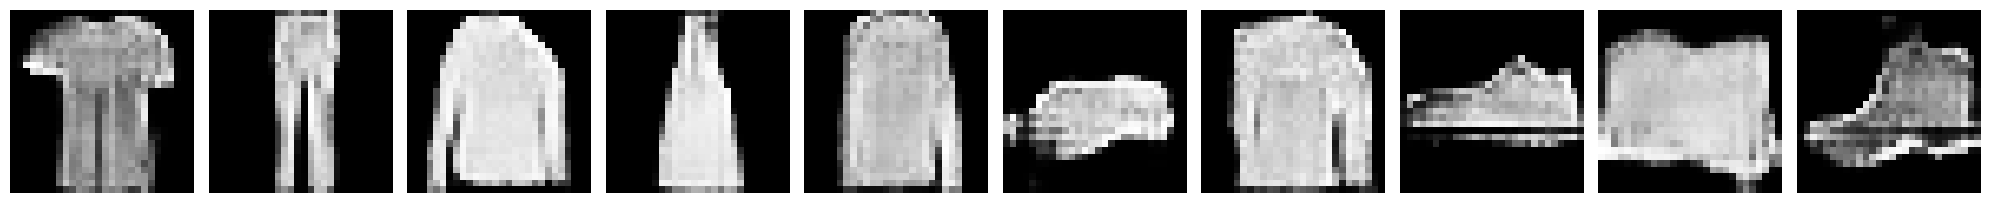

547/547 - 24s - loss: 1.3942 - d_loss: 0.6752 - g_loss: 0.7190 - 24s/epoch - 43ms/step
Epoch 43/100


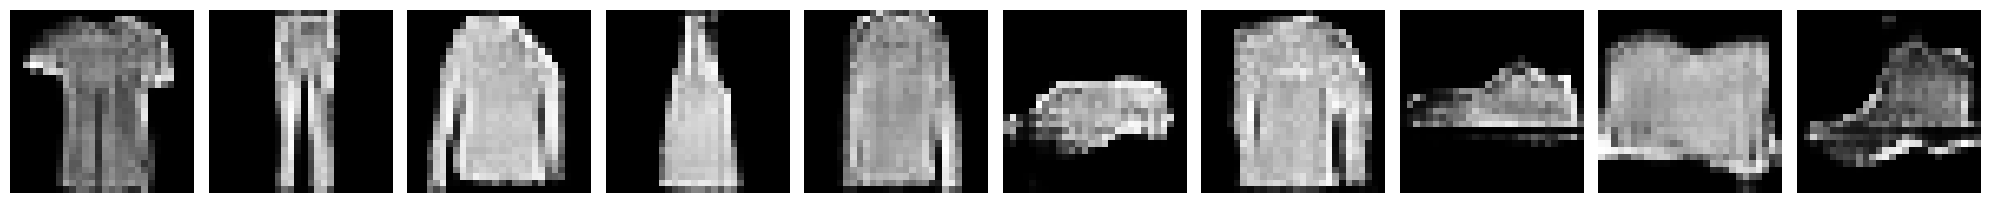

547/547 - 24s - loss: 1.4022 - d_loss: 0.6758 - g_loss: 0.7265 - 24s/epoch - 43ms/step
Epoch 44/100


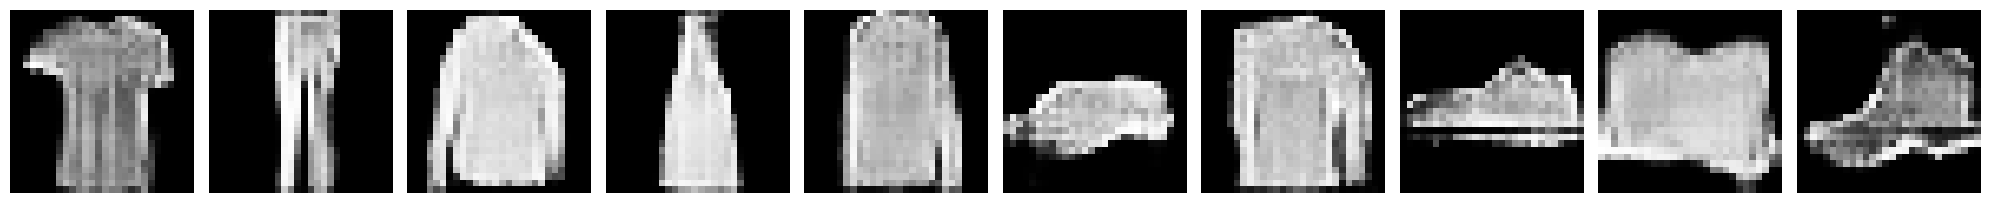

547/547 - 24s - loss: 1.4182 - d_loss: 0.6752 - g_loss: 0.7429 - 24s/epoch - 43ms/step
Epoch 45/100


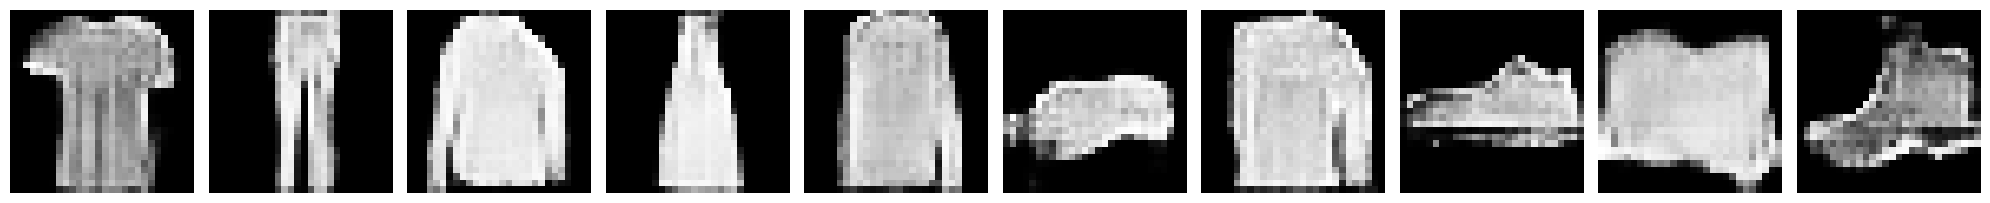

547/547 - 24s - loss: 1.3965 - d_loss: 0.6755 - g_loss: 0.7209 - 24s/epoch - 44ms/step
Epoch 46/100


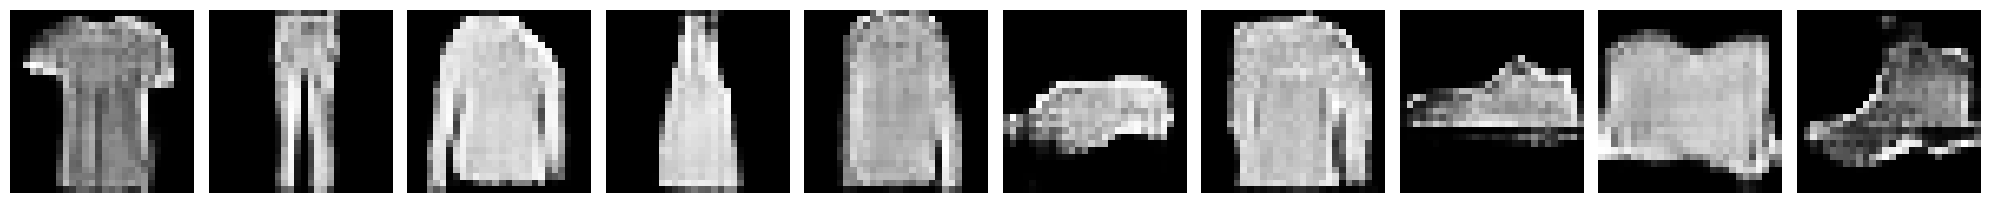

547/547 - 24s - loss: 1.3939 - d_loss: 0.6759 - g_loss: 0.7180 - 24s/epoch - 43ms/step
Epoch 47/100


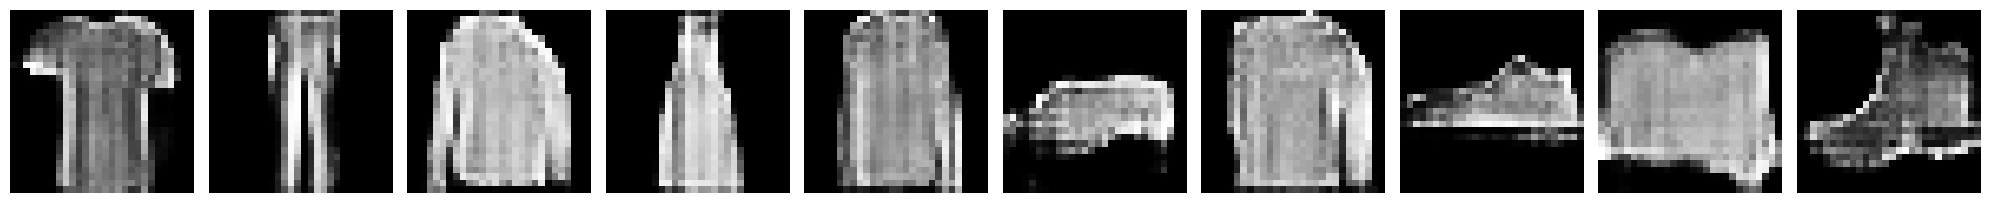

547/547 - 24s - loss: 1.4359 - d_loss: 0.6743 - g_loss: 0.7616 - 24s/epoch - 43ms/step
Epoch 48/100


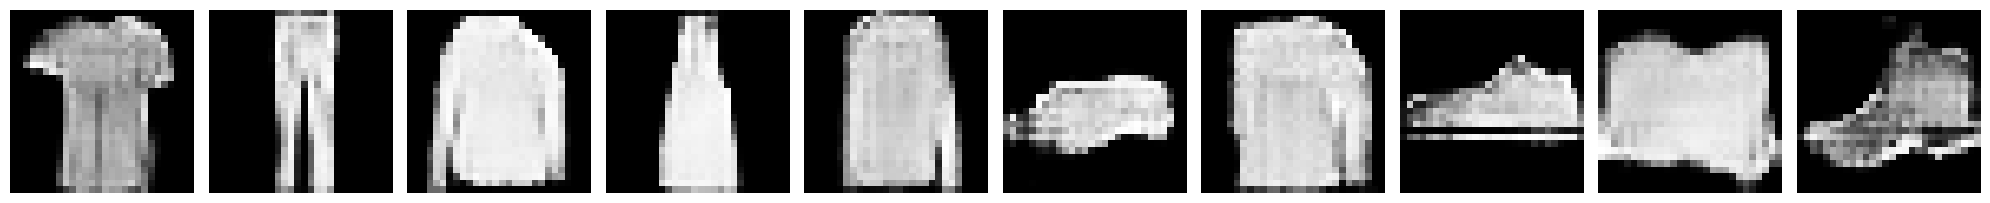

547/547 - 24s - loss: 1.4043 - d_loss: 0.6740 - g_loss: 0.7303 - 24s/epoch - 43ms/step
Epoch 49/100


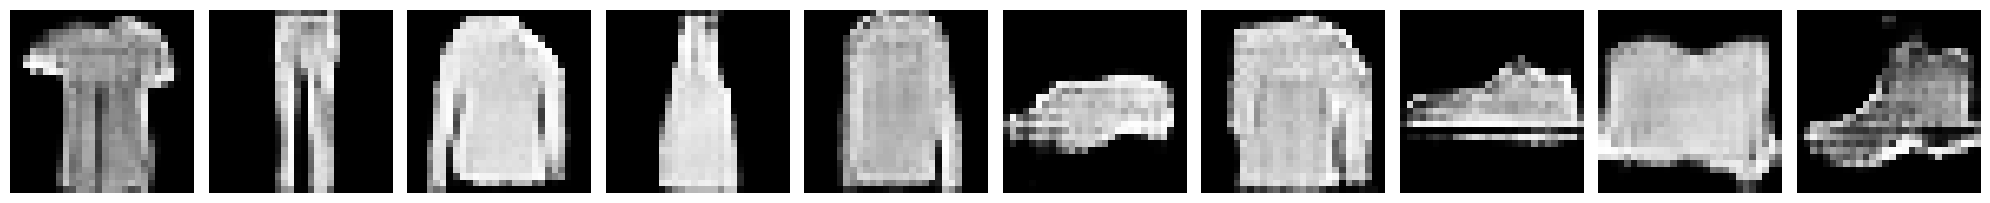

547/547 - 24s - loss: 1.3954 - d_loss: 0.6768 - g_loss: 0.7185 - 24s/epoch - 44ms/step
Epoch 50/100


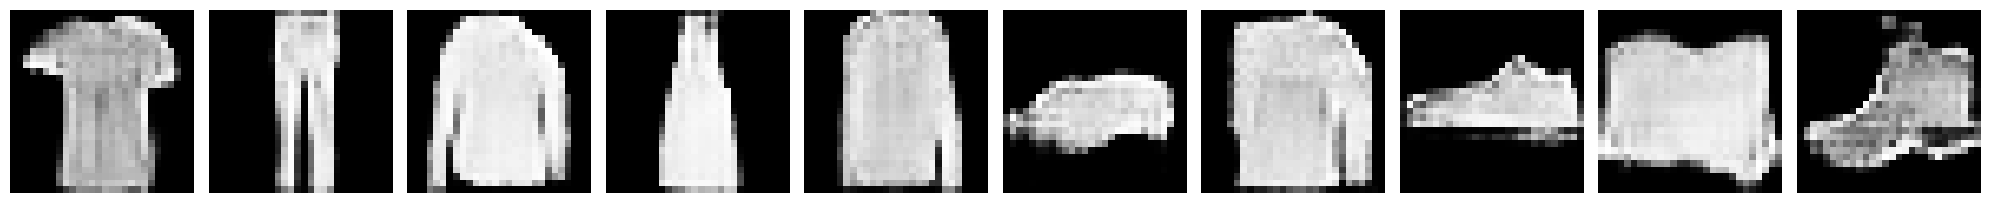

547/547 - 24s - loss: 1.4077 - d_loss: 0.6766 - g_loss: 0.7311 - 24s/epoch - 43ms/step
Epoch 51/100


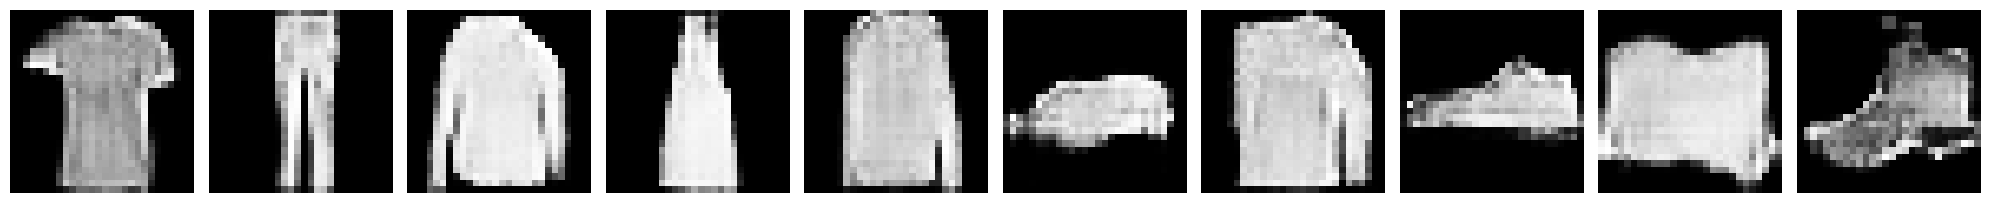

547/547 - 24s - loss: 1.4077 - d_loss: 0.6766 - g_loss: 0.7311 - 24s/epoch - 43ms/step
Epoch 52/100


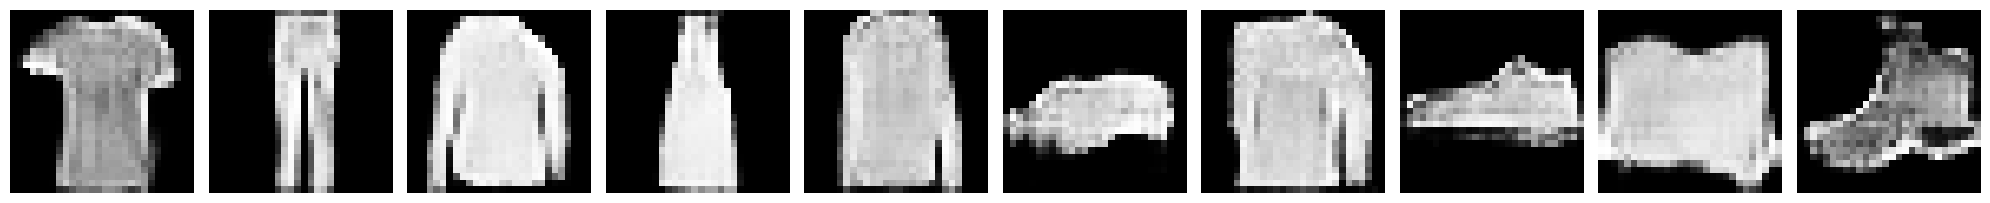

547/547 - 24s - loss: 1.3960 - d_loss: 0.6763 - g_loss: 0.7197 - 24s/epoch - 43ms/step
Epoch 53/100


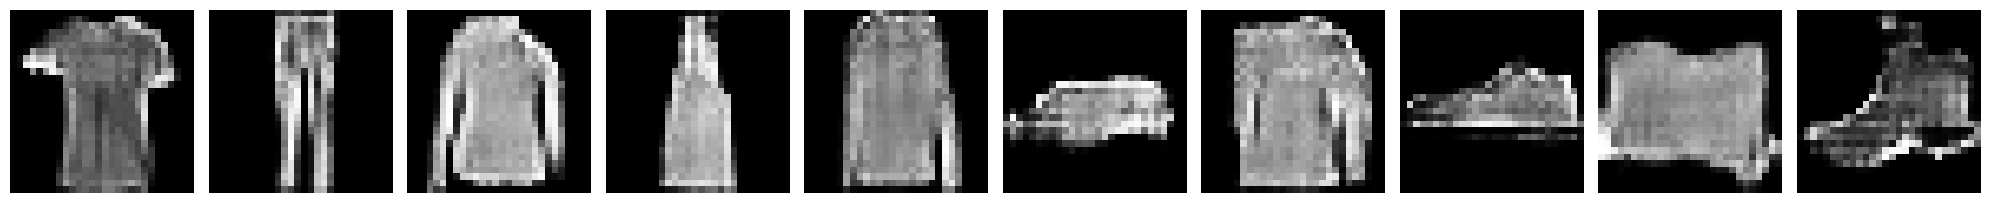

547/547 - 24s - loss: 1.4068 - d_loss: 0.6765 - g_loss: 0.7303 - 24s/epoch - 43ms/step
Epoch 54/100


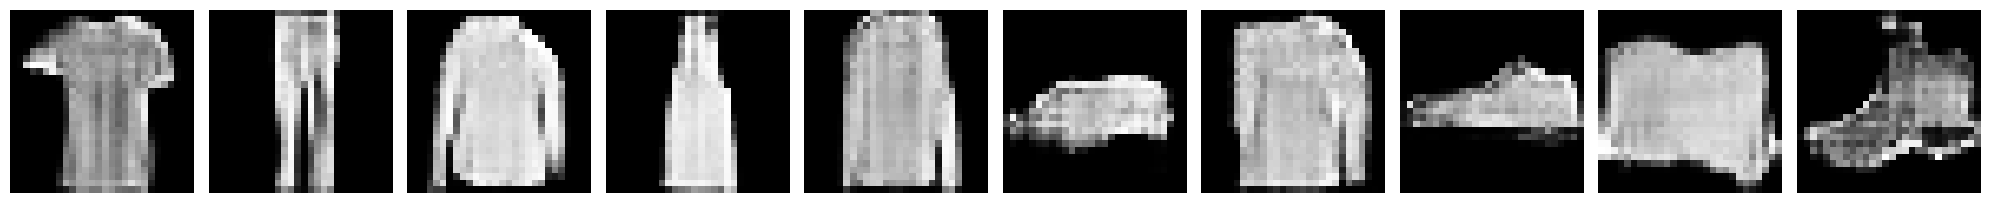

547/547 - 24s - loss: 1.4221 - d_loss: 0.6738 - g_loss: 0.7483 - 24s/epoch - 43ms/step
Epoch 55/100


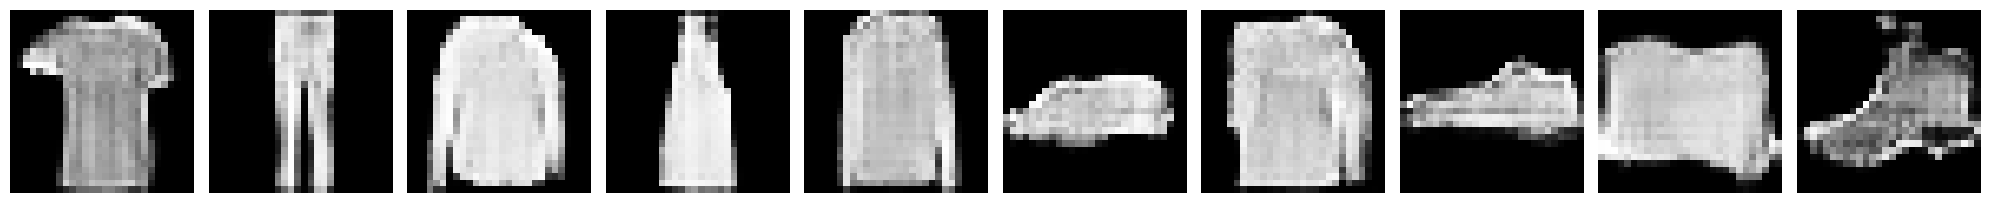

547/547 - 24s - loss: 1.4080 - d_loss: 0.6733 - g_loss: 0.7347 - 24s/epoch - 43ms/step
Epoch 56/100


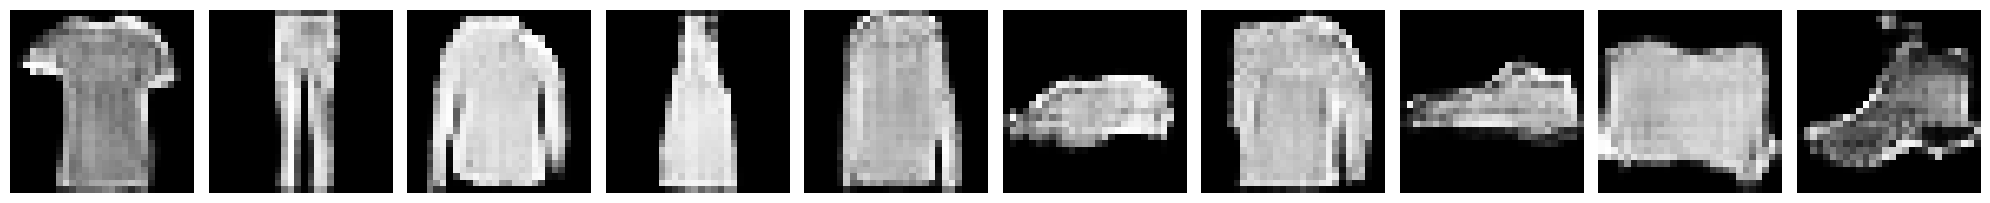

547/547 - 24s - loss: 1.3944 - d_loss: 0.6753 - g_loss: 0.7191 - 24s/epoch - 43ms/step
Epoch 57/100


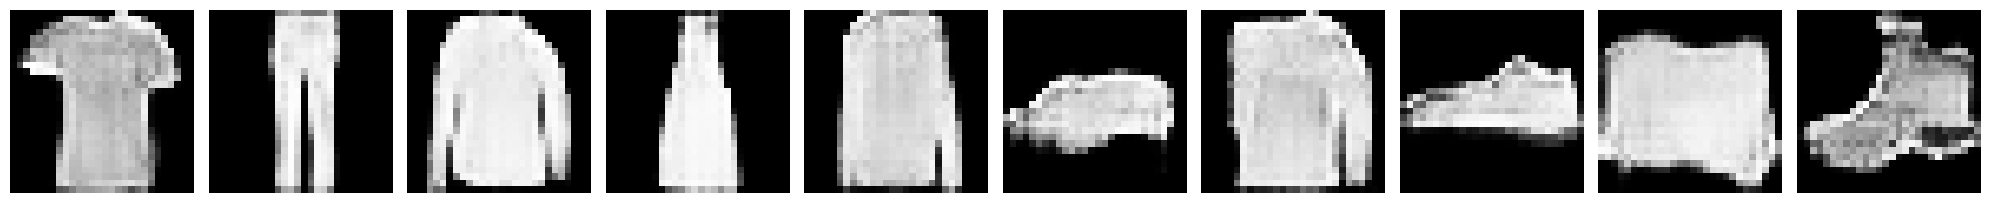

547/547 - 24s - loss: 1.4163 - d_loss: 0.6760 - g_loss: 0.7402 - 24s/epoch - 44ms/step
Epoch 58/100


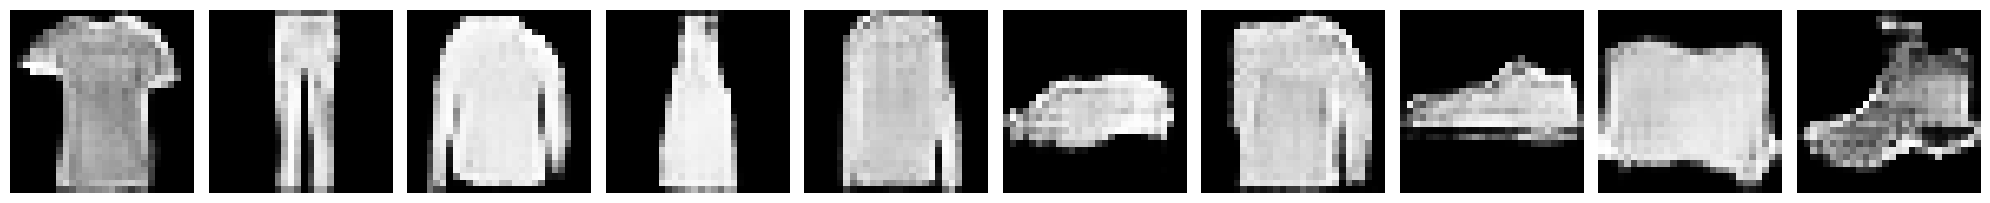

547/547 - 24s - loss: 1.4035 - d_loss: 0.6748 - g_loss: 0.7287 - 24s/epoch - 44ms/step
Epoch 59/100


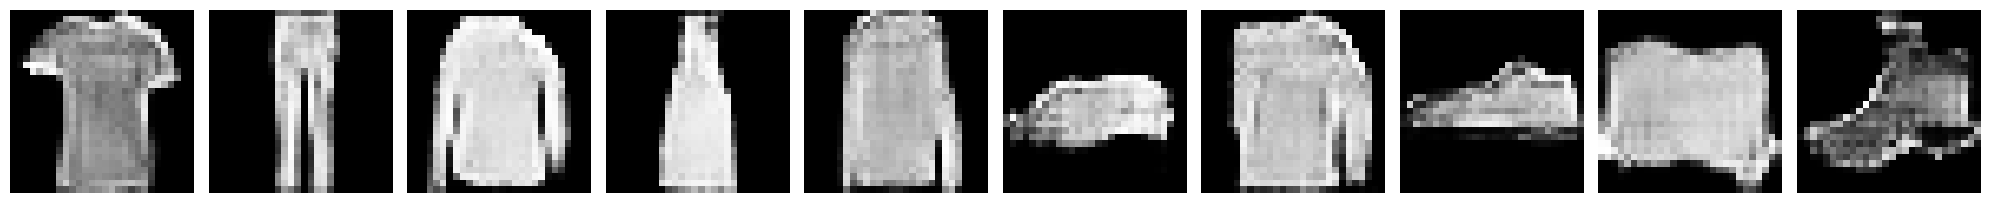

547/547 - 24s - loss: 1.3927 - d_loss: 0.6745 - g_loss: 0.7182 - 24s/epoch - 43ms/step
Epoch 60/100


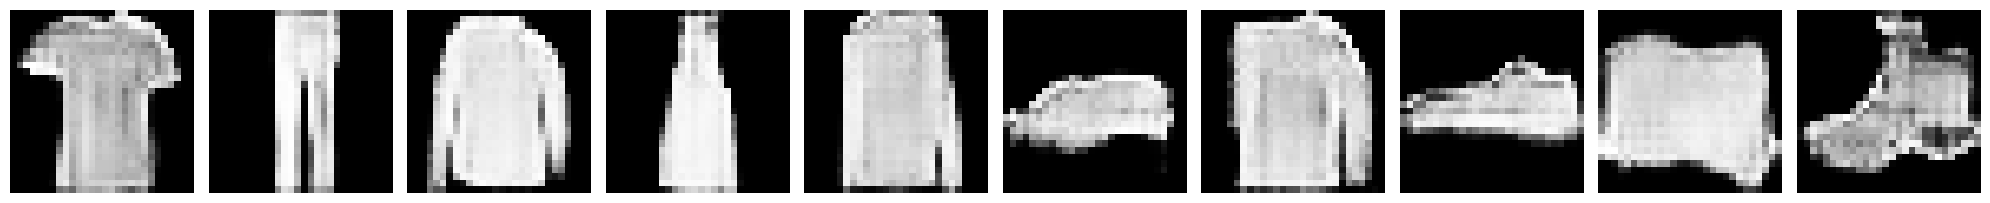

547/547 - 24s - loss: 1.4237 - d_loss: 0.6738 - g_loss: 0.7499 - 24s/epoch - 43ms/step
Epoch 61/100


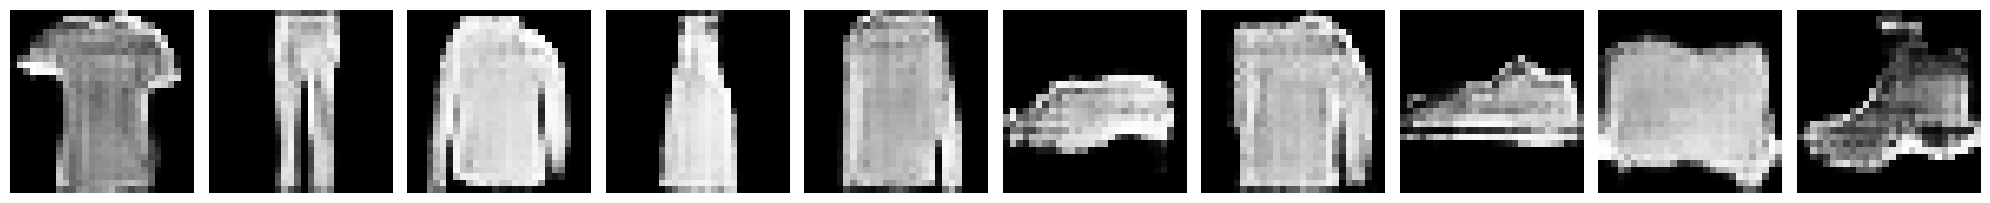

547/547 - 24s - loss: 1.4108 - d_loss: 0.6732 - g_loss: 0.7376 - 24s/epoch - 43ms/step
Epoch 62/100


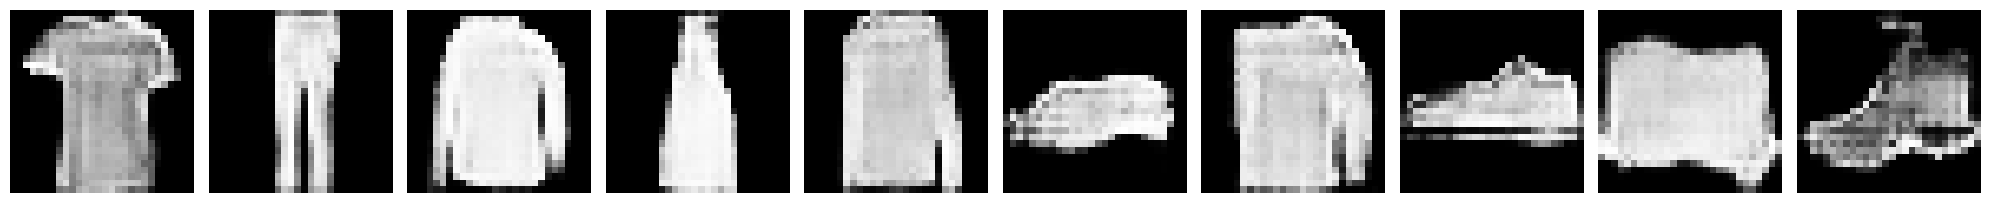

547/547 - 24s - loss: 1.3974 - d_loss: 0.6729 - g_loss: 0.7245 - 24s/epoch - 43ms/step
Epoch 63/100


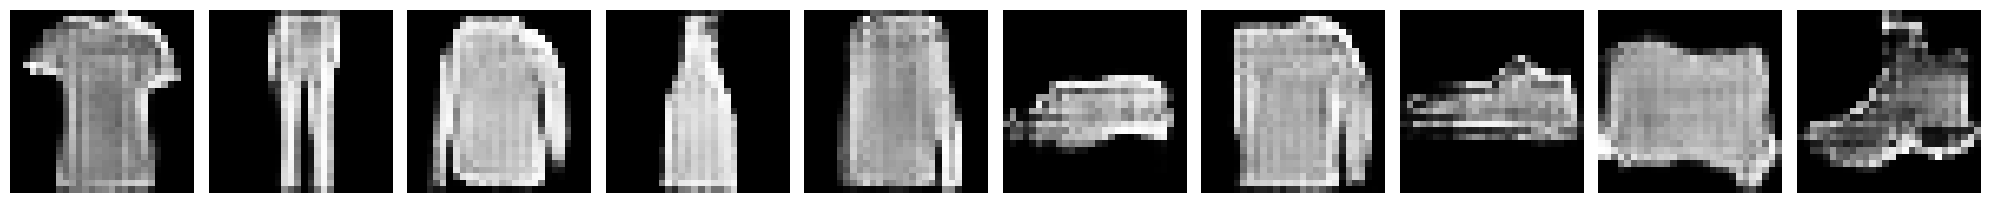

547/547 - 24s - loss: 1.4090 - d_loss: 0.6707 - g_loss: 0.7383 - 24s/epoch - 43ms/step
Epoch 64/100


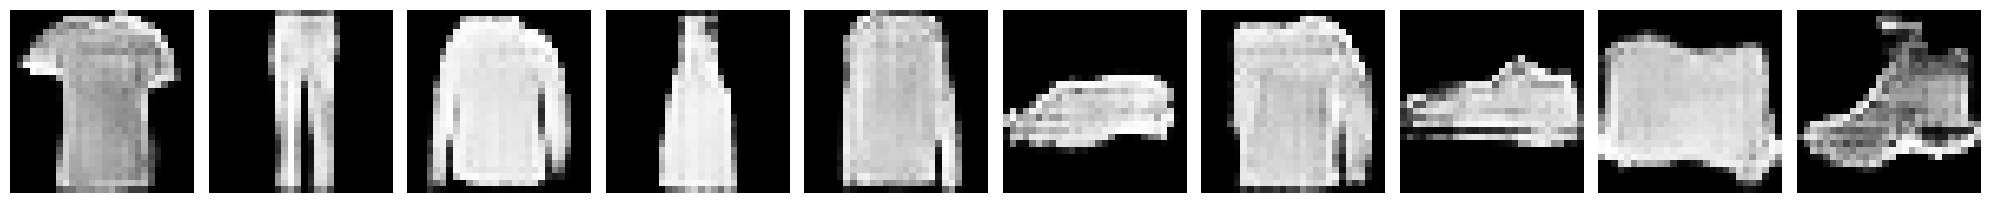

547/547 - 24s - loss: 1.4099 - d_loss: 0.6750 - g_loss: 0.7348 - 24s/epoch - 44ms/step
Epoch 65/100


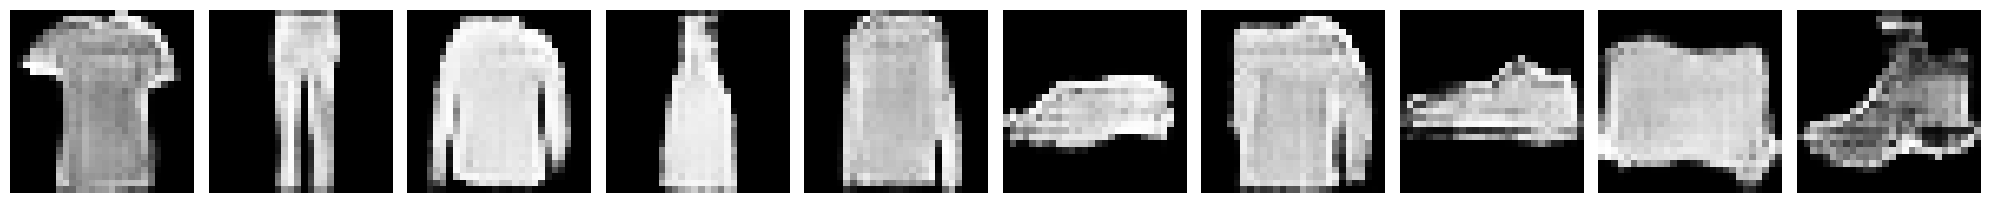

547/547 - 24s - loss: 1.4014 - d_loss: 0.6744 - g_loss: 0.7270 - 24s/epoch - 44ms/step
Epoch 66/100


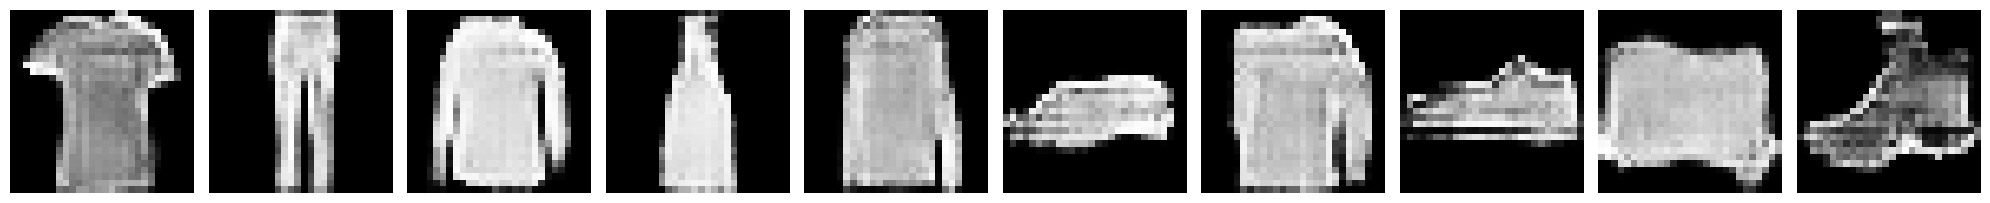

547/547 - 24s - loss: 1.3946 - d_loss: 0.6742 - g_loss: 0.7204 - 24s/epoch - 43ms/step
Epoch 67/100


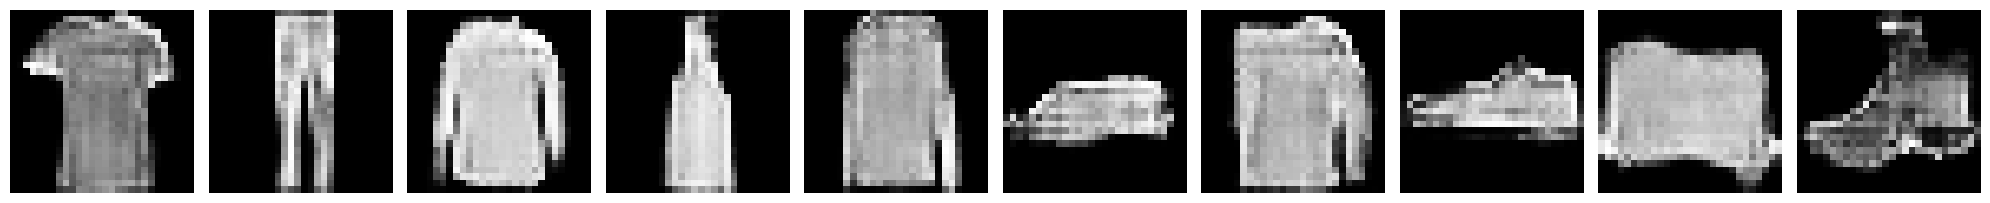

547/547 - 24s - loss: 1.4294 - d_loss: 0.6733 - g_loss: 0.7562 - 24s/epoch - 43ms/step
Epoch 68/100


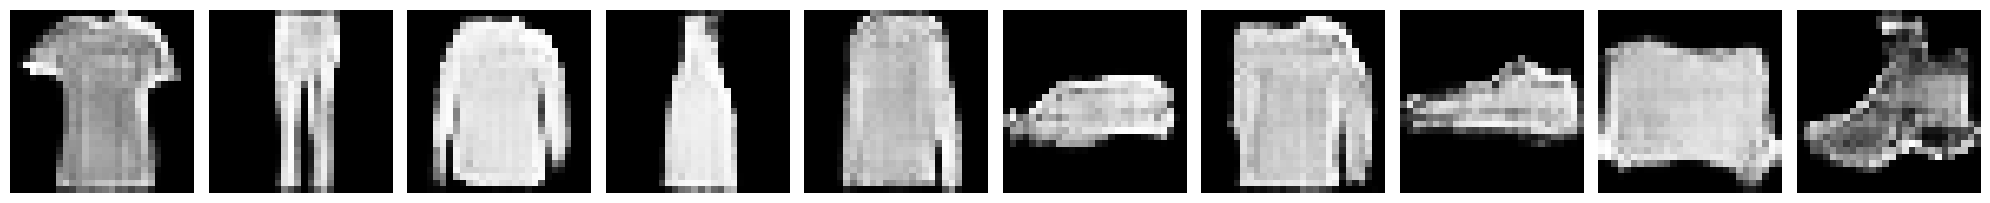

547/547 - 24s - loss: 1.3978 - d_loss: 0.6738 - g_loss: 0.7240 - 24s/epoch - 43ms/step
Epoch 69/100


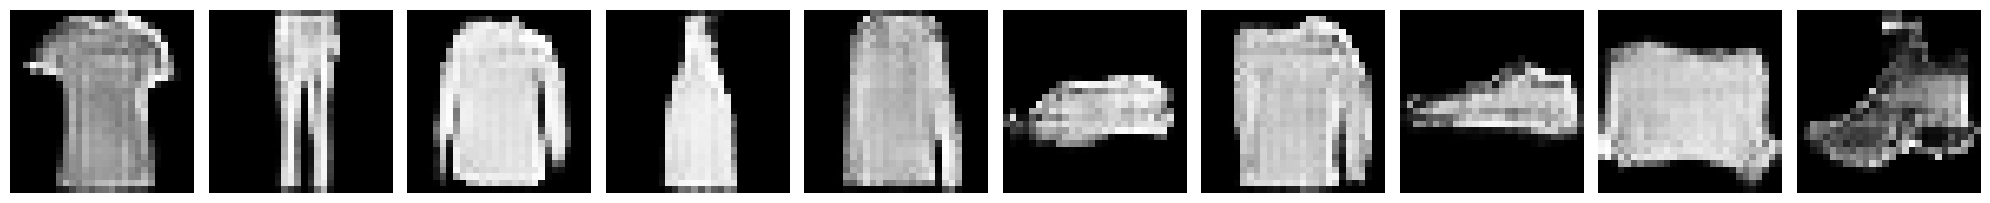

547/547 - 24s - loss: 1.3966 - d_loss: 0.6740 - g_loss: 0.7226 - 24s/epoch - 44ms/step
Epoch 70/100


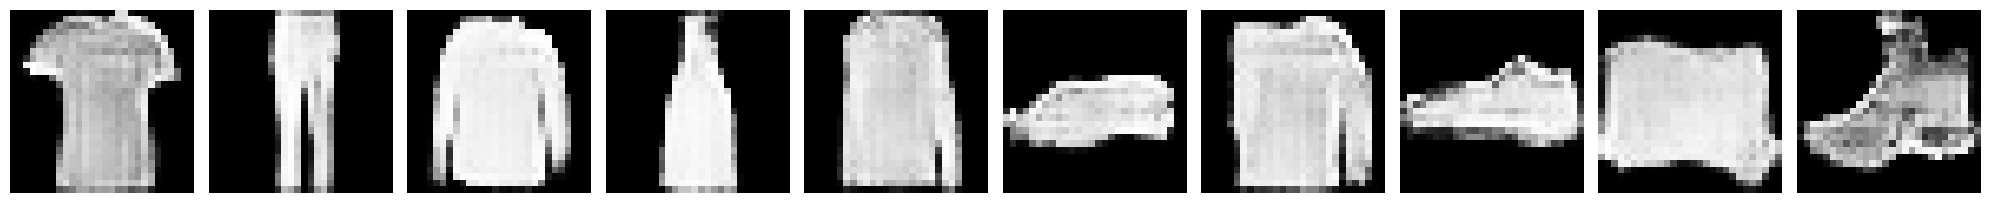

547/547 - 24s - loss: 1.4156 - d_loss: 0.6753 - g_loss: 0.7403 - 24s/epoch - 43ms/step
Epoch 71/100


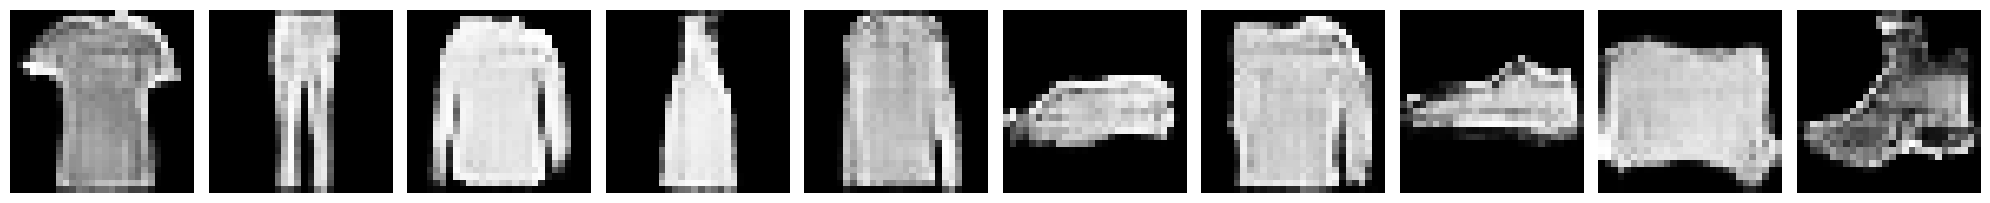

547/547 - 24s - loss: 1.4020 - d_loss: 0.6743 - g_loss: 0.7277 - 24s/epoch - 43ms/step
Epoch 72/100


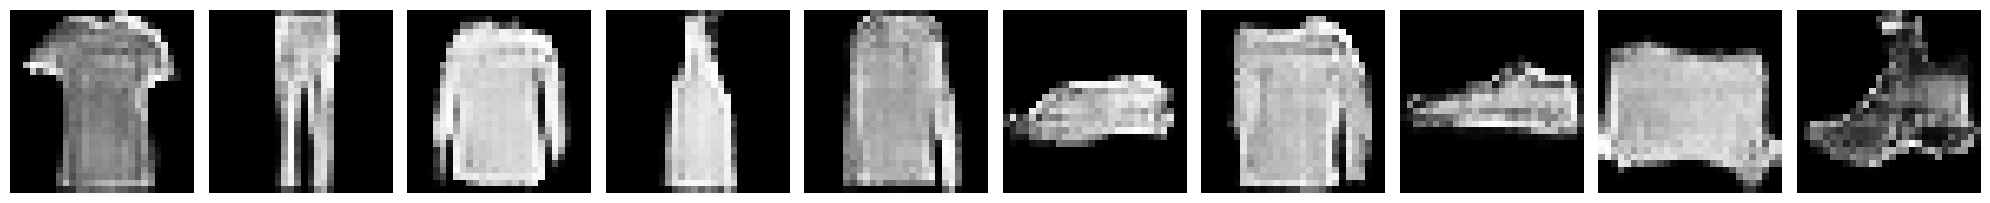

547/547 - 24s - loss: 1.3957 - d_loss: 0.6747 - g_loss: 0.7209 - 24s/epoch - 43ms/step
Epoch 73/100


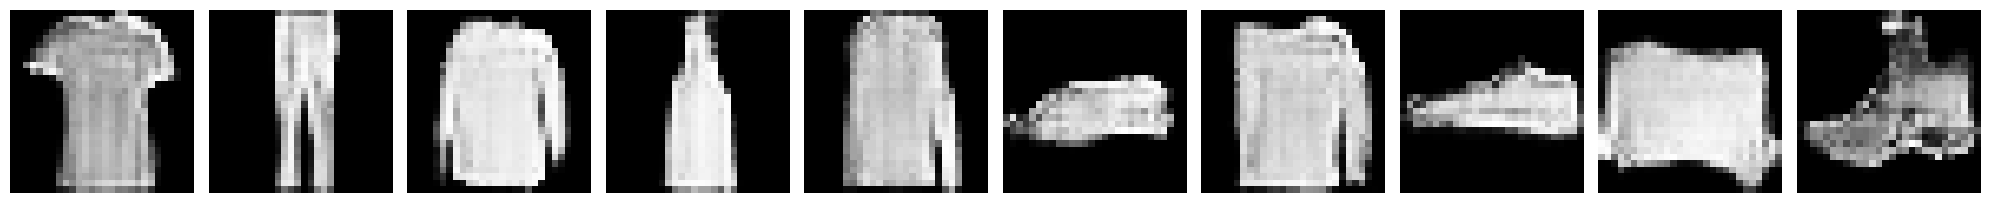

547/547 - 24s - loss: 1.4220 - d_loss: 0.6728 - g_loss: 0.7493 - 24s/epoch - 44ms/step
Epoch 74/100


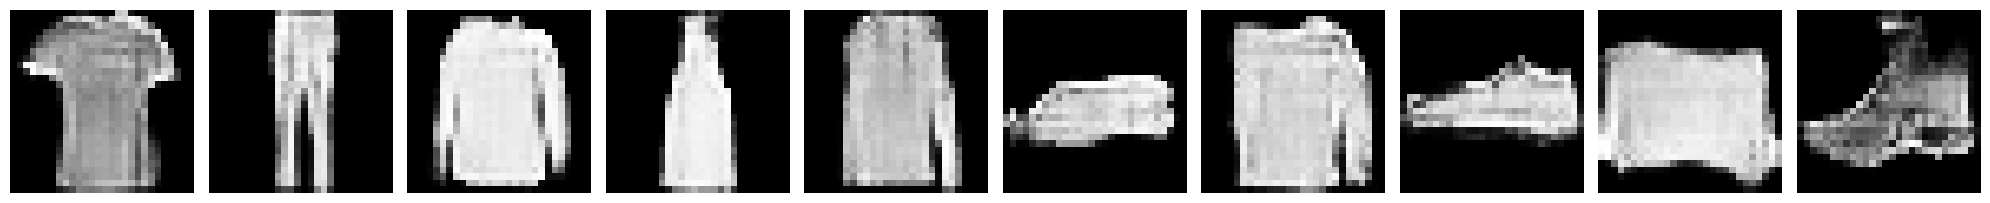

547/547 - 24s - loss: 1.4090 - d_loss: 0.6733 - g_loss: 0.7357 - 24s/epoch - 43ms/step
Epoch 75/100


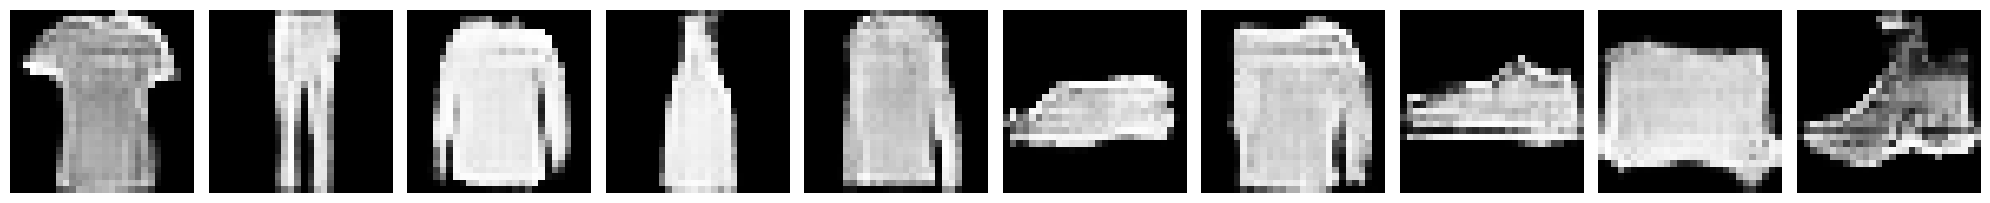

547/547 - 24s - loss: 1.3932 - d_loss: 0.6750 - g_loss: 0.7182 - 24s/epoch - 44ms/step
Epoch 76/100


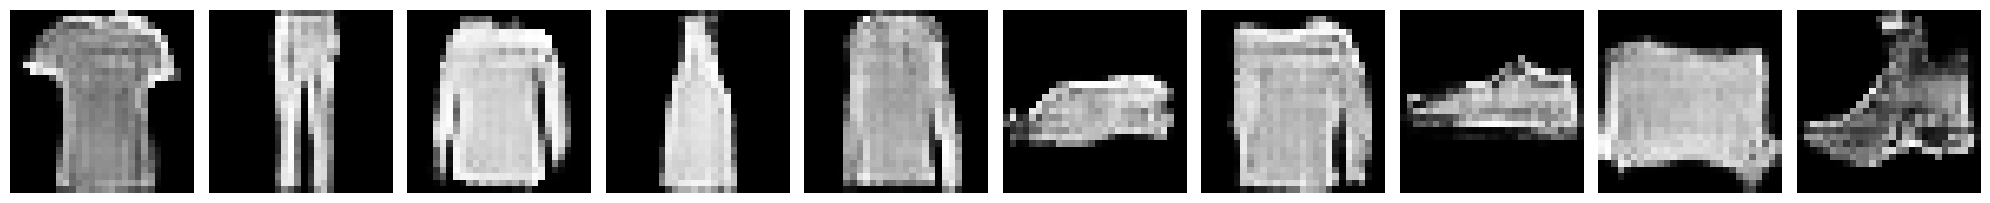

547/547 - 24s - loss: 1.4047 - d_loss: 0.6742 - g_loss: 0.7305 - 24s/epoch - 43ms/step
Epoch 77/100


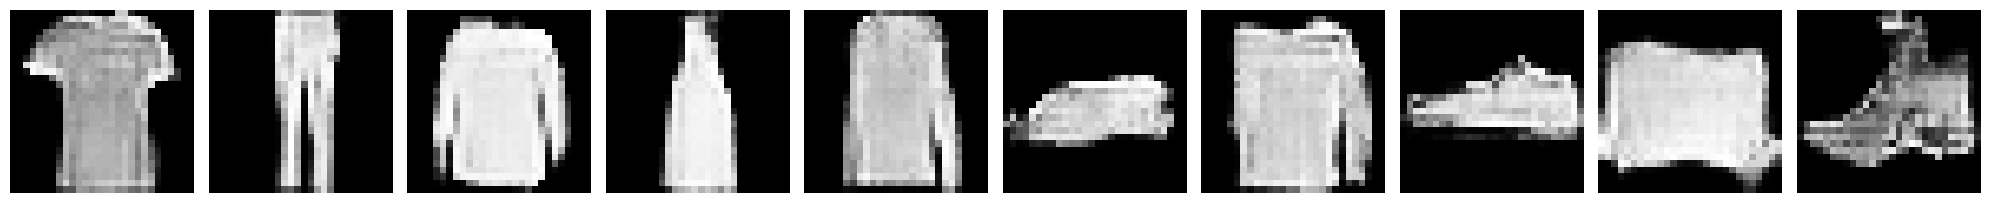

547/547 - 24s - loss: 1.4193 - d_loss: 0.6751 - g_loss: 0.7442 - 24s/epoch - 43ms/step
Epoch 78/100


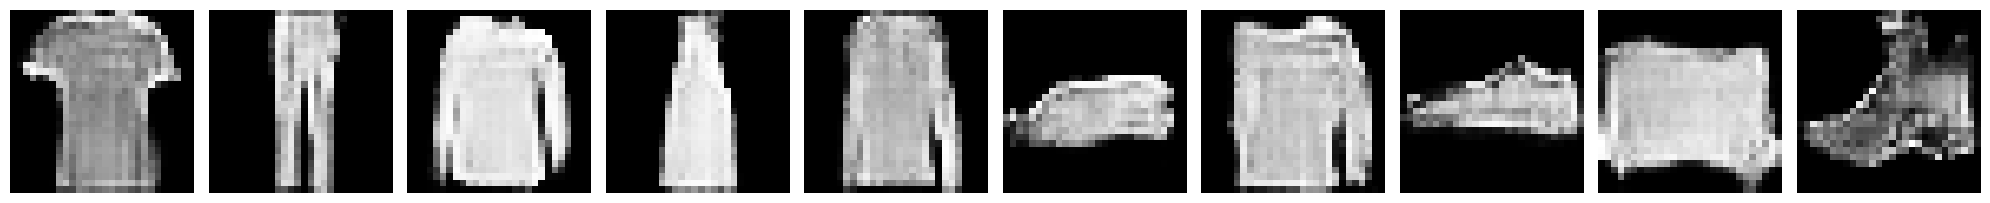

547/547 - 24s - loss: 1.3938 - d_loss: 0.6753 - g_loss: 0.7185 - 24s/epoch - 43ms/step
Epoch 79/100


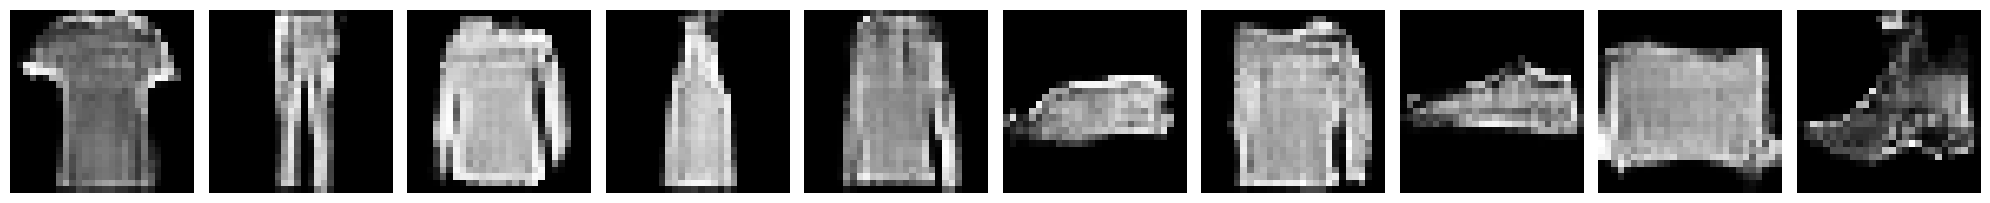

547/547 - 24s - loss: 1.3984 - d_loss: 0.6754 - g_loss: 0.7230 - 24s/epoch - 43ms/step
Epoch 80/100


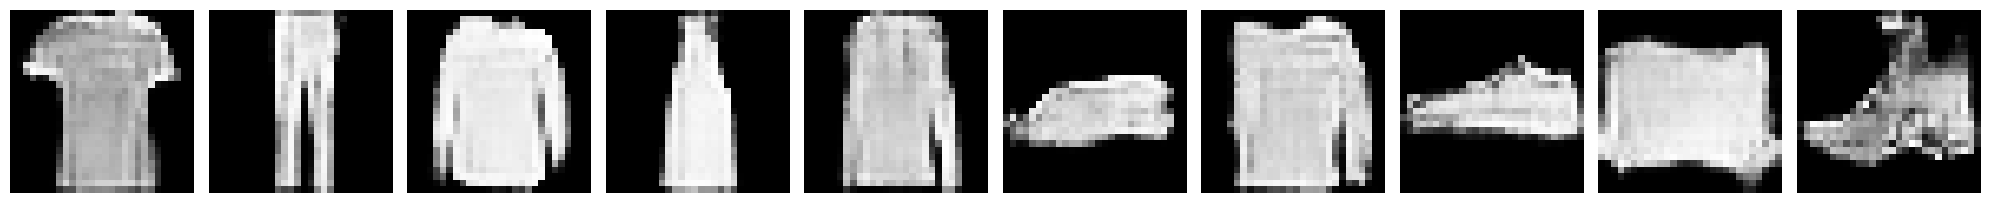

547/547 - 24s - loss: 1.4225 - d_loss: 0.6748 - g_loss: 0.7477 - 24s/epoch - 43ms/step
Epoch 81/100


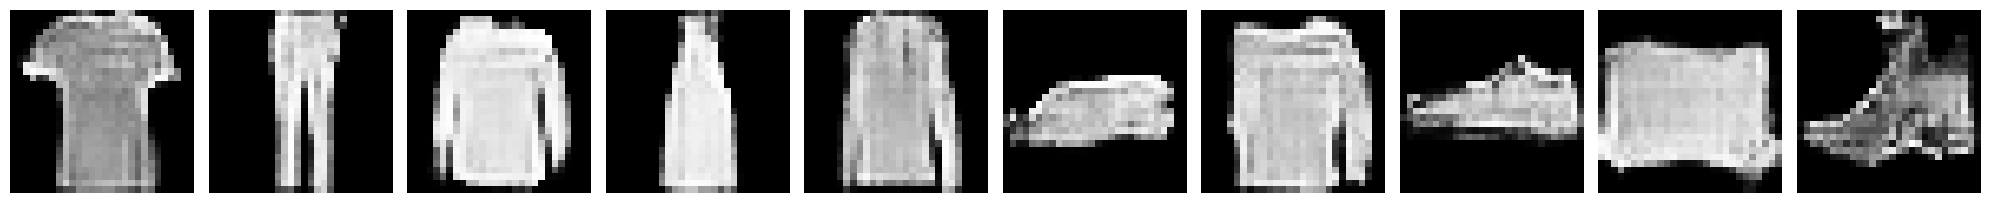

547/547 - 24s - loss: 1.3951 - d_loss: 0.6757 - g_loss: 0.7195 - 24s/epoch - 44ms/step
Epoch 82/100


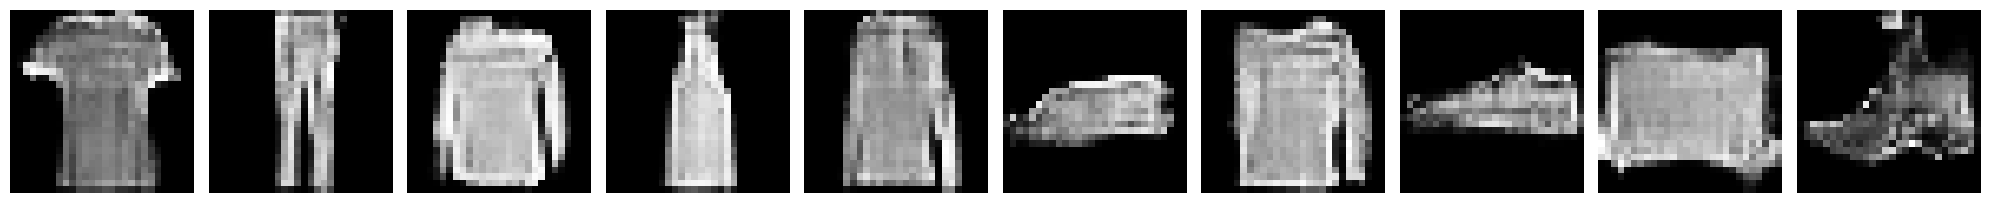

547/547 - 24s - loss: 1.3991 - d_loss: 0.6762 - g_loss: 0.7229 - 24s/epoch - 43ms/step
Epoch 83/100


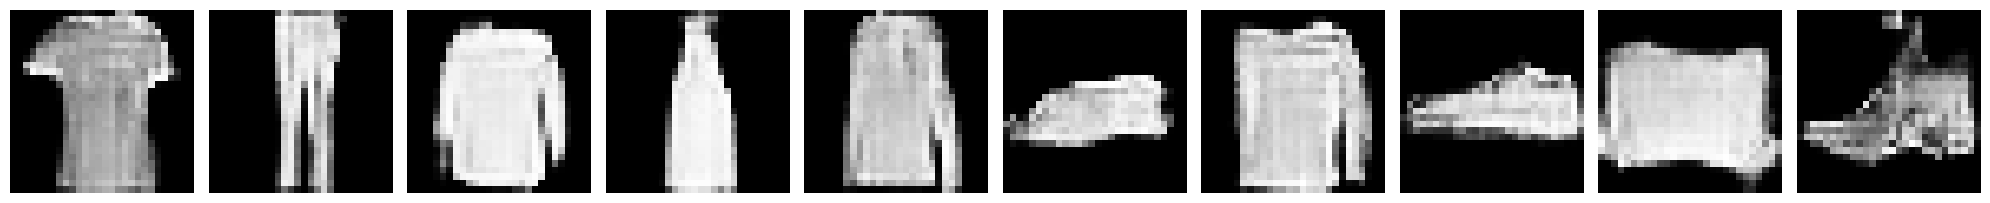

547/547 - 24s - loss: 1.4140 - d_loss: 0.6752 - g_loss: 0.7388 - 24s/epoch - 43ms/step
Epoch 84/100


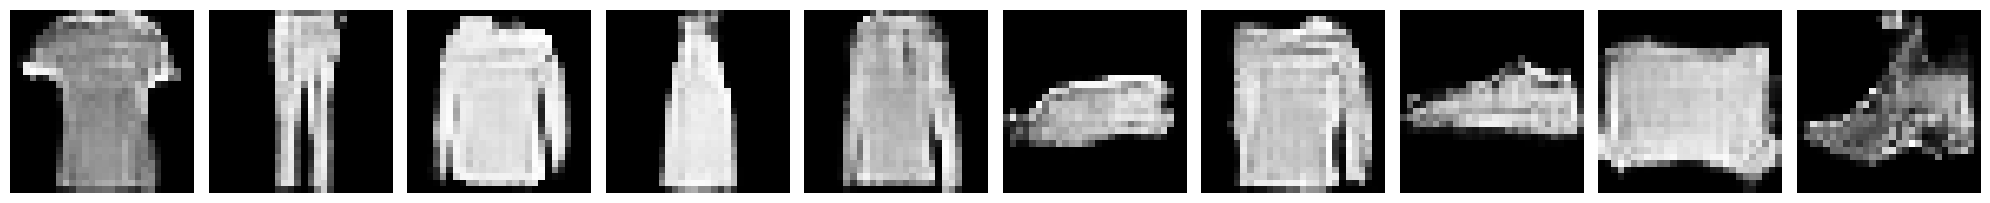

547/547 - 24s - loss: 1.3973 - d_loss: 0.6755 - g_loss: 0.7218 - 24s/epoch - 43ms/step
Epoch 85/100


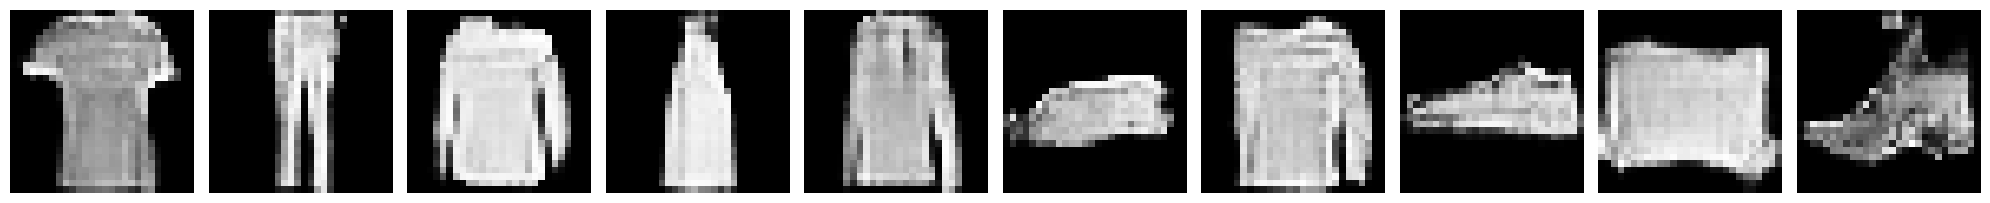

547/547 - 24s - loss: 1.4000 - d_loss: 0.6759 - g_loss: 0.7240 - 24s/epoch - 43ms/step
Epoch 86/100


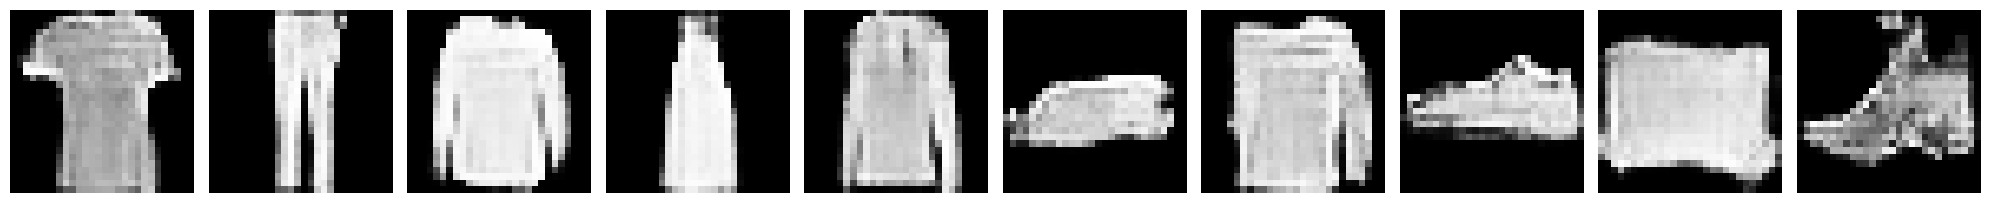

547/547 - 24s - loss: 1.4146 - d_loss: 0.6754 - g_loss: 0.7393 - 24s/epoch - 43ms/step
Epoch 87/100


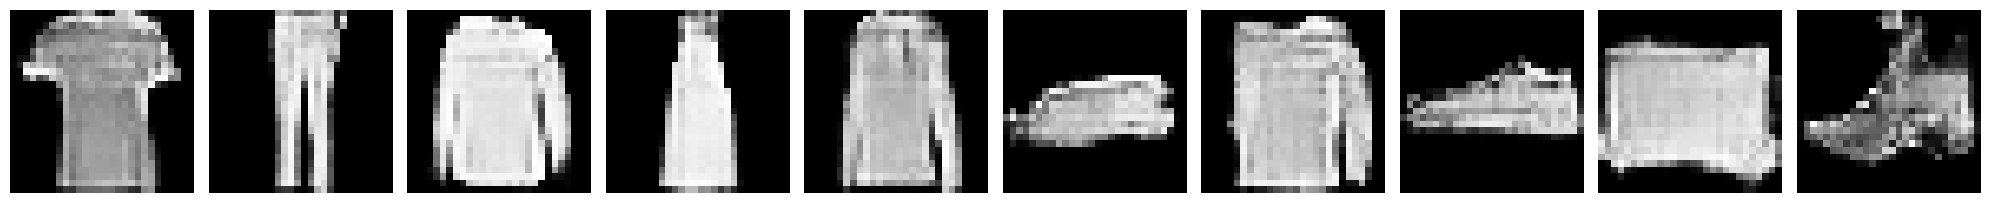

547/547 - 24s - loss: 1.3961 - d_loss: 0.6760 - g_loss: 0.7201 - 24s/epoch - 43ms/step
Epoch 88/100


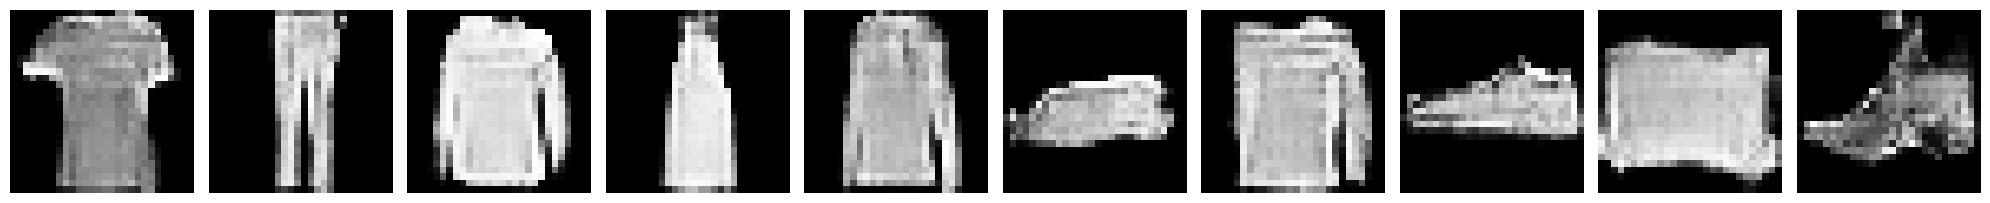

547/547 - 24s - loss: 1.3960 - d_loss: 0.6762 - g_loss: 0.7198 - 24s/epoch - 43ms/step
Epoch 89/100


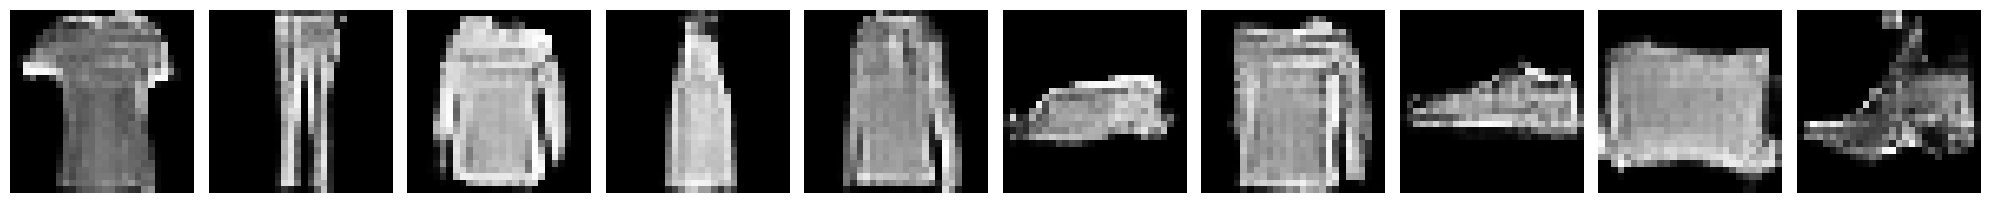

547/547 - 24s - loss: 1.4218 - d_loss: 0.6762 - g_loss: 0.7456 - 24s/epoch - 44ms/step
Epoch 90/100


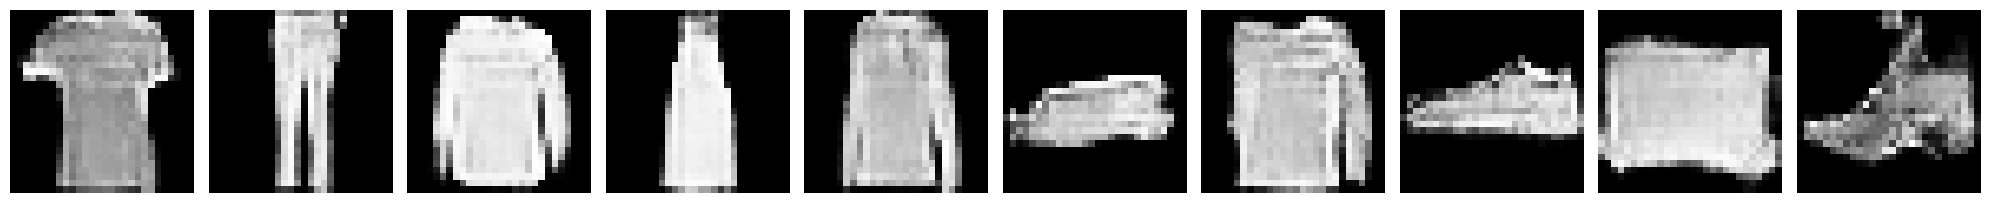

547/547 - 24s - loss: 1.3987 - d_loss: 0.6759 - g_loss: 0.7228 - 24s/epoch - 44ms/step
Epoch 91/100


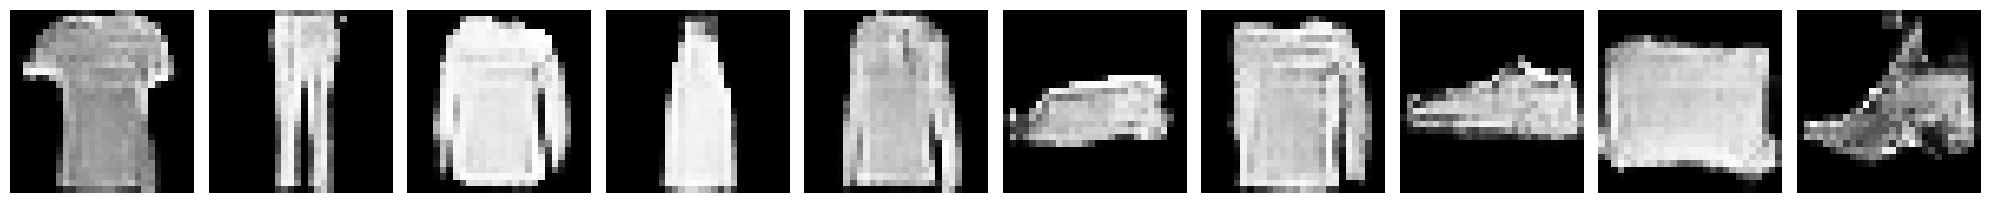

547/547 - 24s - loss: 1.3919 - d_loss: 0.6765 - g_loss: 0.7154 - 24s/epoch - 43ms/step
Epoch 92/100


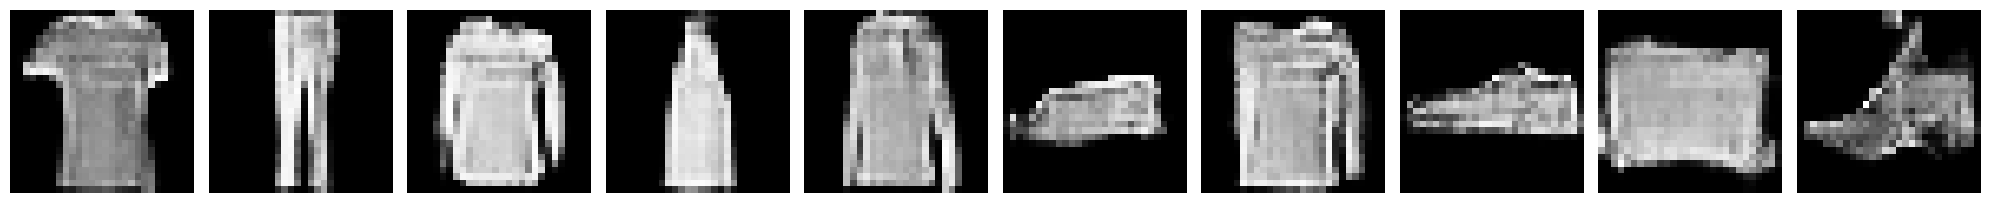

547/547 - 24s - loss: 1.4075 - d_loss: 0.6757 - g_loss: 0.7318 - 24s/epoch - 43ms/step
Epoch 93/100


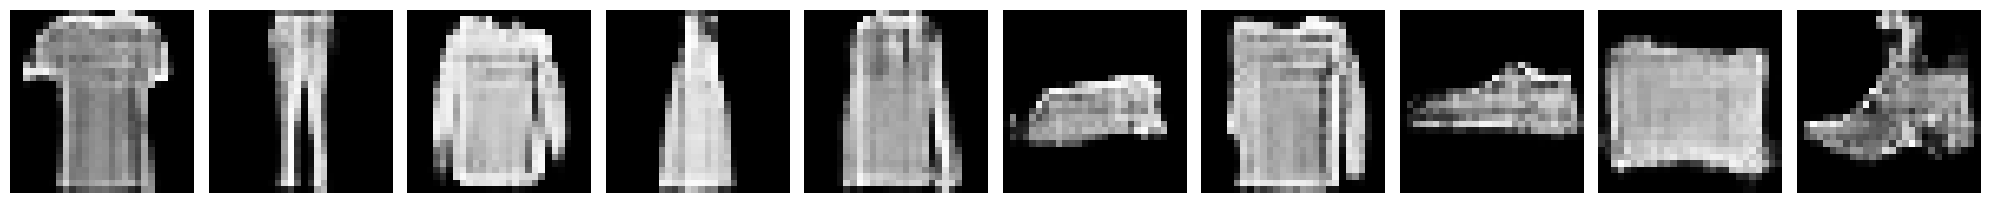

547/547 - 24s - loss: 1.4435 - d_loss: 0.6745 - g_loss: 0.7690 - 24s/epoch - 43ms/step
Epoch 94/100


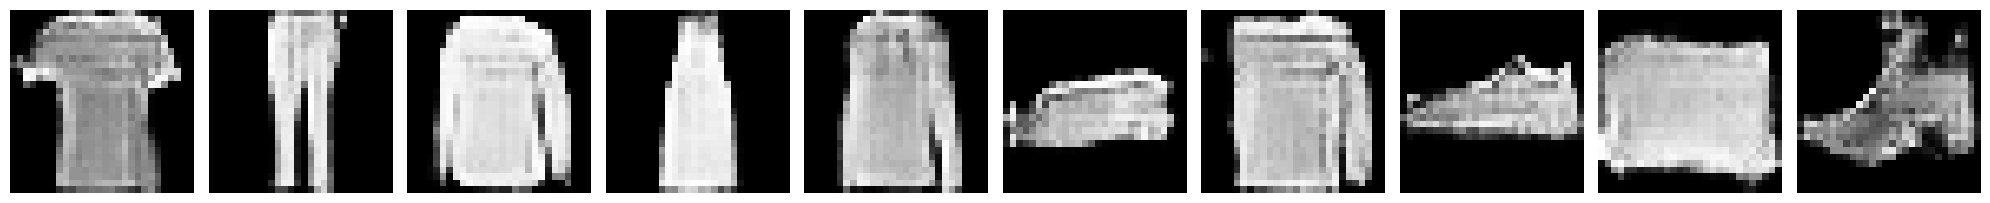

547/547 - 24s - loss: 1.4018 - d_loss: 0.6729 - g_loss: 0.7289 - 24s/epoch - 43ms/step
Epoch 95/100


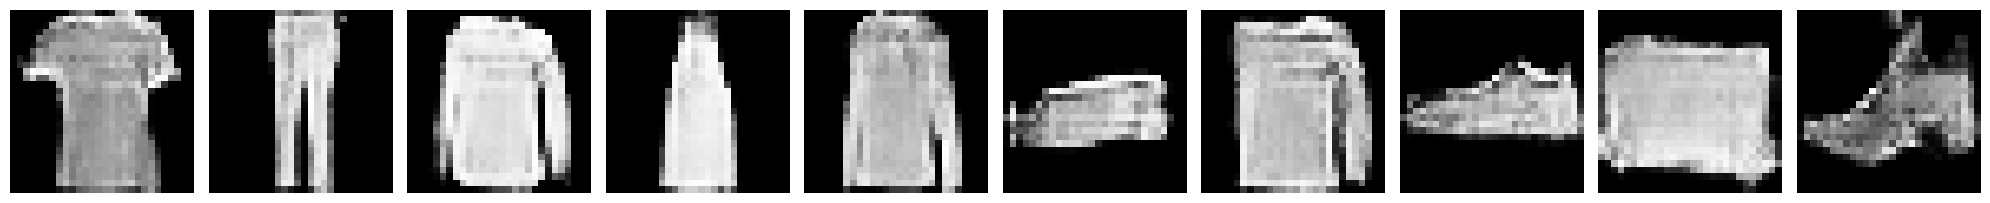

547/547 - 24s - loss: 1.3957 - d_loss: 0.6757 - g_loss: 0.7200 - 24s/epoch - 43ms/step
Epoch 96/100


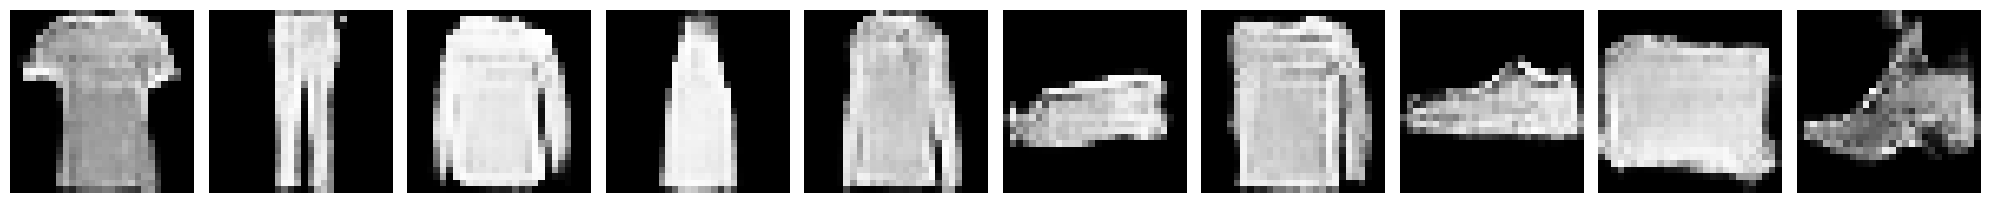

547/547 - 24s - loss: 1.3919 - d_loss: 0.6754 - g_loss: 0.7165 - 24s/epoch - 43ms/step
Epoch 97/100


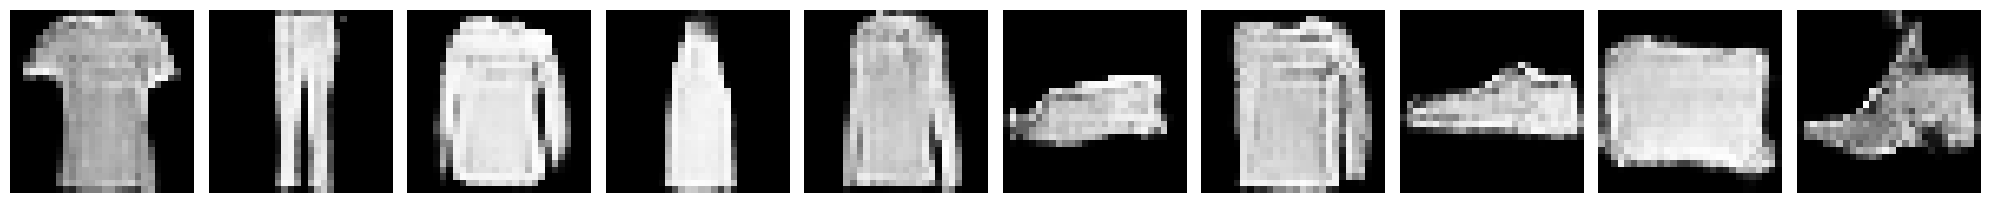

547/547 - 24s - loss: 1.4068 - d_loss: 0.6753 - g_loss: 0.7315 - 24s/epoch - 44ms/step
Epoch 98/100


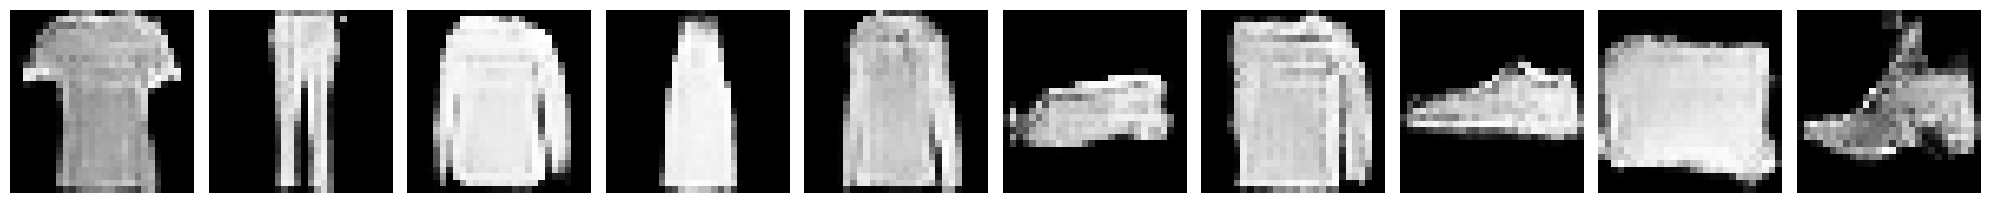

547/547 - 24s - loss: 1.4235 - d_loss: 0.6755 - g_loss: 0.7480 - 24s/epoch - 43ms/step
Epoch 99/100


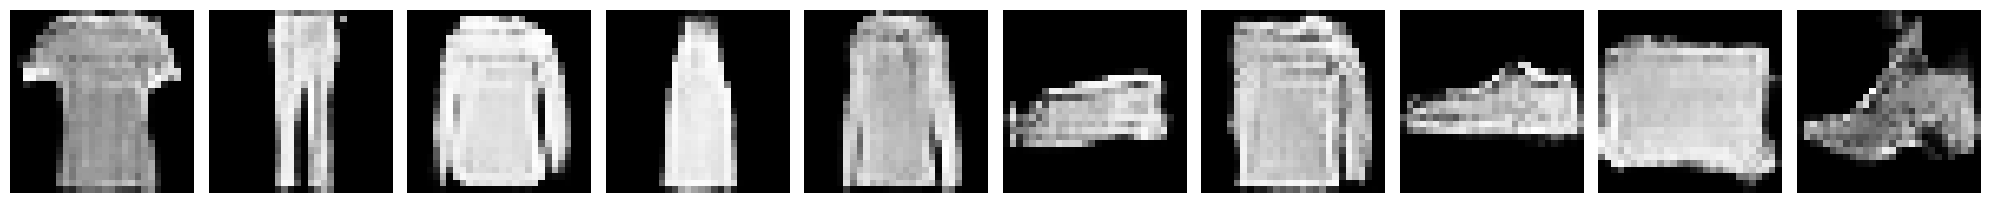

547/547 - 24s - loss: 1.3924 - d_loss: 0.6756 - g_loss: 0.7169 - 24s/epoch - 43ms/step
Epoch 100/100


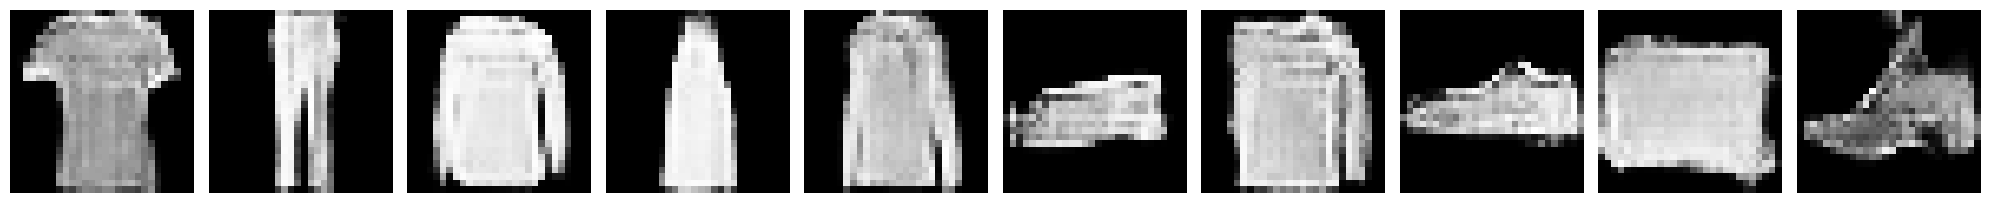

547/547 - 24s - loss: 1.3933 - d_loss: 0.6752 - g_loss: 0.7180 - 24s/epoch - 43ms/step


In [ ]:
c_history = cgan.fit(
    dataset,
    epochs = epochs,
    callbacks = [ConditionalGANMonitor(name='conditional', gray=True)],
    verbose = 2
).history

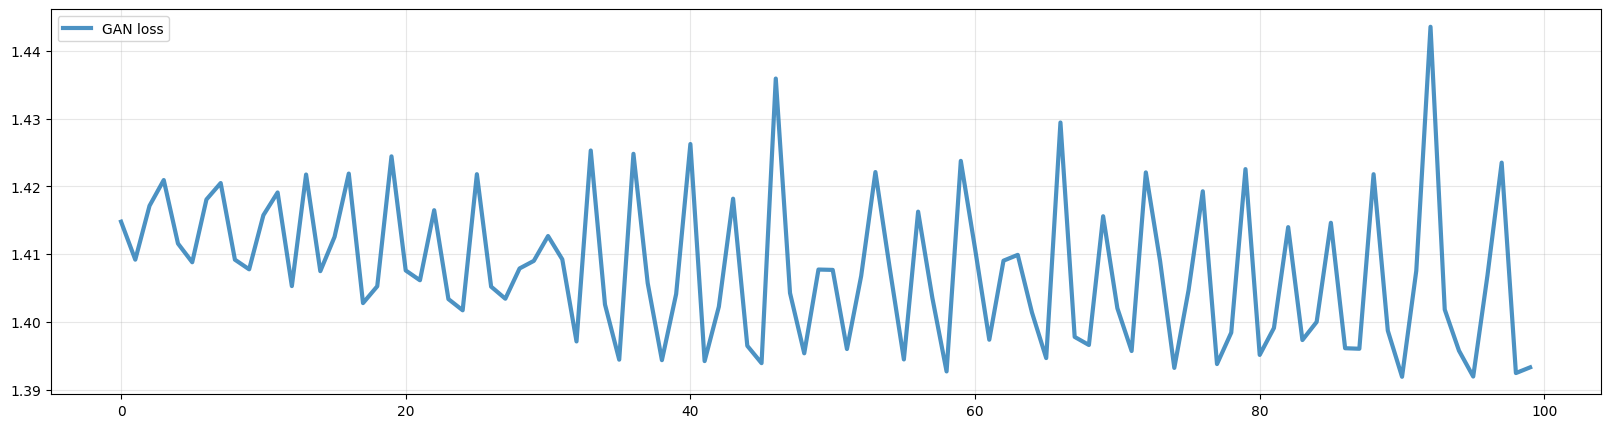

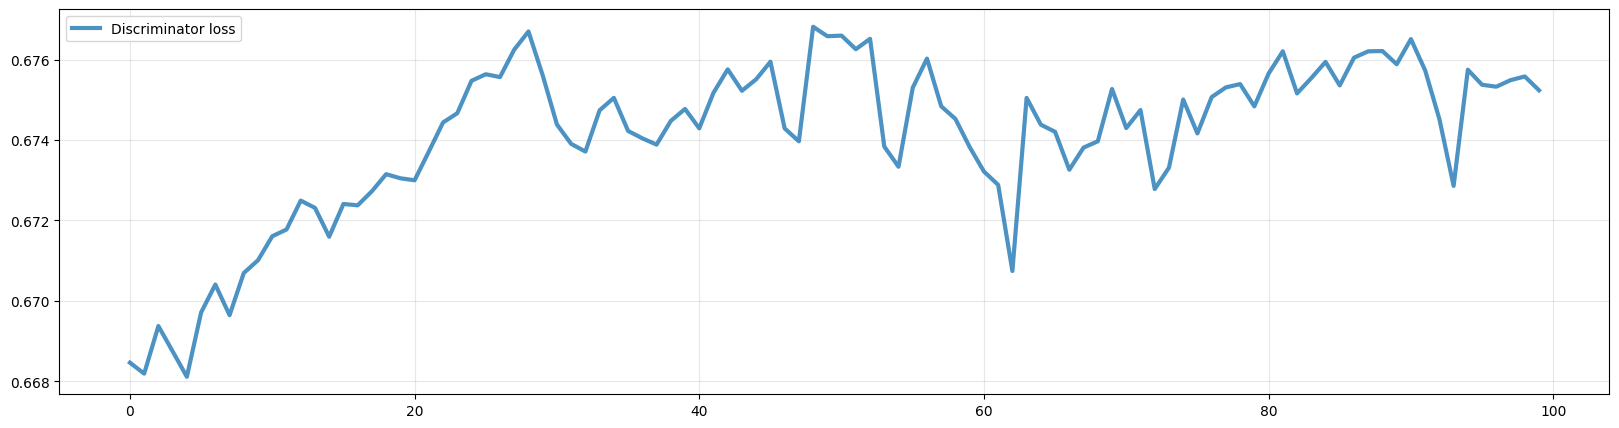

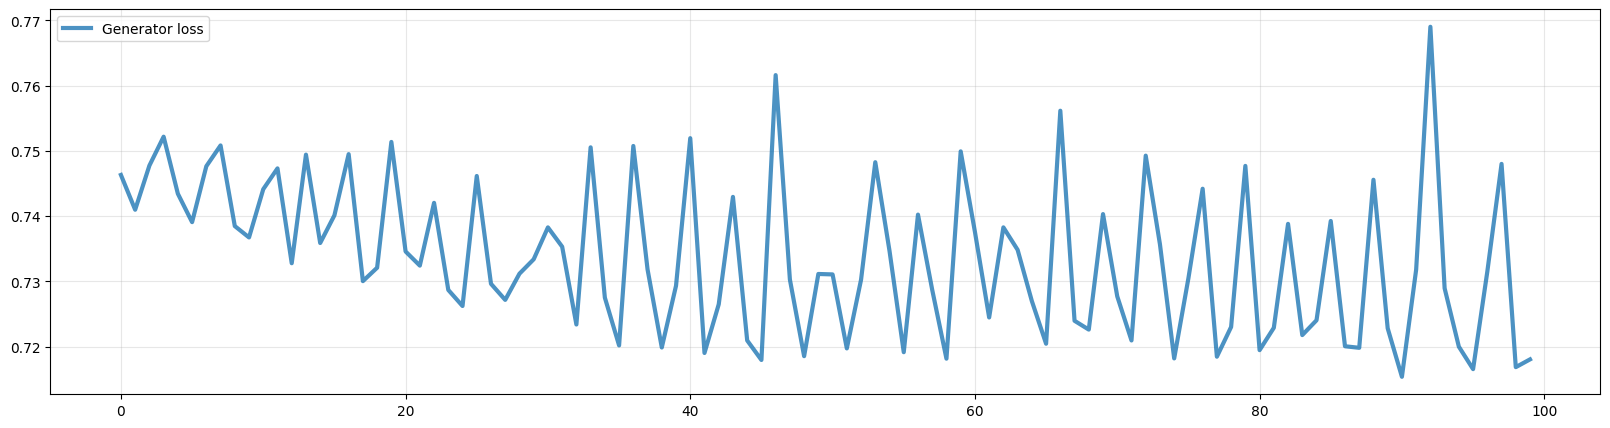

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(c_history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [ ]:
cgan.generator.save('conditional_gan_generator')

In [ ]:
conditional_gan_generator = tfk.models.load_model('conditional_gan_generator')

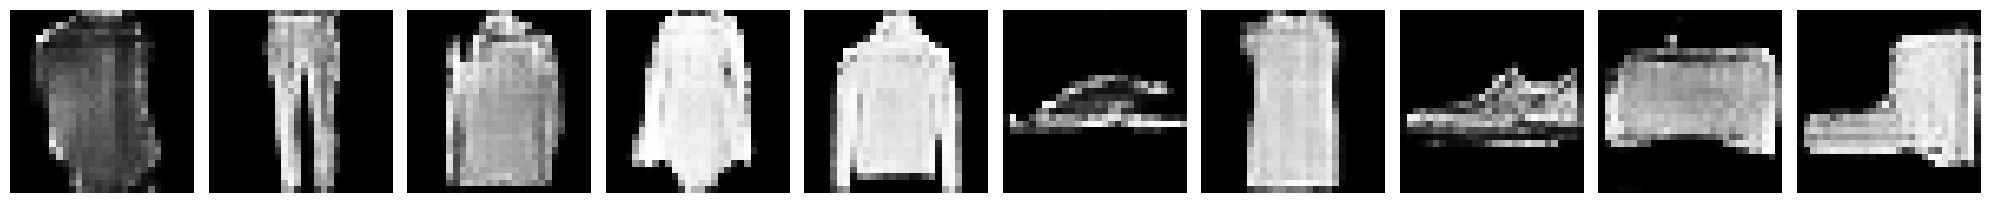

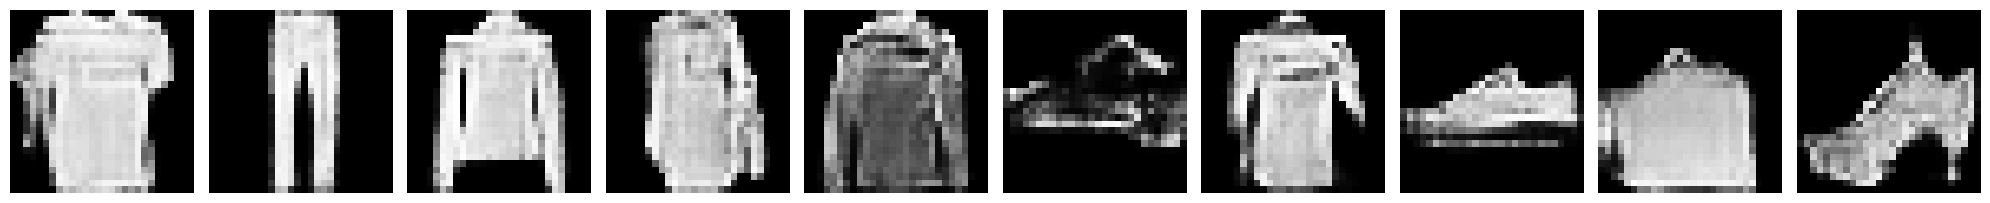

In [ ]:
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)

In [ ]:
imgs = 2500
X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim)
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127.5
X_hat = np.mean(X_hat, axis=0)
y_hat = np.argmax(y_hat,axis=1)

X_temp = X[:imgs]*127.5 + 127.5
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)
y_temp = y[:imgs]

print(X_hat.shape, X_temp.shape)

(784,) (784,)


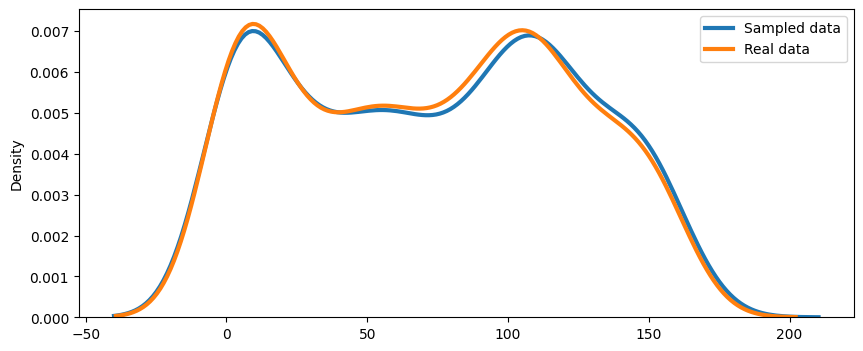

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()

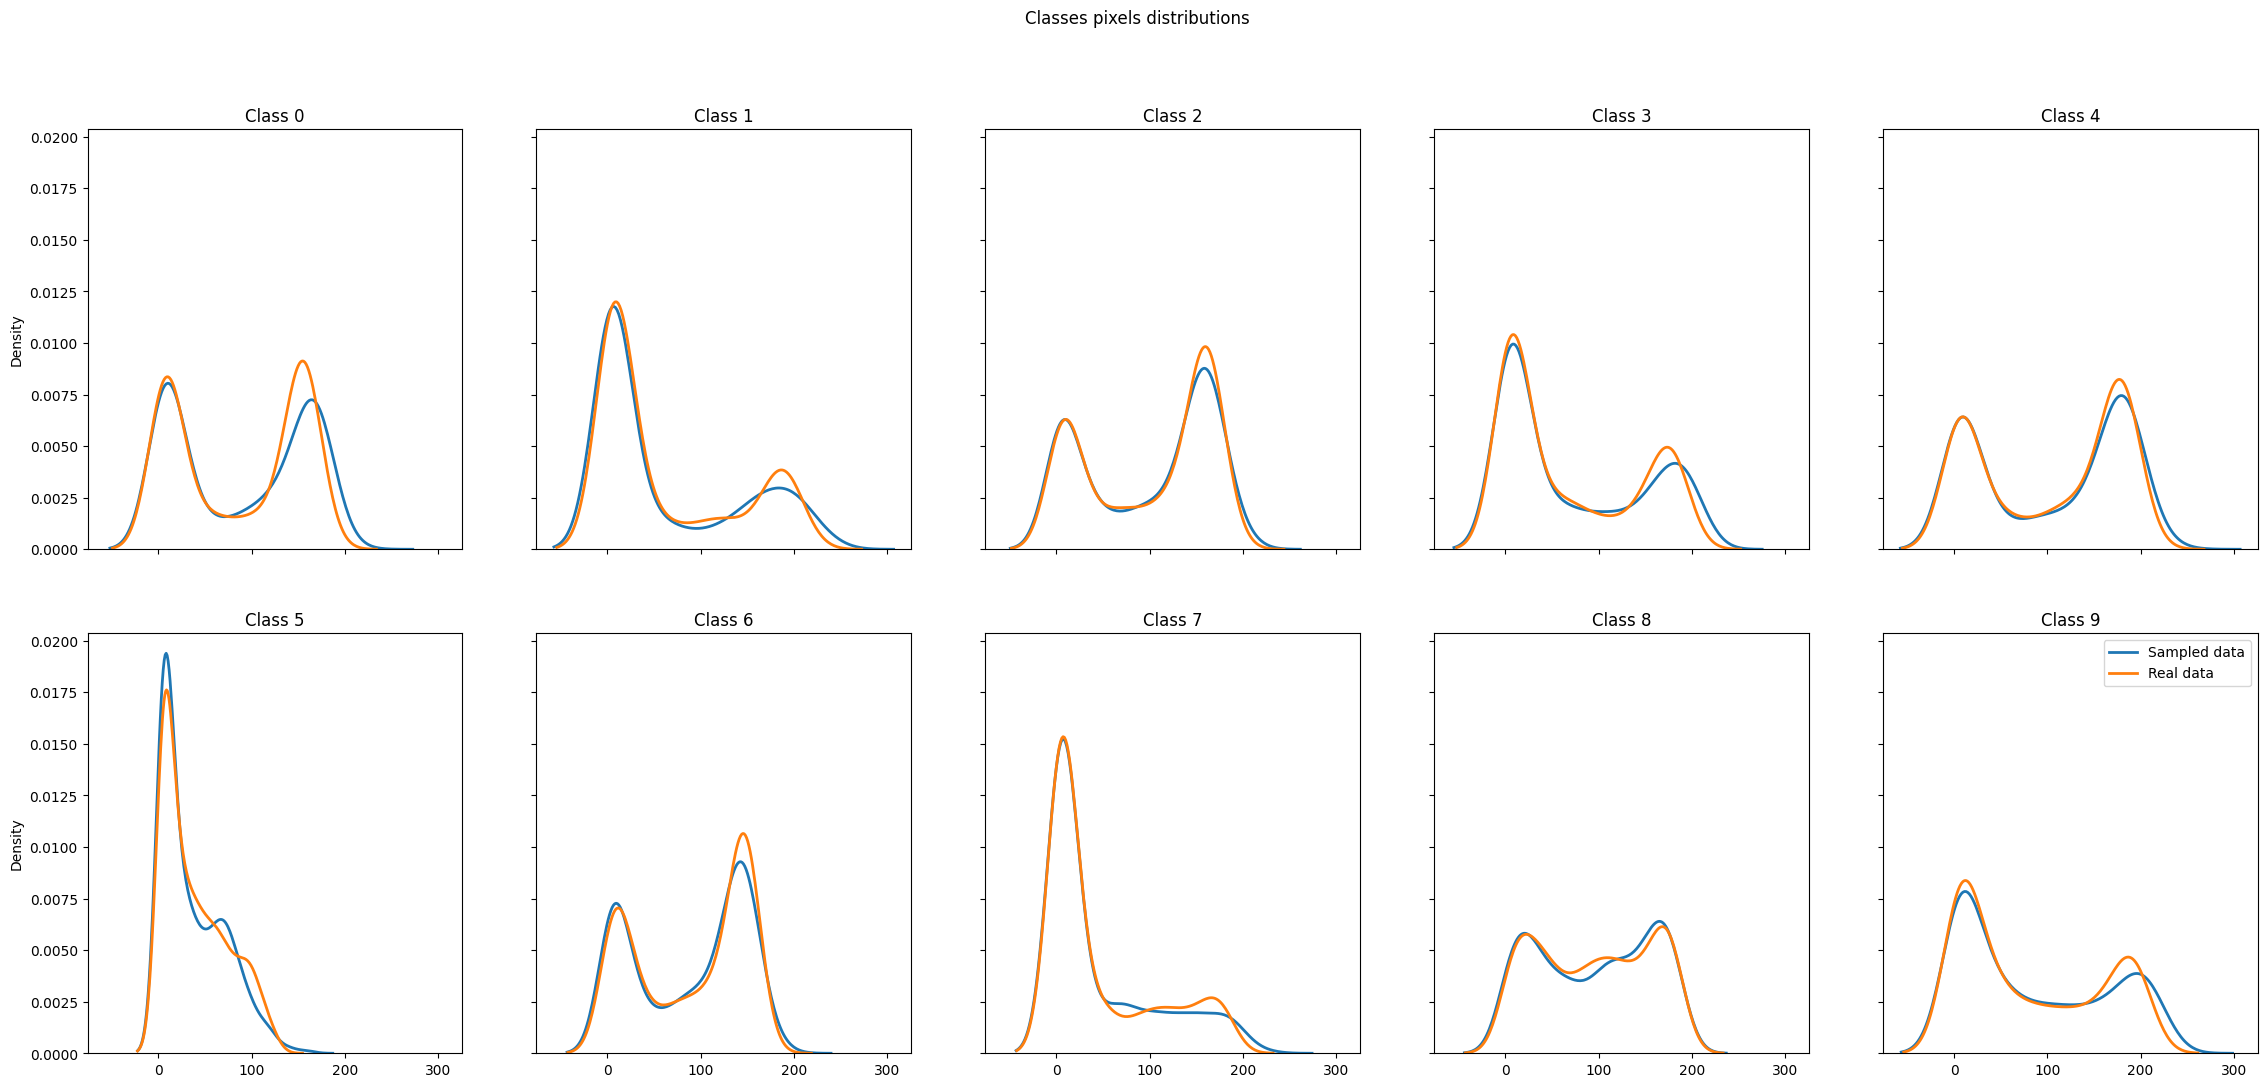

In [ ]:
imgs = 1000
fig, axes = plt.subplots(2, 5, figsize=(28,12), sharey=True, sharex=True)
fig.suptitle('Classes pixels distributions')
for i in range(10):
    X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim, label=i)
    X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127+5
    X_hat = np.mean(X_hat, axis=0)
    X_temp = X[y==i][:imgs]*127.5 + 127+5
    X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
    X_temp = np.mean(X_temp, axis=0)
    axes[i//5, i%5].set_title(f'Class {i}')
    sns.kdeplot(ax=axes[i//5, i%5], x=X_hat, label='Sampled data', linewidth=2)
    sns.kdeplot(ax=axes[i//5, i%5], x=X_temp, label='Real data', linewidth=2)
plt.legend()
plt.show()

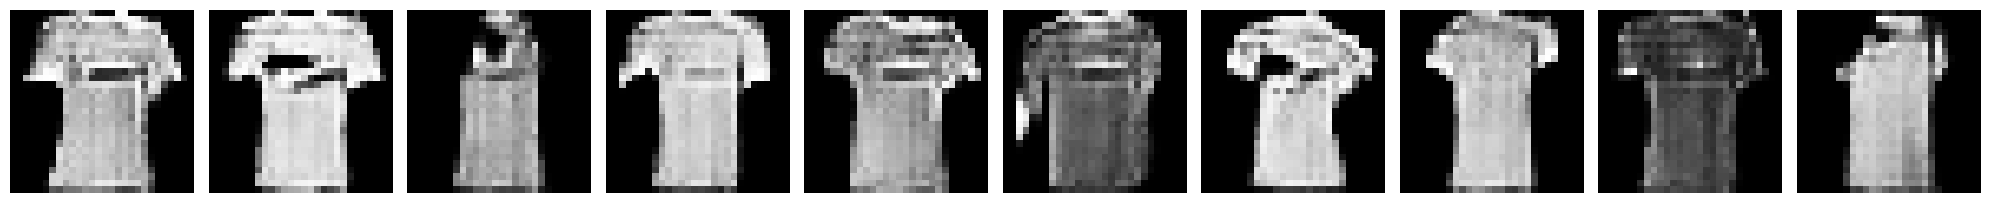

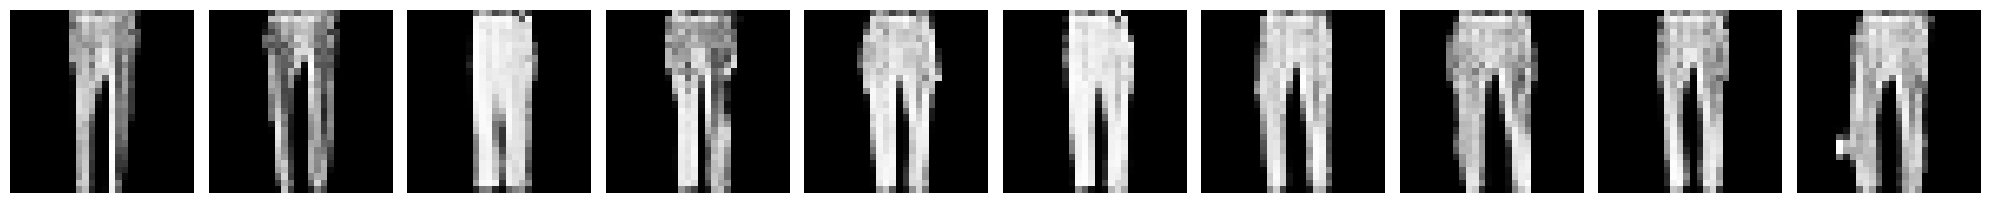

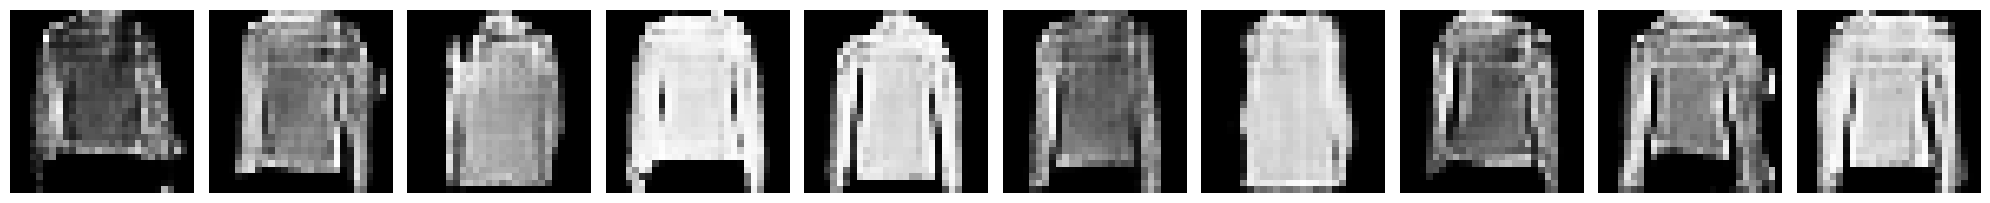

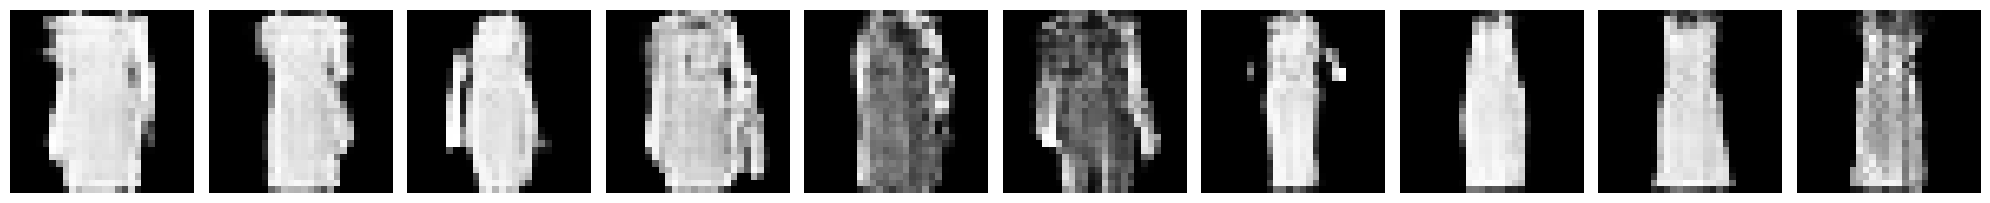

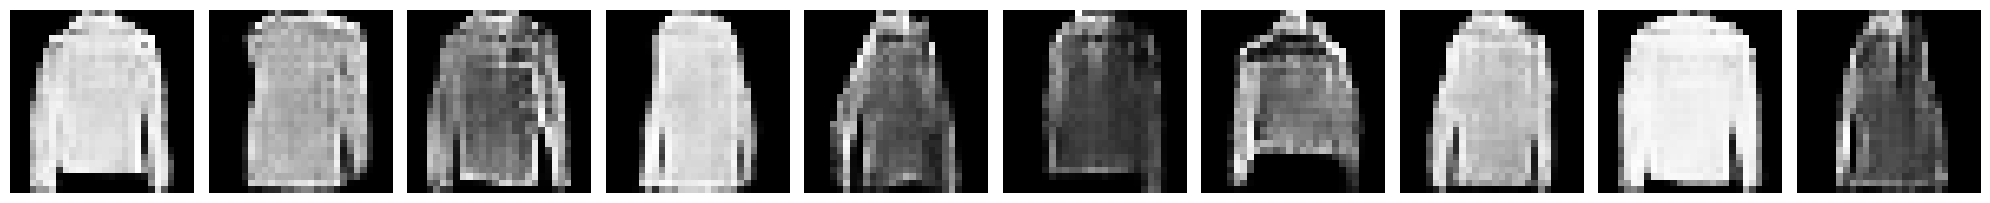

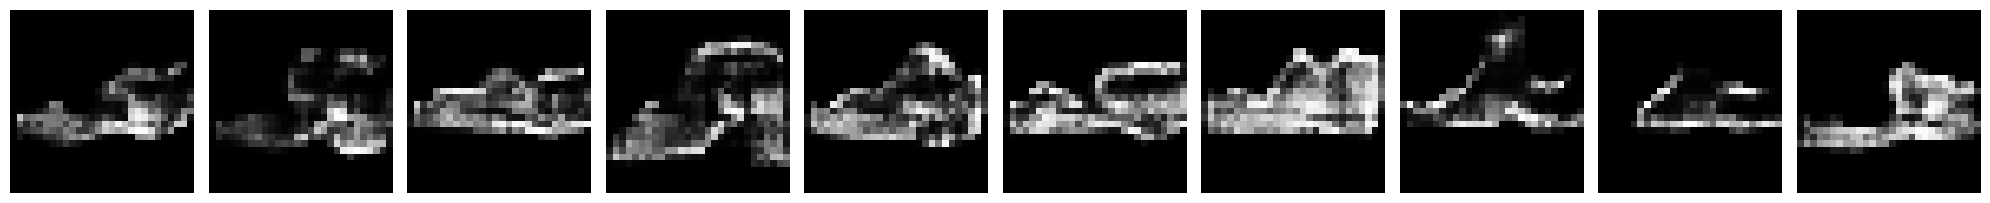

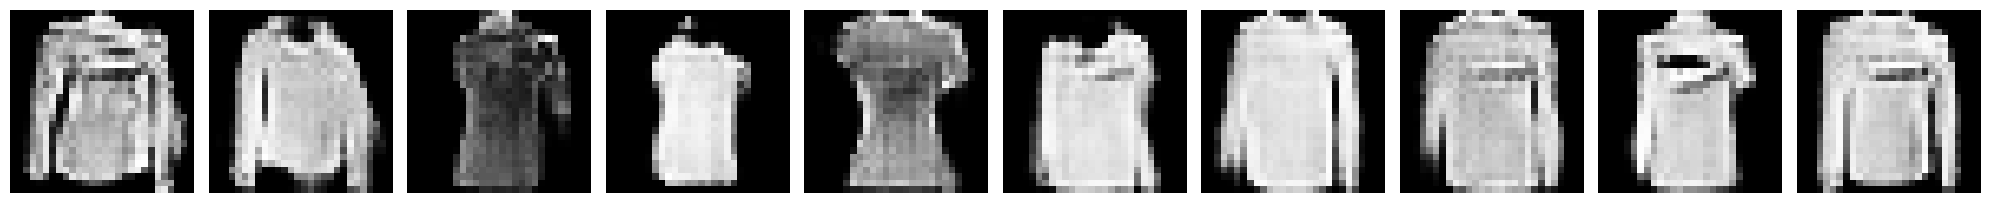

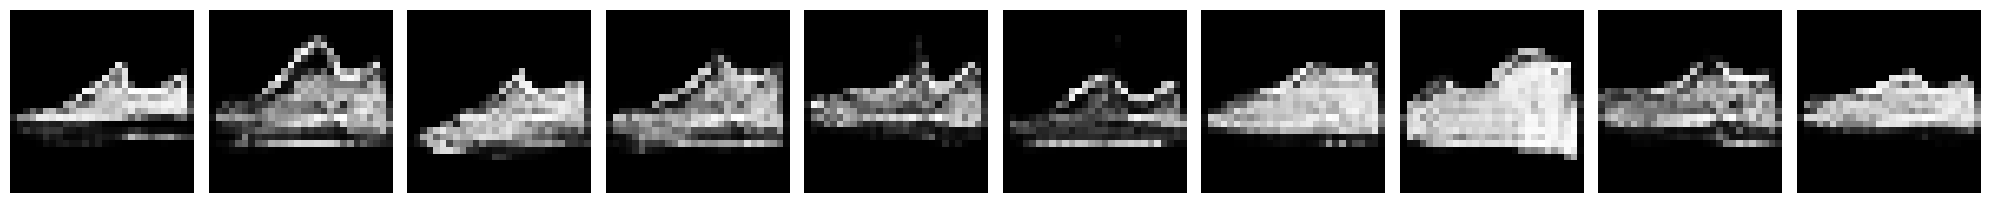

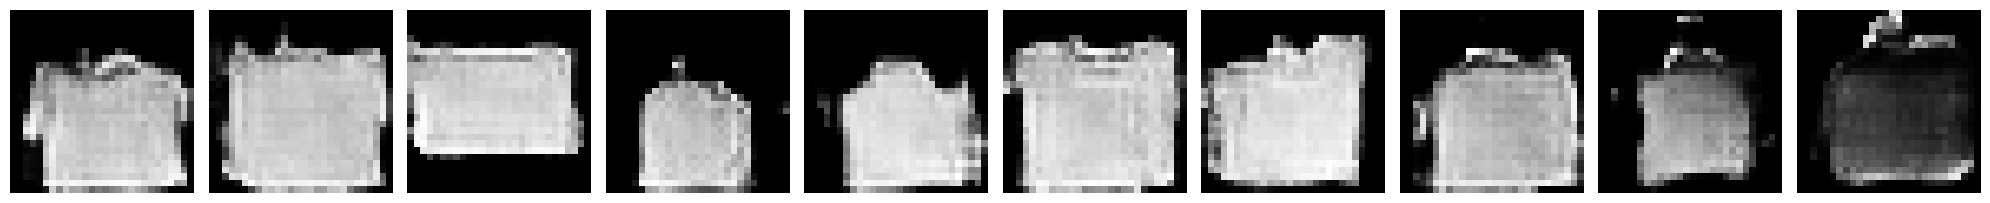

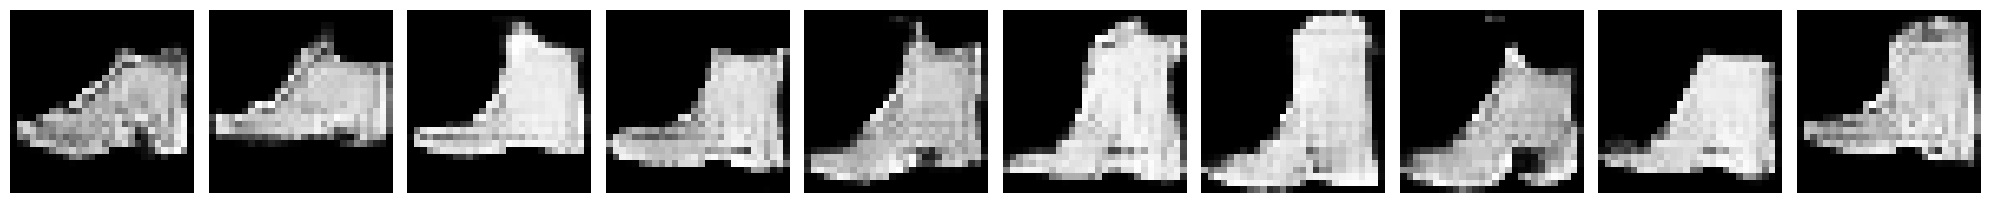

In [ ]:
for i in range(num_classes):
    conditional_sample(conditional_gan_generator, 10, latent_dim, gray=True, fixed=False, label=i)

In [ ]:
# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 500

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = tfk.utils.to_categorical([first_number], num_classes)
    second_label = tfk.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (first_label * (1 - percent_second_label) + second_label * percent_second_label)

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = conditional_gan_generator.predict(noise_and_labels, verbose=0)
    return fake


start_class = 0
end_class = 1

fake_images = interpolate_class(start_class, end_class)

In [ ]:
fake_images = interpolate_class(start_class, end_class)*127.5 + 127.5
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation01.gif", converted_images, fps=60)

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*